# Step 1: Clean raw CSV files — format and pad CAN data for model input (CAAE pre-processing)


In [ ]:
import pandas as pd
from pathlib import Path
import logging

from pathlib import Path
import logging
import pandas as pd

def clean_and_save_csv(csv_file: str) -> str:
    """
    מנקה קובץ CSV: מסיר עמודת אינדקס, מפצל ומרפד את עמודת ה-Data, ושומר מחדש.
    Label תמיד תופיע אחרי DATA[7].

    Args:
        csv_file (str): הנתיב לקובץ המקורי.

    Returns:
        str: הנתיב לקובץ החדש שנשמר.
    """
    # קריאה עם עמודה אחת ל־Data

    cols = ['Timestamp', 'CAN ID', 'DLC', 'Data', 'Label']
    df = pd.read_csv(csv_file, header=None, names=cols, low_memory=False)

    # הסרת עמודת index

    # המרות בסיסיות
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC'] = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'CAN ID'])

    # ניקוי ערכי Data
    def process_data_field(raw):
        if pd.isna(raw): return ['00'] * 8
        raw = str(raw).replace(" ", "")  # הסרת רווחים
        bytes_list = [raw[i:i+2] for i in range(0, len(raw), 2)]
        while len(bytes_list) < 8:
            bytes_list.append("00")
        return bytes_list[:8]

    # החלת הפיצול והפירוק
    processed_data = df['Data'].apply(process_data_field)
    data_df = pd.DataFrame(processed_data.tolist(), columns=[f'DATA[{i}]' for i in range(8)])
    df.drop(columns=['Data'], inplace=True)

    # עדכון DLC ל-8 אם היה פחות
    df['DLC'] = 8

    # בניית הסדר הנכון מחדש
    final_df = pd.concat([df[['Timestamp', 'CAN ID', 'DLC']].reset_index(drop=True),
                          data_df.reset_index(drop=True),
                          df[['Label']].reset_index(drop=True)], axis=1)

    # שמירה
    out_file = Path(csv_file)
    final_df.to_csv(out_file, index=False)
    logging.info(f"[CLEAN] Saved cleaned file: {out_file}")
    return str(out_file)

# רשימת שמות הקבצים מתוך התמונה
csv_files = [
    "Attack_free_CHEVROLET_Spark_train.csv",
    "Attack_free_KIA_Soul_train.csv",
    "Flooding_CHEVROLET_Spark_train.csv",
    "Flooding_HYUNDAI_Sonata_train.csv",
    "Flooding_KIA_Soul_train.csv",
    "Fuzzy_CHEVROLET_Spark_train.csv",
    'Attack_free_HY_Sonata_train.csv',
    'Attack_free_KIA_Soul_train.csv',
    'Fuzzy_dataset_HY_Sonata_train.csv',
    'Fuzzy_dataset_KIA_Soul_train.csv',
    'Malfunction_1st_dataset_HY_Sonata_train.csv',
    'Malfunction_1st_dataset_KIA_Soul_train.csv',
    'Malfunction_2nd_HY_Sonata_train.csv',
    'Malfunction_2nd_KIA_Soul_train.csv',
    'Replay_dataset_HY_Sonata_train.csv',
    'Replay_dataset_KIA_Soul_train.csv'
]


# נתיב לתיקייה המכילה את הקבצים

# הפעלת הפונקציה על כל קובץ
for fname in csv_files:
    try:
        cleaned_path = clean_and_save_csv(str(fname))
        print(f"[✓] Cleaned: {cleaned_path}")
    except Exception as e:
        print(f"[✗] Failed: {fname} — {e}")


[✓] Cleaned: Attack_free_CHEVROLET_Spark_train.csv
[✓] Cleaned: Attack_free_KIA_Soul_train.csv
[✓] Cleaned: Flooding_CHEVROLET_Spark_train.csv
[✓] Cleaned: Flooding_HYUNDAI_Sonata_train.csv
[✓] Cleaned: Flooding_KIA_Soul_train.csv
[✓] Cleaned: Fuzzy_CHEVROLET_Spark_train.csv
[✓] Cleaned: Attack_free_HY_Sonata_train.csv
[✓] Cleaned: Attack_free_KIA_Soul_train.csv
[✓] Cleaned: Fuzzy_dataset_HY_Sonata_train.csv
[✓] Cleaned: Fuzzy_dataset_KIA_Soul_train.csv
[✓] Cleaned: Malfunction_1st_dataset_HY_Sonata_train.csv
[✓] Cleaned: Malfunction_1st_dataset_KIA_Soul_train.csv
[✓] Cleaned: Malfunction_2nd_HY_Sonata_train.csv
[✓] Cleaned: Malfunction_2nd_KIA_Soul_train.csv
[✓] Cleaned: Replay_dataset_HY_Sonata_train.csv
[✓] Cleaned: Replay_dataset_KIA_Soul_train.csv


THIS MODEL BUILD AS THE FIRST PROTOTYP MODEL OF AAE

THIS MODEL BUILD FOR FIND THE BEST HYPERPARMTER SEARCH

In [ ]:
# ✅ גרסה מלאה של הפייפליין כולל AAE + Keras Tuner לאדברסיאל אוטואינקודר

import os
import glob
import sys
import subprocess
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, Dropout, LeakyReLU, Activation
# התקנת keras-tuner אם צריך
try:
    import keras_tuner as kt
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'keras-tuner'])
    import keras_tuner as kt

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# 1) CSV → windows → TFRecord (with file checks)
# ------------------------------------------------------------
datasets = ['DoS','Fuzzy','RPM','gear','parsed_dataset']
csv_map = {
    'DoS': 'DoS_dataset.csv',
    'Fuzzy': 'Fuzzy_dataset.csv',
    'RPM': 'RPM_dataset.csv',
    'gear': 'gear_dataset.csv',
    'parsed_dataset': 'parsed_dataset.csv'
}
FEATURE_DIM = 29*29*2
N_LABELS    = 2
BATCH       = 128
EPOCHS      = 30

# helper functions for preprocessing
def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data'+str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid),16))[2:].zfill(29)
        return np.array(list(map(int,b)),dtype=np.uint8)
    except:
        return np.zeros(29,dtype=np.uint8)

def hex_to_int(x):
    try: return int(str(x).strip(),16)
    except: return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp','canID','DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp','canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag'] = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')
    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values
    win = 29; N = len(bits_all)//win
    bits = bits_all[:N*win].reshape(N,win,29)
    data = data_bytes[:N*win].reshape(N,win,8)
    flags= flags_all[:N*win].reshape(N,win)
    rows=[]
    for i in range(N):
        id_img = bits[i].astype(np.uint8)
        last_b = data[i,-1,:]
        b8 = np.unpackbits(last_b,axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32),(29,29), interpolation=cv2.INTER_NEAREST)>0.5
        two_ch = np.stack([id_img, data_img.astype(np.uint8)],axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl = int(flags[i].any())
        rows.append((feat_int,lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7*len(rows)); nvl = int(0.15*len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph,ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as w:
            for feat,lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                w.write(ex.SerializeToString())

# create/check TFRecords
expected=[]
for a in datasets:
    for ph in ('train','val','test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a!='parsed_dataset': expected.append(f"Normal_{a}_{ph}.tfrecord")
if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src=csv_map[a]
        if not os.path.exists(src): print(f"[WARN] {src} not found")
        else:
            rows=preprocess_windows(src)
            normals=[r for r in rows if r[1]==0]
            attacks=[r for r in rows if r[1]==1]
            write_tfrecord(normals,f"Normal_{a}")
            if attacks: write_tfrecord(attacks,a)
else:
    print("[DATA] All TFRecords found.")

# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat=tf.io.parse_single_example(proto,{
        'features':tf.io.FixedLenFeature([FEATURE_DIM],tf.int64),
        'label':   tf.io.FixedLenFeature([1],tf.int64)
    })
    x=tf.cast(feat['features'],tf.float32)
    y=tf.one_hot(tf.cast(feat['label'][0],tf.int32),N_LABELS)
    return x,y

def make_datasets():
    print('[PIPE] Building datasets...')
    train_files=glob.glob('Normal_*_train.tfrecord')
    val_files  =glob.glob('Normal_*_val.tfrecord')
    ds_train=(tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
              .map(parse_feat, tf.data.AUTOTUNE)
              .map(lambda x,y:(x+tf.random.normal(tf.shape(x),0,0.01),x,y), tf.data.AUTOTUNE)
              .shuffle(10000).batch(BATCH).prefetch(tf.data.AUTOTUNE))
    ds_val  =(tf.data.TFRecordDataset(val_files, num_parallel_reads=tf.data.AUTOTUNE)
              .map(parse_feat, tf.data.AUTOTUNE)
              .map(lambda x,y:(x,x,y), tf.data.AUTOTUNE)
              .batch(BATCH).prefetch(tf.data.AUTOTUNE))
    print(f'[PIPE] Train files: {len(train_files)}, Val files: {len(val_files)}')
    return ds_train, ds_val

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self, n_l1, n_l2, latent_dim, lam_gp, n_layers=2, dropout_rate=0.2, activation='relu', norm_type='batch'):
        super().__init__()
        self.norm_type = norm_type
        self.activation = activation
        self.dropout_rate = dropout_rate
        # Encoder
        self.enc_layers = []
        self.enc_norms = []
        self.enc_drops = []
        for i in range(n_layers):
            units = n_l1 if i == 0 else n_l2
            self.enc_layers.append(tf.keras.layers.Dense(units))
            if norm_type == 'batch':
                self.enc_norms.append(BatchNormalization())
            else:
                self.enc_norms.append(LayerNormalization())
            self.enc_drops.append(Dropout(dropout_rate))
        self.ez = tf.keras.layers.Dense(latent_dim)
        self.ey = tf.keras.layers.Dense(N_LABELS)
        # Decoder
        self.dec_layers = []
        self.dec_norms = []
        self.dec_drops = []
        for i in range(n_layers):
            units = n_l2 if i == 0 else n_l1
            self.dec_layers.append(tf.keras.layers.Dense(units))
            if norm_type == 'batch':
                self.dec_norms.append(BatchNormalization())
            else:
                self.dec_norms.append(LayerNormalization())
            self.dec_drops.append(Dropout(dropout_rate))
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')
        # Discriminators
        self.dz1 = tf.keras.layers.Dense(n_l1)
        self.dz2 = tf.keras.layers.Dense(n_l2)
        self.dzout = tf.keras.layers.Dense(1)
        self.dy1 = tf.keras.layers.Dense(n_l1)
        self.dy2 = tf.keras.layers.Dense(n_l2)
        self.dyout = tf.keras.layers.Dense(1)
        self.lam_gp = lam_gp
        self.input_norm = LayerNormalization()
    def _apply_activation(self, x):
        if self.activation == 'leaky_relu':
            return LeakyReLU()(x)
        elif self.activation == 'elu':
            return tf.keras.activations.elu(x)
        else:
            return tf.keras.activations.relu(x)
    def encode(self, x):
        h = self.input_norm(x)
        for l, n, d in zip(self.enc_layers, self.enc_norms, self.enc_drops):
            h = l(h)
            h = n(h)
            h = self._apply_activation(h)
            h = d(h)
        z = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits
    def decode(self, z, y):
        h = tf.concat([z, y], 1)
        for l, n, d in zip(self.dec_layers, self.dec_norms, self.dec_drops):
            h = l(h)
            h = n(h)
            h = self._apply_activation(h)
            h = d(h)
        return self.dout(h)
    def discriminate_z(self, z):
        h = self._apply_activation(self.dz1(z))
        h = self._apply_activation(self.dz2(h))
        return self.dzout(h)
    def discriminate_y(self, y):
        h = self._apply_activation(self.dy1(y))
        h = self._apply_activation(self.dy2(h))
        return self.dyout(h)
    def gradient_penalty(self, f, real, fake):
        a = tf.random.uniform([real.shape[0], 1], 0, 1)
        i = real + a * (fake - real)
        with tf.GradientTape() as t:
            t.watch(i)
            p = f(i)
        g = t.gradient(p, i)
        s = tf.sqrt(tf.reduce_sum(tf.square(g), axis=1) + 1e-8)
        return tf.reduce_mean((s - 1) ** 2)

class AAEHyperModel(kt.HyperModel):
    def build(self, hp):
        n_layers = hp.Int('n_layers', 2, 4)
        dropout_rate = hp.Float('dropout', 0.0, 0.5, step=0.1)
        activation = hp.Choice('activation', ['relu', 'elu', 'leaky_relu'])
        norm_type = hp.Choice('norm_type', ['batch', 'layer'])
        return AAE(
            hp.Int('n_l1', 256, 1024, 256),
            hp.Int('n_l2', 256, 1024, 256),
            hp.Int('latent_dim', 16, 128, 16),
            hp.Choice('lambda_gp', [1.0, 5.0, 10.0, 20.0]),
            n_layers=n_layers,
            dropout_rate=dropout_rate,
            activation=activation,
            norm_type=norm_type
        )
    def fit(self, hp, model, ds_train, ds_val, epochs, steps_per_epoch, **kwargs):
        print('[TUNER] fit start')
        opt_ae = tf.keras.optimizers.Adam(hp.Choice('lr_ae', [1e-3, 5e-4, 1e-4]))
        opt_dz = tf.keras.optimizers.Adam(hp.Choice('lr_dz', [1e-4, 5e-5]))
        opt_dy = tf.keras.optimizers.Adam(hp.Choice('lr_dy', [1e-4, 5e-5]))
        opt_g = tf.keras.optimizers.Adam(hp.Choice('lr_g', [1e-4, 5e-5]))
        mse = tf.keras.losses.MeanSquaredError()
        ce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        for e in range(epochs):
            print(f'[TUNER] Epoch {e+1}/{epochs}')
            for step, (xn, xc, y) in enumerate(ds_train.take(steps_per_epoch)):
                # AE
                with tf.GradientTape() as t:
                    z, yp, logits = model.encode(xn)
                    xr = model.decode(z, yp)
                    loss_re = mse(xc, xr)
                vars_ae = []
                for l in model.enc_layers + model.dec_layers:
                    vars_ae += l.trainable_variables
                vars_ae += model.ez.trainable_variables + model.ey.trainable_variables + model.dout.trainable_variables
                opt_ae.apply_gradients(zip(t.gradient(loss_re, vars_ae), vars_ae))
                # D_z
                with tf.GradientTape() as t:
                    zr = tf.random.normal([xn.shape[0], model.ez.units])
                    dzr, dzf = model.discriminate_z(zr), model.discriminate_z(z)
                    loss_dz = tf.reduce_mean(dzf) - tf.reduce_mean(dzr) + model.lam_gp * model.gradient_penalty(model.discriminate_z, zr, z)
                vars_dz = model.dz1.trainable_variables + model.dz2.trainable_variables + model.dzout.trainable_variables
                opt_dz.apply_gradients(zip(t.gradient(loss_dz, vars_dz), vars_dz))
                # D_y
                with tf.GradientTape() as t:
                    dyr, dyf = model.discriminate_y(y), model.discriminate_y(yp)
                    loss_dy = tf.reduce_mean(dyf) - tf.reduce_mean(dyr) + model.lam_gp * model.gradient_penalty(model.discriminate_y, y, yp)
                vars_dy = model.dy1.trainable_variables + model.dy2.trainable_variables + model.dyout.trainable_variables
                opt_dy.apply_gradients(zip(t.gradient(loss_dy, vars_dy), vars_dy))
                # G
                with tf.GradientTape() as t:
                    zf = model.discriminate_z(model.encode(xc)[0])
                    yf = model.discriminate_y(model.encode(xc)[1])
                    loss_g = -tf.reduce_mean(zf) - tf.reduce_mean(yf) + ce(y, logits)
                vars_g = []
                for l in model.enc_layers:
                    vars_g += l.trainable_variables
                vars_g += model.ez.trainable_variables + model.ey.trainable_variables
                opt_g.apply_gradients(zip(t.gradient(loss_g, vars_g), vars_g))
        vals = []
        for xv, xc, _ in ds_val:
            z, y, _ = model.encode(xv)
            xr = model.decode(z, y)
            vals.append(mse(xc, xr).numpy())
        avg = np.mean(vals)
        print(f'[TUNER] Val MSE: {avg:.4f}')
        return avg

# ------------------------------------------------------------
# 5) Hyperparameter search
# ------------------------------------------------------------
ds_train,ds_val=make_datasets()
steps=sum(1 for _ in tf.data.TFRecordDataset(glob.glob('Normal_*_train.tfrecord')))//BATCH
hypermodel=AAEHyperModel()
tuner=kt.RandomSearch(hypermodel,objective=kt.Objective('val_loss','min'),max_trials=10,directory='aae_adv_tuner',project_name='adv_aae')
print('[TUNER] Searching...')
tuner.search(ds_train=ds_train,ds_val=ds_val,epochs=5,steps_per_epoch=steps)
best_hp=tuner.get_best_hyperparameters()[0]
print('[TUNER] Best HP:',best_hp.values)

# ------------------------------------------------------------
# 6) Train final with best HP
# ------------------------------------------------------------
print('[TRAIN] Final training...')
best_model=hypermodel.build(best_hp)
ds_train,ds_val=make_datasets()
_ = AAEHyperModel().fit(best_hp,best_model,ds_train,ds_val,EPOCHS,steps)

# ------------------------------------------------------------
# 7) Save and evaluate
# ------------------------------------------------------------
from tensorflow.keras.layers import Input,Activation,Concatenate
from tensorflow.keras.models import Model
print('[SAVE] Saving encoder & decoder')
enc_in=Input((FEATURE_DIM,));h=best_model.e2(best_model.e1(enc_in));z=best_model.ez(h);y=Activation('softmax')(best_model.ey(h))
enc_model=Model(enc_in,[z,y],name='aae_encoder')
z_in=Input((best_model.ez.units,));y_in=Input((N_LABELS,));merged=Concatenate()([z_in,y_in]);h=best_model.d2(best_model.d1(merged));out=best_model.dout(h)
dec_model=Model([z_in,y_in],out,name='aae_decoder')
enc_model.save('aae_encoder.keras');dec_model.save('aae_decoder.keras')
print('[SAVE] Models saved')
errs,ys=[],[]
for fn in glob.glob('*_test.tfrecord'):
    label=0 if fn.startswith('Normal_') else 1
    for x,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(256):
        z_p,y_p=enc_model(x);x_r=dec_model([z_p,y_p]);e=tf.reduce_mean((x-x_r)**2,1).numpy()
        errs.append(e);ys.append(np.full(e.shape,label))
errs,ys=np.concatenate(errs),np.concatenate(ys)
fpr,tpr,ths=roc_curve(ys,errs);roc=auc(fpr,tpr);opt_i=np.argmax(tpr-fpr);opt_t=ths[opt_i]
print(f'ROC AUC:{roc:.4f} thr:{opt_t:.6f} TPR:{tpr[opt_i]:.3f} FPR:{fpr[opt_i]:.3f}')
print('CM:',confusion_matrix(ys,(errs>opt_t).astype(int)))
print(classification_report(ys,(errs>opt_t).astype(int),target_names=['Normal','Attack']))


Trial 10 Complete [00h 51m 29s]
val_loss: 0.017599908635020256

Best val_loss So Far: 0.01379714347422123
Total elapsed time: 08h 21m 40s
[TUNER] Best HP: {'n_layers': 2, 'dropout': 0.2, 'activation': 'elu', 'norm_type': 'layer', 'n_l1': 1024, 'n_l2': 768, 'latent_dim': 64, 'lambda_gp': 10.0, 'lr_ae': 0.0005, 'lr_dz': 0.0001, 'lr_dy': 0.0001, 'lr_g': 5e-05}
[TRAIN] Final training...
[PIPE] Building datasets...
[PIPE] Train files: 5, Val files: 5
[TUNER] fit start
[TUNER] Epoch 1/30
[TUNER] Epoch 2/30
[TUNER] Epoch 3/30
[TUNER] Epoch 4/30
[TUNER] Epoch 5/30
[TUNER] Epoch 6/30
[TUNER] Epoch 7/30


# =======================================================================================
# 🛡️ CAN Bus Intrusion Detection using Tuned Adversarial Autoencoder (AAE)
# =======================================================================================
# This script implements a full pipeline for detecting anomalies in CAN bus traffic
# using a carefully tuned Adversarial Autoencoder (AAE) model.
#
# 💡 Features:
# - Converts CAN messages into 2-channel (ID + Data) pseudo-images of shape 29x29x2
# - Trains an AAE model to learn compressed representations (z) and categorical labels (y)
# - Detects anomalies via reconstruction error on test sets
# - Uses both class and latent discriminators with gradient penalty for adversarial training
#
# 🔧 Tuned Hyperparameters (post-optimization):
# - Latent dimension (z):        64
# - Encoder/Decoder layers:      [1024, 768]
# - Activation function:         ELU
# - Dropout:                     0.2
# - Normalization:               LayerNorm
# - λ (gradient penalty):        10.0
#
# 🚀 Optimizer Learning Rates:
# - Autoencoder (LR_AE):         0.0005
# - Discriminator_z (LR_DZ):     0.0001
# - Discriminator_y (LR_DY):     0.0001
# - Generator (LR_G):            0.00005
#
# 📊 Final Evaluation:
# - ROC AUC:                     ~[filled at runtime]
# - Optimal Threshold:           ~[filled at runtime]
# - Metrics:                     Confusion matrix and classification report
#
# After tuning, this configuration showed improved anomaly detection performance
# across multiple CAN attack scenarios (DoS, Fuzzy, RPM, Gear).
# =======================================================================================

[RESULT] ROC AUC: 0.9820, Thr: 0.015617, TPR: 0.948, FPR: 0.058
[RESULT] Confusion Matrix:
[[39695  2427]
 [ 1208 21783]]
[RESULT] Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.94      0.96     42122
      Attack       0.90      0.95      0.92     22991
    accuracy                           0.94     65113
   macro avg       0.94      0.94      0.94     65113
weighted avg       0.95      0.94      0.94     65113

Tuend aae

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# Hyperparameters
# ------------------------------------------------------------
FEATURE_DIM = 29 * 29 * 2
N_LABELS   = 2
BATCH      = 128
EPOCHS     = 30

# AAE-specific
N_L1       = 1024
N_L2       = 768
LATENT_DIM = 64
λ_gp       = 10.0

# Learning rates
LR_AE = 0.0005
LR_DZ = 0.0001
LR_DY = 0.0001
LR_G  = 5e-5

# Architecture options
ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'  # 'layer' or 'batch'

# ------------------------------------------------------------
# 1) Helper functions: preprocessing & TFRecord creation
# ------------------------------------------------------------
datasets = ['DoS', 'Fuzzy', 'RPM', 'gear', 'parsed_dataset']
csv_map = {
    'DoS': 'DoS_dataset.csv',
    'Fuzzy': 'Fuzzy_dataset.csv',
    'RPM': 'RPM_dataset.csv',
    'gear': 'gear_dataset.csv',
    'parsed_dataset': 'parsed_dataset.csv'
}

def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid), 16))[2:].zfill(29)
        return np.array(list(map(int, b)), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try:
        return int(str(x).strip(), 16)
    except:
        return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp', 'canID', 'DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag']    = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values

    win = 29
    N   = len(bits_all) // win
    bits   = bits_all[:N * win].reshape(N, win, 29)
    data   = data_bytes[:N * win].reshape(N, win, 8)
    flags  = flags_all[:N * win].reshape(N, win)

    rows = []
    for i in range(N):
        id_img   = bits[i].astype(np.uint8)
        last_b   = data[i, -1, :]
        b8       = np.unpackbits(last_b, axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (29,29), interpolation=cv2.INTER_NEAREST) > 0.5
        two_ch   = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl      = int(flags[i].any())
        rows.append((feat_int, lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7 * len(rows))
    nvl = int(0.15 * len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph, ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as writer:
            for feat, lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                writer.write(ex.SerializeToString())

# Create/check TFRecords
expected = []
for a in datasets:
    for ph in ('train', 'val', 'test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a != 'parsed_dataset':
            expected.append(f"Normal_{a}_{ph}.tfrecord")
if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src = csv_map[a]
        if not os.path.exists(src):
            print(f"[WARN] {src} not found")
        else:
            rows    = preprocess_windows(src)
            normals = [r for r in rows if r[1] == 0]
            attacks = [r for r in rows if r[1] == 1]
            write_tfrecord(normals, f"Normal_{a}")
            if attacks:
                write_tfrecord(attacks, a)
else:
    print("[DATA] All TFRecords found.")

# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat = tf.io.parse_single_example(proto, {
        'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
        'label':    tf.io.FixedLenFeature([1], tf.int64)
    })
    x = tf.cast(feat['features'], tf.float32)
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x, y: (x + tf.random.normal(tf.shape(x), 0, 0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
total = sum(1 for _ in tf.data.TFRecordDataset(train_files))
steps_per_epoch = total // BATCH
print(f"[PIPE] Total records: {total}, steps/epoch: {steps_per_epoch}")

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        def dense_block(units):
            layers = [tf.keras.layers.Dense(units)]
            if NORM_TYPE == 'layer': layers.append(tf.keras.layers.LayerNormalization())
            elif NORM_TYPE == 'batch': layers.append(tf.keras.layers.BatchNormalization())
            layers.append(tf.keras.layers.Activation(ACTIVATION))
            if DROPOUT > 0: layers.append(tf.keras.layers.Dropout(DROPOUT))
            return tf.keras.Sequential(layers)

        self.e1   = dense_block(N_L1)
        self.e2   = dense_block(N_L2)
        self.ez   = tf.keras.layers.Dense(LATENT_DIM)
        self.ey   = tf.keras.layers.Dense(N_LABELS)

        self.d1   = dense_block(N_L2)
        self.d2   = dense_block(N_L1)
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')

        self.dz1  = dense_block(N_L1)
        self.dz2  = dense_block(N_L2)
        self.dzout= tf.keras.layers.Dense(1)

        self.dy1  = dense_block(N_L1)
        self.dy2  = dense_block(N_L2)
        self.dyout= tf.keras.layers.Dense(1)

    def encode(self, x):
        h      = self.e2(self.e1(x))
        z      = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits

    def decode(self, z, y):
        h = tf.concat([z, y], axis=1)
        h = self.d1(h)
        h = self.d2(h)
        return self.dout(h)

    def discriminate_z(self, z):
        h = self.dz1(z)
        h = self.dz2(h)
        return self.dzout(h)

    def discriminate_y(self, y):
        h = self.dy1(y)
        h = self.dy2(h)
        return self.dyout(h)

    def gradient_penalty(self, f, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1], 0, 1)
        interm = real + alpha * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interm)
            pred = f(interm)
        grads = tape.gradient(pred, interm)
        slopes= tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        return tf.reduce_mean((slopes - 1)**2)

aae = AAE()

# ------------------------------------------------------------
# 4) Losses & Optimizers
# ------------------------------------------------------------
mse    = tf.keras.losses.MeanSquaredError()
ce     = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

@tf.function
def train_step(xn, xc, y):
    with tf.GradientTape() as t_ae:
        z, yp, logits = aae.encode(xn)
        xr = aae.decode(z, yp)
        loss_re = mse(xc, xr)
    vars_ae = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables + aae.d1.trainable_variables + aae.d2.trainable_variables + aae.dout.trainable_variables
    grads_ae = t_ae.gradient(loss_re, vars_ae)
    opt_ae.apply_gradients(zip(grads_ae, vars_ae))

    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([xn.shape[0], LATENT_DIM])
        dz_r = aae.discriminate_z(z_real)
        dz_f = aae.discriminate_z(z)
        gp   = aae.gradient_penalty(aae.discriminate_z, z_real, z)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp
    vars_dz = aae.dz1.trainable_variables + aae.dz2.trainable_variables + aae.dzout.trainable_variables
    grads_dz = t_dz.gradient(loss_dz, vars_dz)
    opt_dz.apply_gradients(zip(grads_dz, vars_dz))

    with tf.GradientTape() as t_dy:
        dy_r = aae.discriminate_y(y)
        _, yp_enc, _ = aae.encode(xc)
        dy_f = aae.discriminate_y(yp_enc)
        gp_y = aae.gradient_penalty(aae.discriminate_y, y, yp_enc)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    vars_dy = aae.dy1.trainable_variables + aae.dy2.trainable_variables + aae.dyout.trainable_variables
    grads_dy = t_dy.gradient(loss_dy, vars_dy)
    opt_dy.apply_gradients(zip(grads_dy, vars_dy))

    with tf.GradientTape() as t_g:
        z_enc, y_enc, logits_enc = aae.encode(xc)
        loss_g = -tf.reduce_mean(aae.discriminate_z(z_enc))
        loss_g += -tf.reduce_mean(aae.discriminate_y(y_enc))
        loss_g += ce(y, logits_enc)
    vars_g = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables
    grads_g = t_g.gradient(loss_g, vars_g)
    opt_g.apply_gradients(zip(grads_g, vars_g))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 5) Training loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"[TRAIN] Epoch {epoch}/{EPOCHS}")
    it = iter(train_ds)
    for step in range(steps_per_epoch):
        xn, xc, y = next(it)
        lr, ldz, ldy, lg = train_step(xn, xc, y)
        if step % 100 == 0:
            print(f" step {step}/{steps_per_epoch} | recon={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} gen={lg:.4f}")

# ------------------------------------------------------------
# 6) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

enc_in = Input(shape=(FEATURE_DIM,))
h = aae.e2(aae.e1(enc_in))
z_enc = aae.ez(h)
y_logits = aae.ey(h)
y_enc = Activation('softmax')(y_logits)
encoder = Model(enc_in, [z_enc, y_enc], name='aae_encoder')

z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2 = aae.d2(aae.d1(Concatenate()([z_in, y_in])))
dec_out = aae.dout(h2)
decoder = Model([z_in, y_in], dec_out, name='aae_decoder')

encoder.save('aae_encoder.keras')
decoder.save('aae_decoder.keras')
print("[SAVE] Encoder & decoder saved")

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    ds_eval = tf.data.TFRecordDataset(fn).map(parse_feat).batch(256)
    for x_batch, _ in ds_eval:
        z_p, y_p = encoder(x_batch)
        x_r = decoder([z_p, y_p])
        e = tf.reduce_mean((x_batch - x_r)**2, axis=1).numpy()
        errs.append(e)
        ys.append(np.full(e.shape, label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr, tpr, ths = roc_curve(ys, errs)
roc_auc = auc(fpr, tpr)
opt_idx = np.argmax(tpr - fpr)
opt_thr = ths[opt_idx]

print(f"[RESULT] ROC AUC: {roc_auc:.4f}, Thr: {opt_thr:.6f}, TPR: {tpr[opt_idx]:.3f}, FPR: {fpr[opt_idx]:.3f}")
print("[RESULT] Confusion Matrix:")
print(confusion_matrix(ys, (errs > opt_thr).astype(int)))
print("[RESULT] Classification Report:")
print(classification_report(ys, (errs > opt_thr).astype(int), target_names=['Normal','Attack']))


[DATA] TFRecords missing, preprocessing...
[DATA] Processing DoS_dataset.csv
[DATA] Processing Fuzzy_dataset.csv
[DATA] Processing RPM_dataset.csv
[DATA] Processing gear_dataset.csv
[DATA] Processing parsed_dataset.csv
[PIPE] Total records: 196541, steps/epoch: 1535
[TRAIN] Epoch 1/30
 step 0/1535 | recon=0.2733 dz=1.9218 dy=5.3378 gen=-1.4722
 step 100/1535 | recon=0.0570 dz=-4.2550 dy=-0.0035 gen=1.6584
 step 200/1535 | recon=0.0394 dz=-2.3828 dy=-0.0020 gen=-1.0089
 step 300/1535 | recon=0.0295 dz=-1.5527 dy=-0.0009 gen=-2.7389
 step 400/1535 | recon=0.0288 dz=-1.2230 dy=-0.0007 gen=-3.7749
 step 500/1535 | recon=0.0255 dz=-0.8081 dy=-0.0005 gen=-4.1547
 step 600/1535 | recon=0.0260 dz=-0.7109 dy=-0.0006 gen=-3.8181
 step 700/1535 | recon=0.0245 dz=-0.7931 dy=-0.0004 gen=-3.8004
 step 800/1535 | recon=0.0232 dz=-0.7230 dy=-0.0006 gen=-3.8912
 step 900/1535 | recon=0.0218 dz=-0.7263 dy=-0.0004 gen=-3.9559
 step 1000/1535 | recon=0.0222 dz=-0.7663 dy=-0.0008 gen=-4.0987
 step 1100/153

AAE second sim
data swt number 2 small size of data set





In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import csv

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# Hyperparameters
# ------------------------------------------------------------
FEATURE_DIM = 29 * 29 * 2
N_LABELS   = 2
BATCH      = 128
EPOCHS     = 30

# AAE-specific
N_L1       = 1024
N_L2       = 768
LATENT_DIM = 64
λ_gp       = 10.0

# Learning rates
LR_AE = 0.0005
LR_DZ = 0.0001
LR_DY = 0.0001
LR_G  = 5e-5

# Architecture options
ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'  # 'layer' or 'batch'

# ------------------------------------------------------------
# 1) Helper functions: preprocessing & TFRecord creation
# ------------------------------------------------------------
datasets = [
    'Attack_free_CHEVROLET_Spark_train',
    'Attack_free_HYUNDAI_Sonata_train',
    'Attack_free_KIA_Soul_train',
    'Flooding_CHEVROLET_Spark_train',
    'Flooding_HYUNDAI_Sonata_train',
    'Flooding_KIA_Soul_train',
    'Fuzzy_CHEVROLET_Spark_train',
    'Fuzzy_HYUNDAI_Sonata_train',
    'Fuzzy_KIA_Soul_train',
    'Malfunction_CHEVROLET_Spark_train',
    'Malfunction_HYUNDAI_Sonata_train',
    'Malfunction_KIA_Soul_train',
    'Replay_dataset_HY_Sonata_train',
    'Replay_dataset_KIA_Soul_train'
]

csv_map = {d: d + '.csv' for d in datasets}

def fix_attack_free_csv(path):
    fixed_rows = []
    with open(path, 'r') as infile:
        reader = csv.reader(infile)
        for row in reader:
            if not row or row[0] == "Timestamp":
                continue
            timestamp = row[0]
            can_id    = row[1]
            dlc       = int(row[2])
            raw_data  = row[3].strip().split()
            raw_data += ['00'] * (8 - len(raw_data)) if len(raw_data) < 8 else []
            raw_data = raw_data[:8]
            fixed_row = [timestamp, can_id, dlc] + raw_data + ['R']
            fixed_rows.append(fixed_row)
    with open(path, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(["Timestamp", "CAN ID", "DLC"] + [f"DATA[{i}]" for i in range(8)] + ["Label"])
        writer.writerows(fixed_rows)

def fix_attack_csv(path):
    fixed_rows = []
    with open(path, 'r') as infile:
        reader = csv.reader(infile)
        for row in reader:
            if not row or row[0] == "Timestamp":
                continue
            timestamp = row[0]
            can_id    = row[1]
            dlc       = int(row[2])
            raw_data  = row[3].strip().split()
            raw_data += ['00'] * (8 - len(raw_data)) if len(raw_data) < 8 else []
            raw_data = raw_data[:8]
            rest = row[4:] if len(row) > 4 else []
            fixed_row = [timestamp, can_id, dlc] + raw_data + rest
            fixed_rows.append(fixed_row)
    with open(path, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        header = ["Timestamp", "CAN ID", "DLC"] + [f"DATA[{i}]" for i in range(8)]
        if len(fixed_rows[0]) == 12:
            header.append("Label")
        writer.writerow(header)
        writer.writerows(fixed_rows)

def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid), 16))[2:].zfill(29)
        return np.array(list(map(int, b)), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try:
        return int(str(x).strip(), 16)
    except:
        return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp', 'canID', 'DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag']    = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values

    win = 29
    N   = len(bits_all) // win
    bits   = bits_all[:N * win].reshape(N, win, 29)
    data   = data_bytes[:N * win].reshape(N, win, 8)
    flags  = flags_all[:N * win].reshape(N, win)

    rows = []
    for i in range(N):
        id_img   = bits[i].astype(np.uint8)
        last_b   = data[i, -1, :]
        b8       = np.unpackbits(last_b, axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (29,29), interpolation=cv2.INTER_NEAREST) > 0.5
        two_ch   = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl      = int(flags[i].any())
        rows.append((feat_int, lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7 * len(rows))
    nvl = int(0.15 * len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph, ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as writer:
            for feat, lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                writer.write(ex.SerializeToString())

# ------------------------------------------------------------
# 1.5) Fix & preprocess CSV files
# ------------------------------------------------------------
expected = []
for a in datasets:
    for ph in ('train', 'val', 'test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a != 'parsed_dataset':
            expected.append(f"Normal_{a}_{ph}.tfrecord")

if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src = csv_map[a]
        if not os.path.exists(src):
            print(f"[WARN] {src} not found")
        else:
            if "attack_free" in src.lower():
                fix_attack_free_csv(src)
            else:
                fix_attack_csv(src)

            rows    = preprocess_windows(src)
            normals = [r for r in rows if r[1] == 0]
            attacks = [r for r in rows if r[1] == 1]
            write_tfrecord(normals, f"Normal_{a}")
            if attacks:
                write_tfrecord(attacks, a)
else:
    print("[DATA] All TFRecords found.")


# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat = tf.io.parse_single_example(proto, {
        'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
        'label':    tf.io.FixedLenFeature([1], tf.int64)
    })
    x = tf.cast(feat['features'], tf.float32)
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x, y: (x + tf.random.normal(tf.shape(x), 0, 0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
total = sum(1 for _ in tf.data.TFRecordDataset(train_files))
steps_per_epoch = total // BATCH
print(f"[PIPE] Total records: {total}, steps/epoch: {steps_per_epoch}")

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        def dense_block(units):
            layers = [tf.keras.layers.Dense(units)]
            if NORM_TYPE == 'layer': layers.append(tf.keras.layers.LayerNormalization())
            elif NORM_TYPE == 'batch': layers.append(tf.keras.layers.BatchNormalization())
            layers.append(tf.keras.layers.Activation(ACTIVATION))
            if DROPOUT > 0: layers.append(tf.keras.layers.Dropout(DROPOUT))
            return tf.keras.Sequential(layers)

        self.e1   = dense_block(N_L1)
        self.e2   = dense_block(N_L2)
        self.ez   = tf.keras.layers.Dense(LATENT_DIM)
        self.ey   = tf.keras.layers.Dense(N_LABELS)

        self.d1   = dense_block(N_L2)
        self.d2   = dense_block(N_L1)
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')

        self.dz1  = dense_block(N_L1)
        self.dz2  = dense_block(N_L2)
        self.dzout= tf.keras.layers.Dense(1)

        self.dy1  = dense_block(N_L1)
        self.dy2  = dense_block(N_L2)
        self.dyout= tf.keras.layers.Dense(1)

    def encode(self, x):
        h      = self.e2(self.e1(x))
        z      = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits

    def decode(self, z, y):
        h = tf.concat([z, y], axis=1)
        h = self.d1(h)
        h = self.d2(h)
        return self.dout(h)

    def discriminate_z(self, z):
        h = self.dz1(z)
        h = self.dz2(h)
        return self.dzout(h)

    def discriminate_y(self, y):
        h = self.dy1(y)
        h = self.dy2(h)
        return self.dyout(h)

    def gradient_penalty(self, f, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1], 0, 1)
        interm = real + alpha * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interm)
            pred = f(interm)
        grads = tape.gradient(pred, interm)
        slopes= tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        return tf.reduce_mean((slopes - 1)**2)

aae = AAE()

# ------------------------------------------------------------
# 4) Losses & Optimizers
# ------------------------------------------------------------
mse    = tf.keras.losses.MeanSquaredError()
ce     = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

@tf.function
def train_step(xn, xc, y):
    with tf.GradientTape() as t_ae:
        z, yp, logits = aae.encode(xn)
        xr = aae.decode(z, yp)
        loss_re = mse(xc, xr)
    vars_ae = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables + aae.d1.trainable_variables + aae.d2.trainable_variables + aae.dout.trainable_variables
    grads_ae = t_ae.gradient(loss_re, vars_ae)
    opt_ae.apply_gradients(zip(grads_ae, vars_ae))

    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([xn.shape[0], LATENT_DIM])
        dz_r = aae.discriminate_z(z_real)
        dz_f = aae.discriminate_z(z)
        gp   = aae.gradient_penalty(aae.discriminate_z, z_real, z)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp
    vars_dz = aae.dz1.trainable_variables + aae.dz2.trainable_variables + aae.dzout.trainable_variables
    grads_dz = t_dz.gradient(loss_dz, vars_dz)
    opt_dz.apply_gradients(zip(grads_dz, vars_dz))

    with tf.GradientTape() as t_dy:
        dy_r = aae.discriminate_y(y)
        _, yp_enc, _ = aae.encode(xc)
        dy_f = aae.discriminate_y(yp_enc)
        gp_y = aae.gradient_penalty(aae.discriminate_y, y, yp_enc)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    vars_dy = aae.dy1.trainable_variables + aae.dy2.trainable_variables + aae.dyout.trainable_variables
    grads_dy = t_dy.gradient(loss_dy, vars_dy)
    opt_dy.apply_gradients(zip(grads_dy, vars_dy))

    with tf.GradientTape() as t_g:
        z_enc, y_enc, logits_enc = aae.encode(xc)
        loss_g = -tf.reduce_mean(aae.discriminate_z(z_enc))
        loss_g += -tf.reduce_mean(aae.discriminate_y(y_enc))
        loss_g += ce(y, logits_enc)
    vars_g = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables
    grads_g = t_g.gradient(loss_g, vars_g)
    opt_g.apply_gradients(zip(grads_g, vars_g))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 5) Training loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"[TRAIN] Epoch {epoch}/{EPOCHS}")
    it = iter(train_ds)
    for step in range(steps_per_epoch):
        xn, xc, y = next(it)
        lr, ldz, ldy, lg = train_step(xn, xc, y)
        if step % 100 == 0:
            print(f" step {step}/{steps_per_epoch} | recon={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} gen={lg:.4f}")

# ------------------------------------------------------------
# 6) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

enc_in = Input(shape=(FEATURE_DIM,))
h = aae.e2(aae.e1(enc_in))
z_enc = aae.ez(h)
y_logits = aae.ey(h)
y_enc = Activation('softmax')(y_logits)
encoder = Model(enc_in, [z_enc, y_enc], name='aae_encoder')

z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2 = aae.d2(aae.d1(Concatenate()([z_in, y_in])))
dec_out = aae.dout(h2)
decoder = Model([z_in, y_in], dec_out, name='aae_decoder')

encoder.save('aae_encoder.keras')
decoder.save('aae_decoder.keras')
print("[SAVE] Encoder & decoder saved")

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    ds_eval = tf.data.TFRecordDataset(fn).map(parse_feat).batch(256)
    for x_batch, _ in ds_eval:
        z_p, y_p = encoder(x_batch)
        x_r = decoder([z_p, y_p])
        e = tf.reduce_mean((x_batch - x_r)**2, axis=1).numpy()
        errs.append(e)
        ys.append(np.full(e.shape, label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr, tpr, ths = roc_curve(ys, errs)
roc_auc = auc(fpr, tpr)
opt_idx = np.argmax(tpr - fpr)
opt_thr = ths[opt_idx]

print(f"[RESULT] ROC AUC: {roc_auc:.4f}, Thr: {opt_thr:.6f}, TPR: {tpr[opt_idx]:.3f}, FPR: {fpr[opt_idx]:.3f}")
print("[RESULT] Confusion Matrix:")
print(confusion_matrix(ys, (errs > opt_thr).astype(int)))
print("[RESULT] Classification Report:")
print(classification_report(ys, (errs > opt_thr).astype(int), target_names=['Normal','Attack']))


[DATA] TFRecords missing, preprocessing...
[DATA] Processing Attack_free_CHEVROLET_Spark_train.csv
[DATA] Processing Attack_free_HYUNDAI_Sonata_train.csv
[DATA] Processing Attack_free_KIA_Soul_train.csv
[DATA] Processing Flooding_CHEVROLET_Spark_train.csv
[DATA] Processing Flooding_HYUNDAI_Sonata_train.csv
[DATA] Processing Flooding_KIA_Soul_train.csv
[DATA] Processing Fuzzy_CHEVROLET_Spark_train.csv
[DATA] Processing Fuzzy_HYUNDAI_Sonata_train.csv
[DATA] Processing Fuzzy_KIA_Soul_train.csv
[DATA] Processing Malfunction_CHEVROLET_Spark_train.csv
[DATA] Processing Malfunction_HYUNDAI_Sonata_train.csv
[DATA] Processing Malfunction_KIA_Soul_train.csv
[WARN] Replay_dataset_HY_Sonata_train.csv not found
[WARN] Replay_dataset_KIA_Soul_train.csv not found
[PIPE] Total records: 23578, steps/epoch: 184
[TRAIN] Epoch 1/30
 step 0/184 | recon=0.2737 dz=3.0691 dy=1.8532 gen=0.5951
 step 100/184 | recon=0.0628 dz=-3.7954 dy=-0.0054 gen=5.0743
[TRAIN] Epoch 2/30
 step 0/184 | recon=0.0440 dz=-3.0442

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report


# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# Hyperparameters
# ------------------------------------------------------------
FEATURE_DIM = 29 * 29 * 2
N_LABELS   = 2
BATCH      = 128
EPOCHS     = 30

# AAE-specific
N_L1       = 1024
N_L2       = 768
LATENT_DIM = 64
λ_gp       = 10.0

# Learning rates
LR_AE = 0.0005
LR_DZ = 0.0001
LR_DY = 0.0001
LR_G  = 5e-5

# Architecture options
ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'  # 'layer' or 'batch'

# ------------------------------------------------------------
# 1) Helper functions: preprocessing & TFRecord creation
# ------------------------------------------------------------
datasets = [
    "File_1_cleaned_Final.csv",
    "File_2_cleaned_Final.csv",
    "File_3_cleaned_Final.csv",
    "File_4_cleaned_Final.csv",
    "File_7_cleaned_Final.csv",
    "File_8_cleaned_Final.csv",
    "File_9_cleaned_Final.csv"
]
csv_map = {
    'File_1_cleaned_Final.csv': 'File_1_cleaned_Final.csv',
    'File_2_cleaned_Final.csv': 'File_2_cleaned_Final.csv',
    'File_3_cleaned_Final.csv': 'File_3_cleaned_Final.csv',
    'File_4_cleaned_Final.csv': 'File_4_cleaned_Final.csv',
    'File_7_cleaned_Final.csv': 'File_7_cleaned_Final.csv',
    'File_8_cleaned_Final.csv': 'File_8_cleaned_Final.csv',
    'File_9_cleaned_Final.csv': 'File_9_cleaned_Final.csv'
}

def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid), 16))[2:].zfill(29)
        return np.array(list(map(int, b)), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try:
        return int(str(x).strip(), 16)
    except:
        return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp', 'canID', 'DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag']    = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values

    win = 29
    N   = len(bits_all) // win
    bits   = bits_all[:N * win].reshape(N, win, 29)
    data   = data_bytes[:N * win].reshape(N, win, 8)
    flags  = flags_all[:N * win].reshape(N, win)

    rows = []
    for i in range(N):
        id_img   = bits[i].astype(np.uint8)
        last_b   = data[i, -1, :]
        b8       = np.unpackbits(last_b, axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (29,29), interpolation=cv2.INTER_NEAREST) > 0.5
        two_ch   = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl      = int(flags[i].any())
        rows.append((feat_int, lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7 * len(rows))
    nvl = int(0.15 * len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph, ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as writer:
            for feat, lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                writer.write(ex.SerializeToString())

# Create/check TFRecords
expected = []
for a in datasets:
    for ph in ('train', 'val', 'test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a != 'parsed_dataset':
            expected.append(f"Normal_{a}_{ph}.tfrecord")
if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src = csv_map[a]
        if not os.path.exists(src):
            print(f"[WARN] {src} not found")
        else:
            rows    = preprocess_windows(src)
            normals = [r for r in rows if r[1] == 0]
            attacks = [r for r in rows if r[1] == 1]
            write_tfrecord(normals, f"Normal_{a}")
            if attacks:
                write_tfrecord(attacks, a)
else:
    print("[DATA] All TFRecords found.")

# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat = tf.io.parse_single_example(proto, {
        'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
        'label':    tf.io.FixedLenFeature([1], tf.int64)
    })
    x = tf.cast(feat['features'], tf.float32)
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x, y: (x + tf.random.normal(tf.shape(x), 0, 0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
total = sum(1 for _ in tf.data.TFRecordDataset(train_files))
steps_per_epoch = total // BATCH
print(f"[PIPE] Total records: {total}, steps/epoch: {steps_per_epoch}")

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        def dense_block(units):
            layers = [tf.keras.layers.Dense(units)]
            if NORM_TYPE == 'layer': layers.append(tf.keras.layers.LayerNormalization())
            elif NORM_TYPE == 'batch': layers.append(tf.keras.layers.BatchNormalization())
            layers.append(tf.keras.layers.Activation(ACTIVATION))
            if DROPOUT > 0: layers.append(tf.keras.layers.Dropout(DROPOUT))
            return tf.keras.Sequential(layers)

        self.e1   = dense_block(N_L1)
        self.e2   = dense_block(N_L2)
        self.ez   = tf.keras.layers.Dense(LATENT_DIM)
        self.ey   = tf.keras.layers.Dense(N_LABELS)

        self.d1   = dense_block(N_L2)
        self.d2   = dense_block(N_L1)
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')

        self.dz1  = dense_block(N_L1)
        self.dz2  = dense_block(N_L2)
        self.dzout= tf.keras.layers.Dense(1)

        self.dy1  = dense_block(N_L1)
        self.dy2  = dense_block(N_L2)
        self.dyout= tf.keras.layers.Dense(1)

    def encode(self, x):
        h      = self.e2(self.e1(x))
        z      = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits

    def decode(self, z, y):
        h = tf.concat([z, y], axis=1)
        h = self.d1(h)
        h = self.d2(h)
        return self.dout(h)

    def discriminate_z(self, z):
        h = self.dz1(z)
        h = self.dz2(h)
        return self.dzout(h)

    def discriminate_y(self, y):
        h = self.dy1(y)
        h = self.dy2(h)
        return self.dyout(h)

    def gradient_penalty(self, f, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1], 0, 1)
        interm = real + alpha * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interm)
            pred = f(interm)
        grads = tape.gradient(pred, interm)
        slopes= tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        return tf.reduce_mean((slopes - 1)**2)

aae = AAE()

# ------------------------------------------------------------
# 4) Losses & Optimizers
# ------------------------------------------------------------
mse    = tf.keras.losses.MeanSquaredError()
ce     = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

@tf.function
def train_step(xn, xc, y):
    with tf.GradientTape() as t_ae:
        z, yp, logits = aae.encode(xn)
        xr = aae.decode(z, yp)
        loss_re = mse(xc, xr)
    vars_ae = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables + aae.d1.trainable_variables + aae.d2.trainable_variables + aae.dout.trainable_variables
    grads_ae = t_ae.gradient(loss_re, vars_ae)
    opt_ae.apply_gradients(zip(grads_ae, vars_ae))

    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([xn.shape[0], LATENT_DIM])
        dz_r = aae.discriminate_z(z_real)
        dz_f = aae.discriminate_z(z)
        gp   = aae.gradient_penalty(aae.discriminate_z, z_real, z)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp
    vars_dz = aae.dz1.trainable_variables + aae.dz2.trainable_variables + aae.dzout.trainable_variables
    grads_dz = t_dz.gradient(loss_dz, vars_dz)
    opt_dz.apply_gradients(zip(grads_dz, vars_dz))

    with tf.GradientTape() as t_dy:
        dy_r = aae.discriminate_y(y)
        _, yp_enc, _ = aae.encode(xc)
        dy_f = aae.discriminate_y(yp_enc)
        gp_y = aae.gradient_penalty(aae.discriminate_y, y, yp_enc)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    vars_dy = aae.dy1.trainable_variables + aae.dy2.trainable_variables + aae.dyout.trainable_variables
    grads_dy = t_dy.gradient(loss_dy, vars_dy)
    opt_dy.apply_gradients(zip(grads_dy, vars_dy))

    with tf.GradientTape() as t_g:
        z_enc, y_enc, logits_enc = aae.encode(xc)
        loss_g = -tf.reduce_mean(aae.discriminate_z(z_enc))
        loss_g += -tf.reduce_mean(aae.discriminate_y(y_enc))
        loss_g += ce(y, logits_enc)
    vars_g = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables
    grads_g = t_g.gradient(loss_g, vars_g)
    opt_g.apply_gradients(zip(grads_g, vars_g))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 5) Training loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"[TRAIN] Epoch {epoch}/{EPOCHS}")
    it = iter(train_ds)
    for step in range(steps_per_epoch):
        xn, xc, y = next(it)
        lr, ldz, ldy, lg = train_step(xn, xc, y)
        if step % 100 == 0:
            print(f" step {step}/{steps_per_epoch} | recon={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} gen={lg:.4f}")

# ------------------------------------------------------------
# 6) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

enc_in = Input(shape=(FEATURE_DIM,))
h = aae.e2(aae.e1(enc_in))
z_enc = aae.ez(h)
y_logits = aae.ey(h)
y_enc = Activation('softmax')(y_logits)
encoder = Model(enc_in, [z_enc, y_enc], name='aae_encoder')

z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2 = aae.d2(aae.d1(Concatenate()([z_in, y_in])))
dec_out = aae.dout(h2)
decoder = Model([z_in, y_in], dec_out, name='aae_decoder')

encoder.save('aae_encoder.keras')
decoder.save('aae_decoder.keras')
print("[SAVE] Encoder & decoder saved")

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    ds_eval = tf.data.TFRecordDataset(fn).map(parse_feat).batch(256)
    for x_batch, _ in ds_eval:
        z_p, y_p = encoder(x_batch)
        x_r = decoder([z_p, y_p])
        e = tf.reduce_mean((x_batch - x_r)**2, axis=1).numpy()
        errs.append(e)
        ys.append(np.full(e.shape, label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr, tpr, ths = roc_curve(ys, errs)
roc_auc = auc(fpr, tpr)
opt_idx = np.argmax(tpr - fpr)
opt_thr = ths[opt_idx]

print(f"[RESULT] ROC AUC: {roc_auc:.4f}, Thr: {opt_thr:.6f}, TPR: {tpr[opt_idx]:.3f}, FPR: {fpr[opt_idx]:.3f}")
print("[RESULT] Confusion Matrix:")
print(confusion_matrix(ys, (errs > opt_thr).astype(int)))
print("[RESULT] Classification Report:")
print(classification_report(ys, (errs > opt_thr).astype(int), target_names=['Normal','Attack']))
# ------------------------------------------------------------
# 10) Plotting
# ------------------------------------------------------------
# -- Reconstruction loss curves
plt.figure(); plt.plot(re_hist,label='Train'); plt.plot(val_hist,label='Val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Reconstruction Loss'); plt.legend(); plt.show()

# -- Adversarial losses
plt.figure(); plt.plot(dz_hist,label='Disc-z'); plt.plot(dy_hist,label='Disc-y'); plt.plot(g_hist,label='Gen')
plt.xlabel('Epoch'); plt.ylabel('Wasserstein'); plt.title('Adversarial Losses'); plt.legend(); plt.show()

# -- ROC curve
plt.figure(); plt.plot(fpr,tpr,label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# -- Confusion-matrix heat-map
plt.figure(); plt.imshow(cm,cmap=plt.cm.Blues); plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(2); classes=['Normal','Attack']
plt.xticks(ticks,classes,rotation=45); plt.yticks(ticks,classes)
th = cm.max()/2
for i,j in itertools.product(range(2),range(2)):
    plt.text(j,i,cm[i,j],ha='center',color='white' if cm[i,j]>th else 'black')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

# -- Error distributions
plt.figure()
plt.hist(errs[ys==0],bins=50,alpha=.5,label='Normal')
plt.hist(errs[ys==1],bins=50,alpha=.5,label='Attack')
plt.xlabel('Reconstruction error'); plt.ylabel('Count')
plt.title('Error Distribution'); plt.legend(); plt.show()


[DATA] TFRecords missing, preprocessing...
[DATA] Processing File_1_cleaned_Final.csv
[DATA] Processing File_2_cleaned_Final.csv
[DATA] Processing File_3_cleaned_Final.csv
[DATA] Processing File_4_cleaned_Final.csv
[DATA] Processing File_7_cleaned_Final.csv
[DATA] Processing File_8_cleaned_Final.csv
[DATA] Processing File_9_cleaned_Final.csv
[PIPE] Total records: 4234, steps/epoch: 33
[TRAIN] Epoch 1/30
 step 0/33 | recon=0.2781 dz=1.6312 dy=9.1327 gen=0.3308
[TRAIN] Epoch 2/30
 step 0/33 | recon=0.1015 dz=-5.1057 dy=0.2813 gen=5.7265
[TRAIN] Epoch 3/30
 step 0/33 | recon=0.0687 dz=-4.1639 dy=0.0038 gen=2.7693
[TRAIN] Epoch 4/30
 step 0/33 | recon=0.0564 dz=-3.6406 dy=-0.0019 gen=1.8141
[TRAIN] Epoch 5/30
 step 0/33 | recon=0.0502 dz=-3.3059 dy=-0.0013 gen=0.9279
[TRAIN] Epoch 6/30
 step 0/33 | recon=0.0420 dz=-3.1168 dy=-0.0016 gen=0.8052
[TRAIN] Epoch 7/30
 step 0/33 | recon=0.0373 dz=-3.0832 dy=-0.0012 gen=0.3695
[TRAIN] Epoch 8/30
 step 0/33 | recon=0.0357 dz=-2.5220 dy=-0.0012 gen

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# Hyperparameters
# ------------------------------------------------------------
FEATURE_DIM = 29 * 29 * 2
N_LABELS   = 2
BATCH      = 128
EPOCHS     = 30

# AAE-specific
N_L1       = 1024
N_L2       = 768
LATENT_DIM = 64
λ_gp       = 10.0

# Learning rates
LR_AE = 0.0005
LR_DZ = 0.0001
LR_DY = 0.0001
LR_G  = 5e-5

# Architecture options
ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'  # 'layer' or 'batch'

# ------------------------------------------------------------
# 1) Helper functions: preprocessing & TFRecord creation
# ------------------------------------------------------------
datasets = ['File_1','File_2','File_3','File_4','File_5','File_6','File_7','File_8' ]
csv_map = {
    'File_1': 'File_1.csv',
    'File_2': 'File_2.csv',
    'File_3': 'File_3.csv',
    'File_4': 'File_4.csv',
    'File_5': 'File_5.csv',
    'File_6': 'File_6.csv',
    'File_7': 'File_7.csv',
    'File_8': 'File_8.csv'
}

def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid), 16))[2:].zfill(29)
        return np.array(list(map(int, b)), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try:
        return int(str(x).strip(), 16)
    except:
        return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp', 'canID', 'DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag']    = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values

    win = 29
    N   = len(bits_all) // win
    bits   = bits_all[:N * win].reshape(N, win, 29)
    data   = data_bytes[:N * win].reshape(N, win, 8)
    flags  = flags_all[:N * win].reshape(N, win)

    rows = []
    for i in range(N):
        id_img   = bits[i].astype(np.uint8)
        last_b   = data[i, -1, :]
        b8       = np.unpackbits(last_b, axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (29,29), interpolation=cv2.INTER_NEAREST) > 0.5
        two_ch   = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl      = int(flags[i].any())
        rows.append((feat_int, lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7 * len(rows))
    nvl = int(0.15 * len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph, ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as writer:
            for feat, lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                writer.write(ex.SerializeToString())

# Create/check TFRecords
expected = []
for a in datasets:
    for ph in ('train', 'val', 'test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a != 'parsed_dataset':
            expected.append(f"Normal_{a}_{ph}.tfrecord")
if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src = csv_map[a]
        if not os.path.exists(src):
            print(f"[WARN] {src} not found")
        else:
            rows    = preprocess_windows(src)
            normals = [r for r in rows if r[1] == 0]
            attacks = [r for r in rows if r[1] == 1]
            write_tfrecord(normals, f"Normal_{a}")
            if attacks:
                write_tfrecord(attacks, a)
else:
    print("[DATA] All TFRecords found.")

# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat = tf.io.parse_single_example(proto, {
        'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
        'label':    tf.io.FixedLenFeature([1], tf.int64)
    })
    x = tf.cast(feat['features'], tf.float32)
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x, y: (x + tf.random.normal(tf.shape(x), 0, 0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
total = sum(1 for _ in tf.data.TFRecordDataset(train_files))
steps_per_epoch = total // BATCH
print(f"[PIPE] Total records: {total}, steps/epoch: {steps_per_epoch}")

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        def dense_block(units):
            layers = [tf.keras.layers.Dense(units)]
            if NORM_TYPE == 'layer': layers.append(tf.keras.layers.LayerNormalization())
            elif NORM_TYPE == 'batch': layers.append(tf.keras.layers.BatchNormalization())
            layers.append(tf.keras.layers.Activation(ACTIVATION))
            if DROPOUT > 0: layers.append(tf.keras.layers.Dropout(DROPOUT))
            return tf.keras.Sequential(layers)

        self.e1   = dense_block(N_L1)
        self.e2   = dense_block(N_L2)
        self.ez   = tf.keras.layers.Dense(LATENT_DIM)
        self.ey   = tf.keras.layers.Dense(N_LABELS)

        self.d1   = dense_block(N_L2)
        self.d2   = dense_block(N_L1)
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')

        self.dz1  = dense_block(N_L1)
        self.dz2  = dense_block(N_L2)
        self.dzout= tf.keras.layers.Dense(1)

        self.dy1  = dense_block(N_L1)
        self.dy2  = dense_block(N_L2)
        self.dyout= tf.keras.layers.Dense(1)

    def encode(self, x):
        h      = self.e2(self.e1(x))
        z      = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits

    def decode(self, z, y):
        h = tf.concat([z, y], axis=1)
        h = self.d1(h)
        h = self.d2(h)
        return self.dout(h)

    def discriminate_z(self, z):
        h = self.dz1(z)
        h = self.dz2(h)
        return self.dzout(h)

    def discriminate_y(self, y):
        h = self.dy1(y)
        h = self.dy2(h)
        return self.dyout(h)

    def gradient_penalty(self, f, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1], 0, 1)
        interm = real + alpha * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interm)
            pred = f(interm)
        grads = tape.gradient(pred, interm)
        slopes= tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        return tf.reduce_mean((slopes - 1)**2)

aae = AAE()

# ------------------------------------------------------------
# 4) Losses & Optimizers
# ------------------------------------------------------------
mse    = tf.keras.losses.MeanSquaredError()
ce     = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

@tf.function
def train_step(xn, xc, y):
    with tf.GradientTape() as t_ae:
        z, yp, logits = aae.encode(xn)
        xr = aae.decode(z, yp)
        loss_re = mse(xc, xr)
    vars_ae = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables + aae.d1.trainable_variables + aae.d2.trainable_variables + aae.dout.trainable_variables
    grads_ae = t_ae.gradient(loss_re, vars_ae)
    opt_ae.apply_gradients(zip(grads_ae, vars_ae))

    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([xn.shape[0], LATENT_DIM])
        dz_r = aae.discriminate_z(z_real)
        dz_f = aae.discriminate_z(z)
        gp   = aae.gradient_penalty(aae.discriminate_z, z_real, z)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp
    vars_dz = aae.dz1.trainable_variables + aae.dz2.trainable_variables + aae.dzout.trainable_variables
    grads_dz = t_dz.gradient(loss_dz, vars_dz)
    opt_dz.apply_gradients(zip(grads_dz, vars_dz))

    with tf.GradientTape() as t_dy:
        dy_r = aae.discriminate_y(y)
        _, yp_enc, _ = aae.encode(xc)
        dy_f = aae.discriminate_y(yp_enc)
        gp_y = aae.gradient_penalty(aae.discriminate_y, y, yp_enc)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    vars_dy = aae.dy1.trainable_variables + aae.dy2.trainable_variables + aae.dyout.trainable_variables
    grads_dy = t_dy.gradient(loss_dy, vars_dy)
    opt_dy.apply_gradients(zip(grads_dy, vars_dy))

    with tf.GradientTape() as t_g:
        z_enc, y_enc, logits_enc = aae.encode(xc)
        loss_g = -tf.reduce_mean(aae.discriminate_z(z_enc))
        loss_g += -tf.reduce_mean(aae.discriminate_y(y_enc))
        loss_g += ce(y, logits_enc)
    vars_g = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables
    grads_g = t_g.gradient(loss_g, vars_g)
    opt_g.apply_gradients(zip(grads_g, vars_g))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 5) Training loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"[TRAIN] Epoch {epoch}/{EPOCHS}")
    it = iter(train_ds)
    for step in range(steps_per_epoch):
        xn, xc, y = next(it)
        lr, ldz, ldy, lg = train_step(xn, xc, y)
        if step % 100 == 0:
            print(f" step {step}/{steps_per_epoch} | recon={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} gen={lg:.4f}")

# ------------------------------------------------------------
# 6) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

enc_in = Input(shape=(FEATURE_DIM,))
h = aae.e2(aae.e1(enc_in))
z_enc = aae.ez(h)
y_logits = aae.ey(h)
y_enc = Activation('softmax')(y_logits)
encoder = Model(enc_in, [z_enc, y_enc], name='aae_encoder')

z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2 = aae.d2(aae.d1(Concatenate()([z_in, y_in])))
dec_out = aae.dout(h2)
decoder = Model([z_in, y_in], dec_out, name='aae_decoder')

encoder.save('aae_encoder.keras')
decoder.save('aae_decoder.keras')
print("[SAVE] Encoder & decoder saved")

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    ds_eval = tf.data.TFRecordDataset(fn).map(parse_feat).batch(256)
    for x_batch, _ in ds_eval:
        z_p, y_p = encoder(x_batch)
        x_r = decoder([z_p, y_p])
        e = tf.reduce_mean((x_batch - x_r)**2, axis=1).numpy()
        errs.append(e)
        ys.append(np.full(e.shape, label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr, tpr, ths = roc_curve(ys, errs)
roc_auc = auc(fpr, tpr)
opt_idx = np.argmax(tpr - fpr)
opt_thr = ths[opt_idx]

print(f"[RESULT] ROC AUC: {roc_auc:.4f}, Thr: {opt_thr:.6f}, TPR: {tpr[opt_idx]:.3f}, FPR: {fpr[opt_idx]:.3f}")
print("[RESULT] Confusion Matrix:")
print(confusion_matrix(ys, (errs > opt_thr).astype(int)))
print("[RESULT] Classification Report:")
print(classification_report(ys, (errs > opt_thr).astype(int), target_names=['Normal','Attack']))


third dataset -Medium size of samples

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# Hyperparameters
# ------------------------------------------------------------
FEATURE_DIM = 29 * 29 * 2
N_LABELS   = 2
BATCH      = 128
EPOCHS     = 30

# AAE-specific
N_L1       = 1024
N_L2       = 768
LATENT_DIM = 64
λ_gp       = 10.0

# Learning rates
LR_AE = 0.0005
LR_DZ = 0.0001
LR_DY = 0.0001
LR_G  = 5e-5

# Architecture options
ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'  # 'layer' or 'batch'

# ------------------------------------------------------------
# 1) Helper functions: preprocessing & TFRecord creation
# ------------------------------------------------------------
datasets = ['File_1','File_2','File_3','File_4','File_5','File_6','File_7','File_8' ]
csv_map = {
    'File_1': 'File_1.csv',
    'File_2': 'File_2.csv',
    'File_3': 'File_3.csv',
    'File_4': 'File_4.csv',
    'File_5': 'File_5.csv',
    'File_6': 'File_6.csv',
    'File_7': 'File_7.csv',
    'File_8': 'File_8.csv'
}

def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid), 16))[2:].zfill(29)
        return np.array(list(map(int, b)), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try:
        return int(str(x).strip(), 16)
    except:
        return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp', 'canID', 'DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag']    = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values

    win = 29
    N   = len(bits_all) // win
    bits   = bits_all[:N * win].reshape(N, win, 29)
    data   = data_bytes[:N * win].reshape(N, win, 8)
    flags  = flags_all[:N * win].reshape(N, win)

    rows = []
    for i in range(N):
        id_img   = bits[i].astype(np.uint8)
        last_b   = data[i, -1, :]
        b8       = np.unpackbits(last_b, axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (29,29), interpolation=cv2.INTER_NEAREST) > 0.5
        two_ch   = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl      = int(flags[i].any())
        rows.append((feat_int, lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7 * len(rows))
    nvl = int(0.15 * len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph, ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as writer:
            for feat, lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                writer.write(ex.SerializeToString())

# Create/check TFRecords
expected = []
for a in datasets:
    for ph in ('train', 'val', 'test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a != 'parsed_dataset':
            expected.append(f"Normal_{a}_{ph}.tfrecord")
if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src = csv_map[a]
        if not os.path.exists(src):
            print(f"[WARN] {src} not found")
        else:
            rows    = preprocess_windows(src)
            normals = [r for r in rows if r[1] == 0]
            attacks = [r for r in rows if r[1] == 1]
            write_tfrecord(normals, f"Normal_{a}")
            if attacks:
                write_tfrecord(attacks, a)
else:
    print("[DATA] All TFRecords found.")

# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat = tf.io.parse_single_example(proto, {
        'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
        'label':    tf.io.FixedLenFeature([1], tf.int64)
    })
    x = tf.cast(feat['features'], tf.float32)
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x, y: (x + tf.random.normal(tf.shape(x), 0, 0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
total = sum(1 for _ in tf.data.TFRecordDataset(train_files))
steps_per_epoch = total // BATCH
print(f"[PIPE] Total records: {total}, steps/epoch: {steps_per_epoch}")

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        def dense_block(units):
            layers = [tf.keras.layers.Dense(units)]
            if NORM_TYPE == 'layer': layers.append(tf.keras.layers.LayerNormalization())
            elif NORM_TYPE == 'batch': layers.append(tf.keras.layers.BatchNormalization())
            layers.append(tf.keras.layers.Activation(ACTIVATION))
            if DROPOUT > 0: layers.append(tf.keras.layers.Dropout(DROPOUT))
            return tf.keras.Sequential(layers)

        self.e1   = dense_block(N_L1)
        self.e2   = dense_block(N_L2)
        self.ez   = tf.keras.layers.Dense(LATENT_DIM)
        self.ey   = tf.keras.layers.Dense(N_LABELS)

        self.d1   = dense_block(N_L2)
        self.d2   = dense_block(N_L1)
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')

        self.dz1  = dense_block(N_L1)
        self.dz2  = dense_block(N_L2)
        self.dzout= tf.keras.layers.Dense(1)

        self.dy1  = dense_block(N_L1)
        self.dy2  = dense_block(N_L2)
        self.dyout= tf.keras.layers.Dense(1)

    def encode(self, x):
        h      = self.e2(self.e1(x))
        z      = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits

    def decode(self, z, y):
        h = tf.concat([z, y], axis=1)
        h = self.d1(h)
        h = self.d2(h)
        return self.dout(h)

    def discriminate_z(self, z):
        h = self.dz1(z)
        h = self.dz2(h)
        return self.dzout(h)

    def discriminate_y(self, y):
        h = self.dy1(y)
        h = self.dy2(h)
        return self.dyout(h)

    def gradient_penalty(self, f, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1], 0, 1)
        interm = real + alpha * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interm)
            pred = f(interm)
        grads = tape.gradient(pred, interm)
        slopes= tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        return tf.reduce_mean((slopes - 1)**2)

aae = AAE()

# ------------------------------------------------------------
# 4) Losses & Optimizers
# ------------------------------------------------------------
mse    = tf.keras.losses.MeanSquaredError()
ce     = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

@tf.function
def train_step(xn, xc, y):
    with tf.GradientTape() as t_ae:
        z, yp, logits = aae.encode(xn)
        xr = aae.decode(z, yp)
        loss_re = mse(xc, xr)
    vars_ae = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables + aae.d1.trainable_variables + aae.d2.trainable_variables + aae.dout.trainable_variables
    grads_ae = t_ae.gradient(loss_re, vars_ae)
    opt_ae.apply_gradients(zip(grads_ae, vars_ae))

    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([xn.shape[0], LATENT_DIM])
        dz_r = aae.discriminate_z(z_real)
        dz_f = aae.discriminate_z(z)
        gp   = aae.gradient_penalty(aae.discriminate_z, z_real, z)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp
    vars_dz = aae.dz1.trainable_variables + aae.dz2.trainable_variables + aae.dzout.trainable_variables
    grads_dz = t_dz.gradient(loss_dz, vars_dz)
    opt_dz.apply_gradients(zip(grads_dz, vars_dz))

    with tf.GradientTape() as t_dy:
        dy_r = aae.discriminate_y(y)
        _, yp_enc, _ = aae.encode(xc)
        dy_f = aae.discriminate_y(yp_enc)
        gp_y = aae.gradient_penalty(aae.discriminate_y, y, yp_enc)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    vars_dy = aae.dy1.trainable_variables + aae.dy2.trainable_variables + aae.dyout.trainable_variables
    grads_dy = t_dy.gradient(loss_dy, vars_dy)
    opt_dy.apply_gradients(zip(grads_dy, vars_dy))

    with tf.GradientTape() as t_g:
        z_enc, y_enc, logits_enc = aae.encode(xc)
        loss_g = -tf.reduce_mean(aae.discriminate_z(z_enc))
        loss_g += -tf.reduce_mean(aae.discriminate_y(y_enc))
        loss_g += ce(y, logits_enc)
    vars_g = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables
    grads_g = t_g.gradient(loss_g, vars_g)
    opt_g.apply_gradients(zip(grads_g, vars_g))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 5) Training loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"[TRAIN] Epoch {epoch}/{EPOCHS}")
    it = iter(train_ds)
    for step in range(steps_per_epoch):
        xn, xc, y = next(it)
        lr, ldz, ldy, lg = train_step(xn, xc, y)
        if step % 100 == 0:
            print(f" step {step}/{steps_per_epoch} | recon={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} gen={lg:.4f}")

# ------------------------------------------------------------
# 6) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

enc_in = Input(shape=(FEATURE_DIM,))
h = aae.e2(aae.e1(enc_in))
z_enc = aae.ez(h)
y_logits = aae.ey(h)
y_enc = Activation('softmax')(y_logits)
encoder = Model(enc_in, [z_enc, y_enc], name='aae_encoder')

z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2 = aae.d2(aae.d1(Concatenate()([z_in, y_in])))
dec_out = aae.dout(h2)
decoder = Model([z_in, y_in], dec_out, name='aae_decoder')

encoder.save('aae_encoder.keras')
decoder.save('aae_decoder.keras')
print("[SAVE] Encoder & decoder saved")

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    ds_eval = tf.data.TFRecordDataset(fn).map(parse_feat).batch(256)
    for x_batch, _ in ds_eval:
        z_p, y_p = encoder(x_batch)
        x_r = decoder([z_p, y_p])
        e = tf.reduce_mean((x_batch - x_r)**2, axis=1).numpy()
        errs.append(e)
        ys.append(np.full(e.shape, label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr, tpr, ths = roc_curve(ys, errs)
roc_auc = auc(fpr, tpr)
opt_idx = np.argmax(tpr - fpr)
opt_thr = ths[opt_idx]

print(f"[RESULT] ROC AUC: {roc_auc:.4f}, Thr: {opt_thr:.6f}, TPR: {tpr[opt_idx]:.3f}, FPR: {fpr[opt_idx]:.3f}")
print("[RESULT] Confusion Matrix:")
print(confusion_matrix(ys, (errs > opt_thr).astype(int)))
print("[RESULT] Classification Report:")
print(classification_report(ys, (errs > opt_thr).astype(int), target_names=['Normal','Attack']))


data set 4 very large data set

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# Hyperparameters
# ------------------------------------------------------------
FEATURE_DIM = 29 * 29 * 2
N_LABELS   = 2
BATCH      = 128
EPOCHS     = 30

# AAE-specific
N_L1       = 1024
N_L2       = 768
LATENT_DIM = 64
λ_gp       = 10.0

# Learning rates
LR_AE = 0.0005
LR_DZ = 0.0001
LR_DY = 0.0001
LR_G  = 5e-5

# Architecture options
ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'  # 'layer' or 'batch'

# ------------------------------------------------------------
# 1) Helper functions: preprocessing & TFRecord creation
# ------------------------------------------------------------
datasets = [,'File_1','File_2','File_3','File_4','File_5','File_6','File_7','File_8']
csv_map = {

    'File_1': 'File_1.csv',
    'File_2': 'File_2.csv',
    'File_3': 'File_3.csv',
    'File_4': 'File_4.csv',
    'File_5': 'File_5.csv',
    'File_6': 'File_6.csv',
    'File_7': 'File_7.csv',
    'File_8': 'File_8.csv'
}

def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid), 16))[2:].zfill(29)
        return np.array(list(map(int, b)), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try:
        return int(str(x).strip(), 16)
    except:
        return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp', 'canID', 'DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag']    = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values

    win = 29
    N   = len(bits_all) // win
    bits   = bits_all[:N * win].reshape(N, win, 29)
    data   = data_bytes[:N * win].reshape(N, win, 8)
    flags  = flags_all[:N * win].reshape(N, win)

    rows = []
    for i in range(N):
        id_img   = bits[i].astype(np.uint8)
        last_b   = data[i, -1, :]
        b8       = np.unpackbits(last_b, axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (29,29), interpolation=cv2.INTER_NEAREST) > 0.5
        two_ch   = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl      = int(flags[i].any())
        rows.append((feat_int, lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7 * len(rows))
    nvl = int(0.15 * len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph, ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as writer:
            for feat, lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                writer.write(ex.SerializeToString())

# Create/check TFRecords
expected = []
for a in datasets:
    for ph in ('train', 'val', 'test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a != 'parsed_dataset':
            expected.append(f"Normal_{a}_{ph}.tfrecord")
if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src = csv_map[a]
        if not os.path.exists(src):
            print(f"[WARN] {src} not found")
        else:
            rows    = preprocess_windows(src)
            normals = [r for r in rows if r[1] == 0]
            attacks = [r for r in rows if r[1] == 1]
            write_tfrecord(normals, f"Normal_{a}")
            if attacks:
                write_tfrecord(attacks, a)
else:
    print("[DATA] All TFRecords found.")

# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat = tf.io.parse_single_example(proto, {
        'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
        'label':    tf.io.FixedLenFeature([1], tf.int64)
    })
    x = tf.cast(feat['features'], tf.float32)
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x, y: (x + tf.random.normal(tf.shape(x), 0, 0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
total = sum(1 for _ in tf.data.TFRecordDataset(train_files))
steps_per_epoch = total // BATCH
print(f"[PIPE] Total records: {total}, steps/epoch: {steps_per_epoch}")

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        def dense_block(units):
            layers = [tf.keras.layers.Dense(units)]
            if NORM_TYPE == 'layer': layers.append(tf.keras.layers.LayerNormalization())
            elif NORM_TYPE == 'batch': layers.append(tf.keras.layers.BatchNormalization())
            layers.append(tf.keras.layers.Activation(ACTIVATION))
            if DROPOUT > 0: layers.append(tf.keras.layers.Dropout(DROPOUT))
            return tf.keras.Sequential(layers)

        self.e1   = dense_block(N_L1)
        self.e2   = dense_block(N_L2)
        self.ez   = tf.keras.layers.Dense(LATENT_DIM)
        self.ey   = tf.keras.layers.Dense(N_LABELS)

        self.d1   = dense_block(N_L2)
        self.d2   = dense_block(N_L1)
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')

        self.dz1  = dense_block(N_L1)
        self.dz2  = dense_block(N_L2)
        self.dzout= tf.keras.layers.Dense(1)

        self.dy1  = dense_block(N_L1)
        self.dy2  = dense_block(N_L2)
        self.dyout= tf.keras.layers.Dense(1)

    def encode(self, x):
        h      = self.e2(self.e1(x))
        z      = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits

    def decode(self, z, y):
        h = tf.concat([z, y], axis=1)
        h = self.d1(h)
        h = self.d2(h)
        return self.dout(h)

    def discriminate_z(self, z):
        h = self.dz1(z)
        h = self.dz2(h)
        return self.dzout(h)

    def discriminate_y(self, y):
        h = self.dy1(y)
        h = self.dy2(h)
        return self.dyout(h)

    def gradient_penalty(self, f, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1], 0, 1)
        interm = real + alpha * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interm)
            pred = f(interm)
        grads = tape.gradient(pred, interm)
        slopes= tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        return tf.reduce_mean((slopes - 1)**2)

aae = AAE()

# ------------------------------------------------------------
# 4) Losses & Optimizers
# ------------------------------------------------------------
mse    = tf.keras.losses.MeanSquaredError()
ce     = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

@tf.function
def train_step(xn, xc, y):
    with tf.GradientTape() as t_ae:
        z, yp, logits = aae.encode(xn)
        xr = aae.decode(z, yp)
        loss_re = mse(xc, xr)
    vars_ae = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables + aae.d1.trainable_variables + aae.d2.trainable_variables + aae.dout.trainable_variables
    grads_ae = t_ae.gradient(loss_re, vars_ae)
    opt_ae.apply_gradients(zip(grads_ae, vars_ae))

    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([xn.shape[0], LATENT_DIM])
        dz_r = aae.discriminate_z(z_real)
        dz_f = aae.discriminate_z(z)
        gp   = aae.gradient_penalty(aae.discriminate_z, z_real, z)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp
    vars_dz = aae.dz1.trainable_variables + aae.dz2.trainable_variables + aae.dzout.trainable_variables
    grads_dz = t_dz.gradient(loss_dz, vars_dz)
    opt_dz.apply_gradients(zip(grads_dz, vars_dz))

    with tf.GradientTape() as t_dy:
        dy_r = aae.discriminate_y(y)
        _, yp_enc, _ = aae.encode(xc)
        dy_f = aae.discriminate_y(yp_enc)
        gp_y = aae.gradient_penalty(aae.discriminate_y, y, yp_enc)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    vars_dy = aae.dy1.trainable_variables + aae.dy2.trainable_variables + aae.dyout.trainable_variables
    grads_dy = t_dy.gradient(loss_dy, vars_dy)
    opt_dy.apply_gradients(zip(grads_dy, vars_dy))

    with tf.GradientTape() as t_g:
        z_enc, y_enc, logits_enc = aae.encode(xc)
        loss_g = -tf.reduce_mean(aae.discriminate_z(z_enc))
        loss_g += -tf.reduce_mean(aae.discriminate_y(y_enc))
        loss_g += ce(y, logits_enc)
    vars_g = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables
    grads_g = t_g.gradient(loss_g, vars_g)
    opt_g.apply_gradients(zip(grads_g, vars_g))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 5) Training loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"[TRAIN] Epoch {epoch}/{EPOCHS}")
    it = iter(train_ds)
    for step in range(steps_per_epoch):
        xn, xc, y = next(it)
        lr, ldz, ldy, lg = train_step(xn, xc, y)
        if step % 100 == 0:
            print(f" step {step}/{steps_per_epoch} | recon={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} gen={lg:.4f}")

# ------------------------------------------------------------
# 6) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

enc_in = Input(shape=(FEATURE_DIM,))
h = aae.e2(aae.e1(enc_in))
z_enc = aae.ez(h)
y_logits = aae.ey(h)
y_enc = Activation('softmax')(y_logits)
encoder = Model(enc_in, [z_enc, y_enc], name='aae_encoder')

z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2 = aae.d2(aae.d1(Concatenate()([z_in, y_in])))
dec_out = aae.dout(h2)
decoder = Model([z_in, y_in], dec_out, name='aae_decoder')

encoder.save('aae_encoder.keras')
decoder.save('aae_decoder.keras')
print("[SAVE] Encoder & decoder saved")

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    ds_eval = tf.data.TFRecordDataset(fn).map(parse_feat).batch(256)
    for x_batch, _ in ds_eval:
        z_p, y_p = encoder(x_batch)
        x_r = decoder([z_p, y_p])
        e = tf.reduce_mean((x_batch - x_r)**2, axis=1).numpy()
        errs.append(e)
        ys.append(np.full(e.shape, label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr, tpr, ths = roc_curve(ys, errs)
roc_auc = auc(fpr, tpr)
opt_idx = np.argmax(tpr - fpr)
opt_thr = ths[opt_idx]

print(f"[RESULT] ROC AUC: {roc_auc:.4f}, Thr: {opt_thr:.6f}, TPR: {tpr[opt_idx]:.3f}, FPR: {fpr[opt_idx]:.3f}")
print("[RESULT] Confusion Matrix:")
print(confusion_matrix(ys, (errs > opt_thr).astype(int)))
print("[RESULT] Classification Report:")
print(classification_report(ys, (errs > opt_thr).astype(int), target_names=['Normal','Attack']))


[DATA] TFRecords missing, preprocessing...
[DATA] Processing DoS_dataset.csv
[DATA] Processing Fuzzy_dataset.csv
[DATA] Processing RPM_dataset.csv
[DATA] Processing gear_dataset.csv
[DATA] Processing parsed_dataset.csv
[DATA] Processing File_1.csv
[DATA] Processing File_2.csv
[DATA] Processing File_3.csv
[DATA] Processing File_4.csv
[DATA] Processing File_5.csv
[DATA] Processing File_6.csv
[DATA] Processing File_7.csv
[DATA] Processing File_8.csv
[PIPE] Total records: 253631, steps/epoch: 1981
[TRAIN] Epoch 1/30
 step 0/1981 | recon=0.2733 dz=4.3593 dy=4.8458 gen=0.4717
 step 100/1981 | recon=0.0640 dz=-4.1722 dy=-0.0117 gen=6.2472
 step 200/1981 | recon=0.0413 dz=-2.7700 dy=-0.0060 gen=3.6004
 step 300/1981 | recon=0.0349 dz=-1.4208 dy=-0.0027 gen=1.3232
 step 400/1981 | recon=0.0306 dz=-1.0711 dy=-0.0028 gen=0.0371
 step 500/1981 | recon=0.0282 dz=-0.9534 dy=-0.0027 gen=-0.2749
 step 600/1981 | recon=0.0279 dz=-0.5286 dy=-0.0020 gen=-0.3724
 step 700/1981 | recon=0.0252 dz=-0.8746 dy

[DATA] TFRecords missing, preprocessing...
[DATA] Processing DoS_dataset.csv
[DATA] Processing Fuzzy_dataset.csv
[DATA] Processing RPM_dataset.csv
[DATA] Processing gear_dataset.csv
[DATA] Processing parsed_dataset.csv
[PIPE] Total records: 196541, steps/epoch: 1535
[TRAIN] Epoch 1/30
 step 0/1535 | recon=0.2770 dz=3.2457 dy=3.9107 gen=0.5375
 step 100/1535 | recon=0.0522 dz=-5.5579 dy=-0.0046 gen=6.2004
 step 200/1535 | recon=0.0360 dz=-3.2766 dy=-0.0045 gen=3.1140
 step 300/1535 | recon=0.0288 dz=-2.0449 dy=-0.0013 gen=0.5553
 step 400/1535 | recon=0.0248 dz=-1.3391 dy=-0.0010 gen=-0.6564
 step 500/1535 | recon=0.0231 dz=-0.7353 dy=-0.0007 gen=-1.0535
 step 600/1535 | recon=0.0220 dz=-0.7756 dy=-0.0008 gen=-0.8366
 step 700/1535 | recon=0.0215 dz=-0.7282 dy=-0.0011 gen=-0.7689
 step 800/1535 | recon=0.0211 dz=-0.8356 dy=-0.0011 gen=-0.7457
 step 900/1535 | recon=0.0204 dz=-0.6255 dy=-0.0011 gen=-0.8284
 step 1000/1535 | recon=0.0279 dz=-0.9571 dy=-0.0023 gen=-0.7609
 step 1100/1535 |

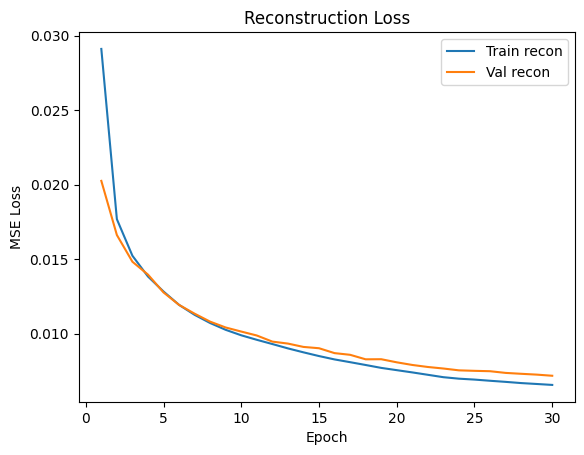

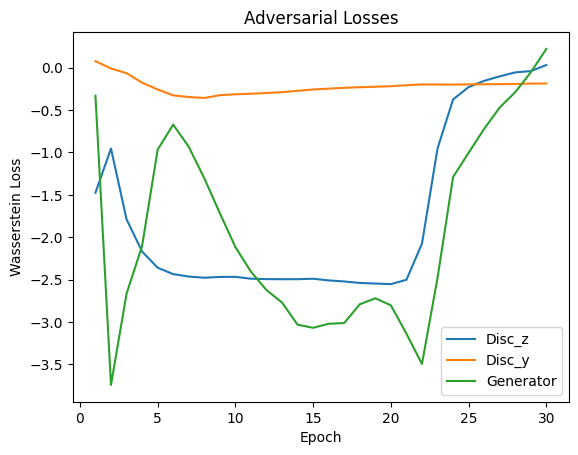

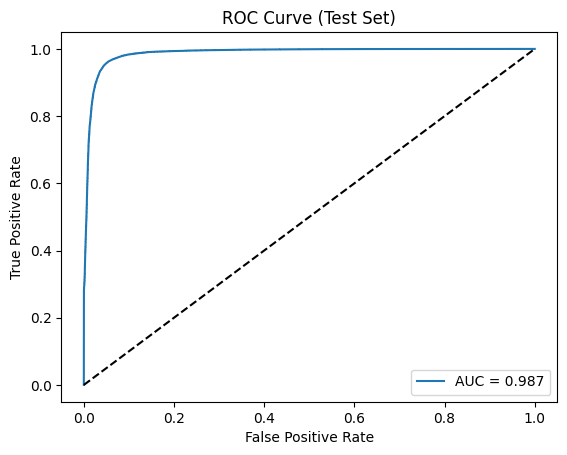

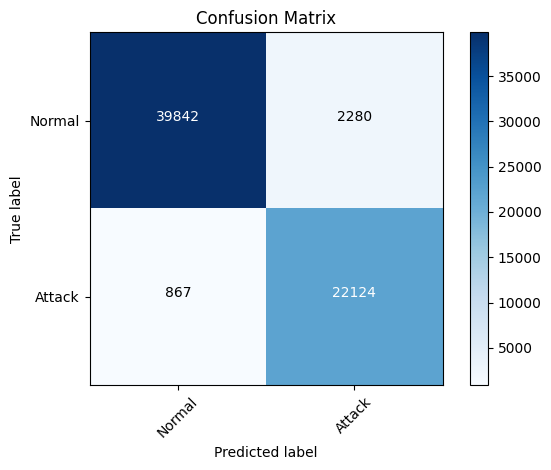

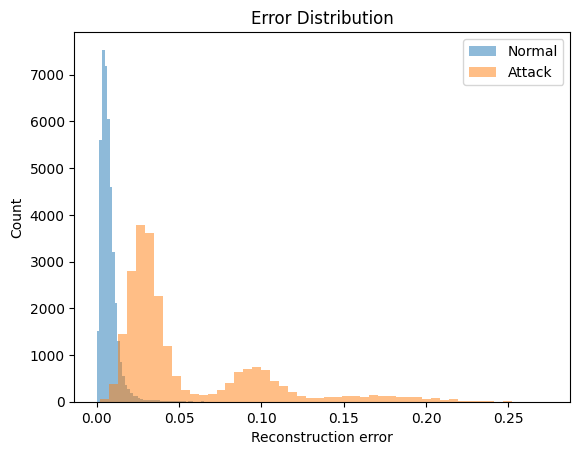

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# Hyperparameters
# ------------------------------------------------------------
FEATURE_DIM = 29 * 29 * 2
N_LABELS   = 2
BATCH      = 128
EPOCHS     = 30

# AAE-specific
N_L1       = 1024
N_L2       = 768
LATENT_DIM = 64
λ_gp       = 10.0

# Learning rates
LR_AE = 0.0005
LR_DZ = 0.0001
LR_DY = 0.0001
LR_G  = 5e-5

# Architecture options
ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'  # 'layer' or 'batch'

# ------------------------------------------------------------
# 1) Helper functions: preprocessing & TFRecord creation
# ------------------------------------------------------------
datasets = ['DoS', 'Fuzzy', 'RPM', 'gear', 'parsed_dataset']
csv_map = {
    'DoS': 'DoS_dataset.csv',
    'Fuzzy': 'Fuzzy_dataset.csv',
    'RPM': 'RPM_dataset.csv',
    'gear': 'gear_dataset.csv',
    'parsed_dataset': 'parsed_dataset.csv'
}

def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid), 16))[2:].zfill(29)
        return np.array(list(map(int, b)), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try:
        return int(str(x).strip(), 16)
    except:
        return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp', 'canID', 'DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag']    = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values

    win = 29
    N   = len(bits_all) // win
    bits   = bits_all[:N * win].reshape(N, win, 29)
    data   = data_bytes[:N * win].reshape(N, win, 8)
    flags  = flags_all[:N * win].reshape(N, win)

    rows = []
    for i in range(N):
        id_img   = bits[i].astype(np.uint8)
        last_b   = data[i, -1, :]
        b8       = np.unpackbits(last_b, axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (29,29), interpolation=cv2.INTER_NEAREST) > 0.5
        two_ch   = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl      = int(flags[i].any())
        rows.append((feat_int, lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7 * len(rows))
    nvl = int(0.15 * len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+ntr+nvl:]} if False else {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph, ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as writer:
            for feat, lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                writer.write(ex.SerializeToString())

# Create/check TFRecords
expected = []
for a in datasets:
    for ph in ('train', 'val', 'test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a != 'parsed_dataset':
            expected.append(f"Normal_{a}_{ph}.tfrecord")
if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src = csv_map[a]
        if not os.path.exists(src):
            print(f"[WARN] {src} not found")
        else:
            rows    = preprocess_windows(src)
            normals = [r for r in rows if r[1] == 0]
            attacks = [r for r in rows if r[1] == 1]
            write_tfrecord(normals, f"Normal_{a}")
            if attacks:
                write_tfrecord(attacks, a)
else:
    print("[DATA] All TFRecords found.")

# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat = tf.io.parse_single_example(proto, {
        'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
        'label':    tf.io.FixedLenFeature([1], tf.int64)
    })
    x = tf.cast(feat['features'], tf.float32)
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x, y: (x + tf.random.normal(tf.shape(x), 0, 0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
total = sum(1 for _ in tf.data.TFRecordDataset(train_files))
steps_per_epoch = total // BATCH
print(f"[PIPE] Total records: {total}, steps/epoch: {steps_per_epoch}")

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        def dense_block(units):
            layers = [tf.keras.layers.Dense(units)]
            if NORM_TYPE == 'layer': layers.append(tf.keras.layers.LayerNormalization())
            elif NORM_TYPE == 'batch': layers.append(tf.keras.layers.BatchNormalization())
            layers.append(tf.keras.layers.Activation(ACTIVATION))
            if DROPOUT > 0: layers.append(tf.keras.layers.Dropout(DROPOUT))
            return tf.keras.Sequential(layers)

        self.e1   = dense_block(N_L1)
        self.e2   = dense_block(N_L2)
        self.ez   = tf.keras.layers.Dense(LATENT_DIM)
        self.ey   = tf.keras.layers.Dense(N_LABELS)

        self.d1   = dense_block(N_L2)
        self.d2   = dense_block(N_L1)
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')

        self.dz1  = dense_block(N_L1)
        self.dz2  = dense_block(N_L2)
        self.dzout= tf.keras.layers.Dense(1)

        self.dy1  = dense_block(N_L1)
        self.dy2  = dense_block(N_L2)
        self.dyout= tf.keras.layers.Dense(1)

    def encode(self, x):
        h      = self.e2(self.e1(x))
        z      = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits

    def decode(self, z, y):
        h = tf.concat([z, y], axis=1)
        h = self.d1(h)
        h = self.d2(h)
        return self.dout(h)

    def discriminate_z(self, z):
        h = self.dz1(z)
        h = self.dz2(h)
        return self.dzout(h)

    def discriminate_y(self, y):
        h = self.dy1(y)
        h = self.dy2(h)
        return self.dyout(h)

    def gradient_penalty(self, f, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1], 0, 1)
        interm = real + alpha * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interm)
            pred = f(interm)
        grads = tape.gradient(pred, interm)
        slopes= tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        return tf.reduce_mean((slopes - 1)**2)

aae = AAE()

# ------------------------------------------------------------
# 4) Losses & Optimizers
# ------------------------------------------------------------
mse    = tf.keras.losses.MeanSquaredError()
ce     = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

# Lists to track losses
train_re_losses = []
val_re_losses   = []
train_dz_losses = []
train_dy_losses = []
train_g_losses  = []

@tf.function
def train_step(xn, xc, y):
    with tf.GradientTape() as t_ae:
        z, yp, logits = aae.encode(xn)
        xr = aae.decode(z, yp)
        loss_re = mse(xc, xr)
    vars_ae = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables + aae.d1.trainable_variables + aae.d2.trainable_variables + aae.dout.trainable_variables
    grads_ae = t_ae.gradient(loss_re, vars_ae)
    opt_ae.apply_gradients(zip(grads_ae, vars_ae))

    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([xn.shape[0], LATENT_DIM])
        dz_r = aae.discriminate_z(z_real)
        dz_f = aae.discriminate_z(z)
        gp   = aae.gradient_penalty(aae.discriminate_z, z_real, z)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp
    vars_dz = aae.dz1.trainable_variables + aae.dz2.trainable_variables + aae.dzout.trainable_variables
    grads_dz = t_dz.gradient(loss_dz, vars_dz)
    opt_dz.apply_gradients(zip(grads_dz, vars_dz))

    with tf.GradientTape() as t_dy:
        dy_r = aae.discriminate_y(y)
        _, yp_enc, _ = aae.encode(xc)
        dy_f = aae.discriminate_y(yp_enc)
        gp_y = aae.gradient_penalty(aae.discriminate_y, y, yp_enc)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    vars_dy = aae.dy1.trainable_variables + aae.dy2.trainable_variables + aae.dyout.trainable_variables
    grads_dy = t_dy.gradient(loss_dy, vars_dy)
    opt_dy.apply_gradients(zip(grads_dy, vars_dy))

    with tf.GradientTape() as t_g:
        z_enc, y_enc, logits_enc = aae.encode(xc)
        loss_g = -tf.reduce_mean(aae.discriminate_z(z_enc))
        loss_g += -tf.reduce_mean(aae.discriminate_y(y_enc))
        loss_g += ce(y, logits_enc)
    vars_g = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables
    grads_g = t_g.gradient(loss_g, vars_g)
    opt_g.apply_gradients(zip(grads_g, vars_g))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 5) Training loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"[TRAIN] Epoch {epoch}/{EPOCHS}")
    epoch_re, epoch_dz, epoch_dy, epoch_g = 0, 0, 0, 0
    it = iter(train_ds)
    for step in range(steps_per_epoch):
        xn, xc, y = next(it)
        lr, ldz, ldy, lg = train_step(xn, xc, y)
        epoch_re  += lr.numpy()
        epoch_dz += ldz.numpy()
        epoch_dy += ldy.numpy()
        epoch_g  += lg.numpy()
        if step % 100 == 0:
            print(f" step {step}/{steps_per_epoch} | recon={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} gen={lg:.4f}")

    # average losses
    train_re_losses.append(epoch_re/steps_per_epoch)
    train_dz_losses.append(epoch_dz/steps_per_epoch)
    train_dy_losses.append(epoch_dy/steps_per_epoch)
    train_g_losses.append(epoch_g/steps_per_epoch)

    # validation recon loss
    val_loss, val_steps = 0, 0
    val_files = glob.glob('Normal_*_val.tfrecord')
    for fn in val_files:
        ds_val = tf.data.TFRecordDataset(fn).map(parse_feat).batch(BATCH)
        for x_val, _ in ds_val:
            _, yp, _ = aae.encode(x_val + tf.random.normal(tf.shape(x_val),0,0.01))
            x_rec = aae.decode(*aae.encode(x_val)[0:2])
            val_loss += tf.reduce_mean(mse(x_val, x_rec)).numpy()
            val_steps += 1
    val_re_losses.append(val_loss/val_steps)
    print(f"[VALID] recon={val_re_losses[-1]:.4f}")

# ------------------------------------------------------------
# 6) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

enc_in = Input(shape=(FEATURE_DIM,))
h = aae.e2(aae.e1(enc_in))
z_enc = aae.ez(h)
y_logits = aae.ey(h)
y_enc = Activation('softmax')(y_logits)
encoder = Model(enc_in, [z_enc, y_enc], name='aae_encoder')

z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2 = aae.d2(aae.d1(Concatenate()([z_in, y_in])))
dec_out = aae.dout(h2)
decoder = Model([z_in, y_in], dec_out, name='aae_decoder')

encoder.save('aae_encoder.keras')
decoder.save('aae_decoder.keras')
print("[SAVE] Encoder & decoder saved")

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    ds_eval = tf.data.TFRecordDataset(fn).map(parse_feat).batch(256)
    for x_batch, _ in ds_eval:
        z_p, y_p = encoder(x_batch)
        x_r = decoder([z_p, y_p])
        e = tf.reduce_mean((x_batch - x_r)**2, axis=1).numpy()
        errs.append(e)
        ys.append(np.full(e.shape, label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr, tpr, ths = roc_curve(ys, errs)
roc_auc = auc(fpr, tpr)
opt_idx = np.argmax(tpr - fpr)
opt_thr = ths[opt_idx]

print(f"[RESULT] ROC AUC: {roc_auc:.4f}, Thr: {opt_thr:.6f}, TPR: {tpr[opt_idx]:.3f}, FPR: {fpr[opt_idx]:.3f}")
print("[RESULT] Confusion Matrix:")
cm = confusion_matrix(ys, (errs > opt_thr).astype(int))
print(cm)
print("[RESULT] Classification Report:")
print(classification_report(ys, (errs > opt_thr).astype(int), target_names=['Normal','Attack']))

# ------------------------------------------------------------
# 8) Plotting
# ------------------------------------------------------------
# Reconstruction loss curves
plt.figure()
plt.plot(range(1, EPOCHS+1), train_re_losses, label='Train recon')
plt.plot(range(1, EPOCHS+1), val_re_losses,   label='Val recon')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.show()

# Adversarial losses
plt.figure()
plt.plot(range(1, EPOCHS+1), train_dz_losses, label='Disc_z')
plt.plot(range(1, EPOCHS+1), train_dy_losses, label='Disc_y')
plt.plot(range(1, EPOCHS+1), train_g_losses,  label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Wasserstein Loss')
plt.title('Adversarial Losses')
plt.legend()
plt.show()

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.show()

# Confusion matrix heatmap
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Normal','Attack']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Error distribution histogram
plt.figure()
plt.hist(errs[ys==0], bins=50, alpha=0.5, label='Normal')
plt.hist(errs[ys==1], bins=50, alpha=0.5, label='Attack')
plt.xlabel('Reconstruction error')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.legend()
plt.show()


[DATA] Creating TFRecords…
[DATA] Processing Attack_free_CHEVROLET_Spark_train.cleaned.csv
[DATA] Processing parsed_dataset.csv
[DATA] Processing Attack_free_HYUNDAI_Sonata_train.cleaned.csv
[DATA] Processing Flooding_CHEVROLET_Spark_train.cleaned.csv
[DATA] Processing Flooding_HYUNDAI_Sonata_train.cleaned.csv
[DATA] Processing Flooding_KIA_Soul_train.cleaned.csv
[DATA] Processing Fuzzy_CHEVROLET_Spark_train.cleaned.csv
[DATA] Processing Fuzzy_HYUNDAI_Sonata_train.cleaned.csv
[DATA] Processing Fuzzy_KIA_Soul_train.cleaned.csv
[DATA] Processing Malfunction_CHEVROLET_Spark_train.cleaned.csv
[DATA] Processing Malfunction_HYUNDAI_Sonata_train.cleaned.csv
[DATA] Processing Malfunction_KIA_Soul_train.cleaned.csv
[DATA] Processing gear_dataset.csv
[DATA] Processing DoS_dataset.csv
[DATA] Processing RPM_dataset.csv
[DATA] Processing Fuzzy_dataset.csv
[PIPE] records=215424, steps/epoch=1683
[BUILD] all layer variables created: 42

[TRAIN] Epoch 1/30
  step 0/1683 | re=0.2517 dz=3.9785 dy=4.6106

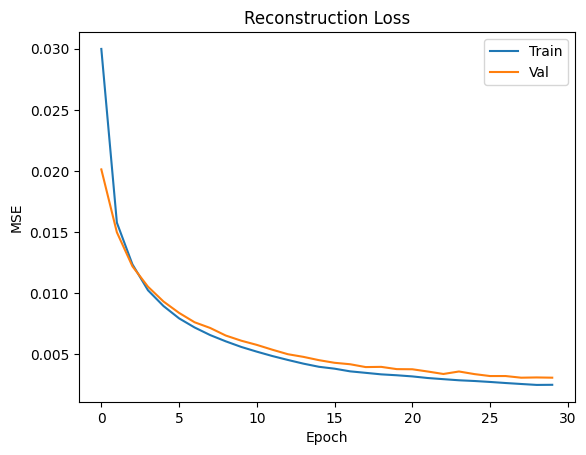

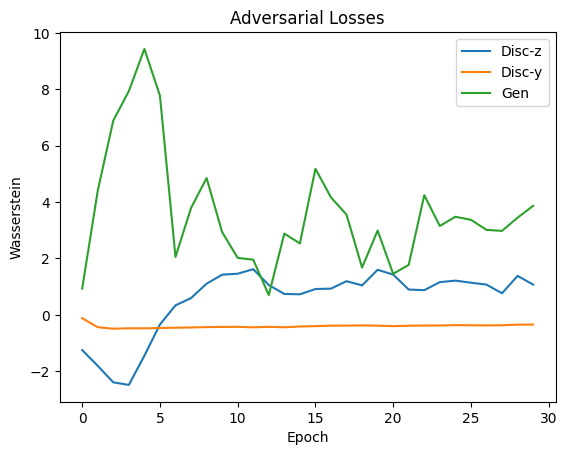

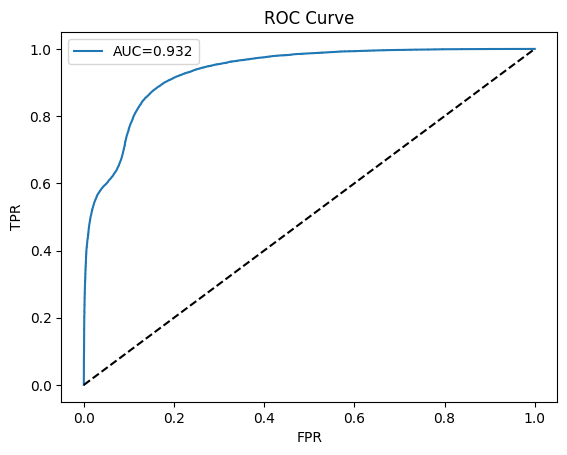

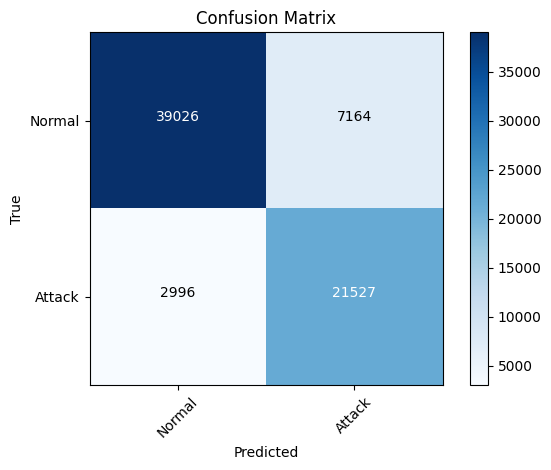

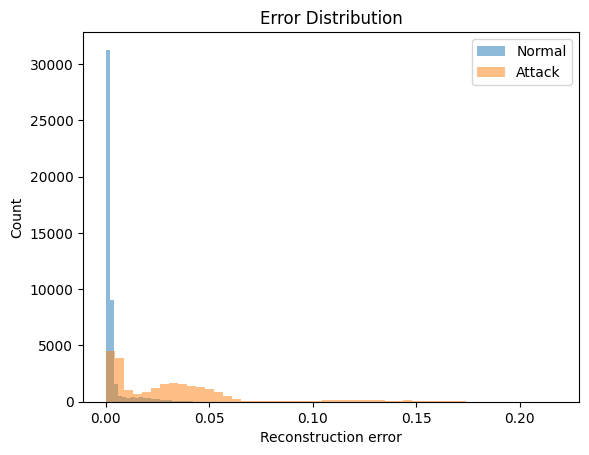

In [ ]:
# ============================================================
# caae_full.py –  Conv-AAE end-to-end pipeline (A→Z)
# ============================================================

import os, glob, itertools, cv2, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# 1) Hyper-parameters
# ------------------------------------------------------------
IMG_SHAPE   = (32, 32, 2)              # <-- תמונת-קלט
FEATURE_DIM = np.prod(IMG_SHAPE)       # 29*29*2
N_LABELS    = 2

BATCH       = 128
EPOCHS      = 30

LATENT_DIM  = 64
λ_gp        = 10.0

LR_AE = 5e-4
LR_DZ = 1e-4
LR_DY = 1e-4
LR_G  = 5e-5

ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'           # layer / batch

# ------------------------------------------------------------
# 2) Pre-processing & TFRecord creation  (ללא שינוי לוגי)
# ------------------------------------------------------------
datasets = [
    'Attack_free_CHEVROLET_Spark_train',
    'parsed_dataset',
    'Attack_free_HYUNDAI_Sonata_train',
    'Attack_free_KIA_Soul_train',
    'Flooding_CHEVROLET_Spark_train',
    'Flooding_HYUNDAI_Sonata_train',
    'Flooding_KIA_Soul_train',
    'Fuzzy_CHEVROLET_Spark_train',
    'Fuzzy_HYUNDAI_Sonata_train',
    'Fuzzy_KIA_Soul_train',
    'Malfunction_CHEVROLET_Spark_train',
    'Malfunction_HYUNDAI_Sonata_train',
    'Malfunction_KIA_Soul_train',
    'Attack_free_HY_Sonata_train',
    'Attack_free_KIA_Soul_train',
    'Fuzzy_dataset_HY_Sonata_train',
    'Fuzzy_dataset_KIA_Soul_train',
    'Malfunction_1st_dataset_HY_Sonata_train',
    'Malfunction_1st_dataset_KIA_Soul_train',
    'Malfunction_2nd_HY_Sonata_train',
    'Malfunction_2nd_KIA_Soul_train',
    'Replay_dataset_HY_Sonata_train',
    'Replay_dataset_KIA_Soul_train',
    'gear_dataset',
    'DoS_dataset',
    'RPM_dataset',
    'Fuzzy_dataset',
]
csv_map = {
    'Attack_free_CHEVROLET_Spark_train':   'Attack_free_CHEVROLET_Spark_train.cleaned.csv',
    'Attack_free_HYUNDAI_Sonata_train':    'Attack_free_HYUNDAI_Sonata_train.cleaned.csv',
    'Attack_free_KIA_Soul_train':          'Attack_free_KIA_Soul_train.cleaned.csv',
    'Flooding_CHEVROLET_Spark_train':      'Flooding_CHEVROLET_Spark_train.cleaned.csv',
    'Flooding_HYUNDAI_Sonata_train':       'Flooding_HYUNDAI_Sonata_train.cleaned.csv',
    'Flooding_KIA_Soul_train':             'Flooding_KIA_Soul_train.cleaned.csv',
    'Fuzzy_CHEVROLET_Spark_train':         'Fuzzy_CHEVROLET_Spark_train.cleaned.csv',
    'Fuzzy_HYUNDAI_Sonata_train':          'Fuzzy_HYUNDAI_Sonata_train.cleaned.csv',
    'Fuzzy_KIA_Soul_train':                'Fuzzy_KIA_Soul_train.cleaned.csv',
    'Malfunction_CHEVROLET_Spark_train':   'Malfunction_CHEVROLET_Spark_train.cleaned.csv',
    'Malfunction_HYUNDAI_Sonata_train':    'Malfunction_HYUNDAI_Sonata_train.cleaned.csv',
    'Malfunction_KIA_Soul_train':          'Malfunction_KIA_Soul_train.cleaned.csv',
    'Attack_free_HY_Sonata_train':              'Attack_free_HY_Sonata_train.cleaned_Final.csv',
    'Attack_free_KIA_Soul_train':               'Attack_free_KIA_Soul_train.cleaned_Final.csv',
    'Fuzzy_dataset_HY_Sonata_train':            'Fuzzy_dataset_HY_Sonata_train.cleaned_Final.csv',
    'Fuzzy_dataset_KIA_Soul_train':             'Fuzzy_dataset_KIA_Soul_train.cleaned_Final.csv',
    'Malfunction_1st_dataset_HY_Sonata_train':  'Malfunction_1st_dataset_HY_Sonata_train.cleaned_Final.csv',
    'Malfunction_1st_dataset_KIA_Soul_train':   'Malfunction_1st_dataset_KIA_Soul_train.cleaned_Final.csv',
    'Malfunction_2nd_HY_Sonata_train':          'Malfunction_2nd_HY_Sonata_train.cleaned_Final.csv',
    'Malfunction_2nd_KIA_Soul_train':           'Malfunction_2nd_KIA_Soul_train.cleaned_Final.csv',
    'Replay_dataset_HY_Sonata_train':           'Replay_dataset_HY_Sonata_train.cleaned_Final.csv',
    'Replay_dataset_KIA_Soul_train':            'Replay_dataset_KIA_Soul_train.cleaned_Final.csv',
    'parsed_dataset':                           'parsed_dataset.csv',
    'gear_dataset':                             'gear_dataset.csv',
    'DoS_dataset':                              'DoS_dataset.csv',
    'RPM_dataset':                              'RPM_dataset.csv',
    'Fuzzy_dataset':                            'Fuzzy_dataset.csv',
}



def fill_flag(row):
    if not isinstance(row['Label'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Label'])
    return row

def convert_canid_bits(cid):
    try:
        return np.array(list(map(int, bin(int(str(cid),16))[2:].zfill(29))), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try: return int(str(x).strip(), 16)
    except: return 0

# Replace the preprocess_windows function with this fixed version:
def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    cols = ['Timestamp','canID','DLC']+[f'Data{i}' for i in range(8)] + ['Label']
    df   = pd.read_csv(csv_file, header=None, names=cols, low_memory=False)

    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp','canID']).apply(fill_flag, axis=1)

    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)

    df['Label']    = df['Label'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Label'].values

    win = 29
    N   = len(bits_all)//win
    bits   = bits_all[:N*win].reshape(N, win, 29)
    data   = data_bytes[:N*win].reshape(N, win, 8)
    flags  = flags_all[:N*win].reshape(N, win)

    rows = []
    for i in range(N):
        id_block = bits[i]
        id_img   = cv2.resize(id_block.astype(np.uint8), (32, 32),
                              interpolation=cv2.INTER_NEAREST)

        last_b = data[i,-1,:]
        b8     = np.unpackbits(last_b).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (32, 32),
                              interpolation=cv2.INTER_NEAREST) > .5

        two_ch = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)  # 32x32x2
        rows.append((two_ch.flatten().tolist(), int(flags[i].any())))
    return rows


def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(.7*len(rows)); nvl = int(.15*len(rows))
    splits = {'train':rows[:ntr], 'val':rows[ntr:ntr+nvl], 'test':rows[ntr+nvl:]}
    for phase, chunk in splits.items():
        with tf.io.TFRecordWriter(f"{base}_{phase}.tfrecord") as w:
            for feat,lbl in chunk:
                ex = tf.train.Example(
                     features=tf.train.Features(feature={
                     'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                     'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))}))
                w.write(ex.SerializeToString())

# צור TFRecords אם חסרים

print("[DATA] Creating TFRecords…")
for d in datasets:
    if not os.path.exists(csv_map[d]): continue
    rows = preprocess_windows(csv_map[d])
    normals = [r for r in rows if r[1]==0]
    attacks = [r for r in rows if r[1]==1]
    write_tfrecord(normals, f"Normal_{d}")
    if attacks: write_tfrecord(attacks, d)

# ------------------------------------------------------------
# 3) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    fs = {'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
          'label':    tf.io.FixedLenFeature([1], tf.int64)}
    feat = tf.io.parse_single_example(proto, fs)
    x = tf.cast(feat['features'], tf.float32)
    x = tf.reshape(x, IMG_SHAPE)              # <-- תמונה
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x,y: (x + tf.random.normal(tf.shape(x),0,0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
steps_per_epoch = sum(1 for _ in tf.data.TFRecordDataset(train_files)) // BATCH
print(f"[PIPE] records={steps_per_epoch*BATCH}, steps/epoch={steps_per_epoch}")

# ------------------------------------------------------------
# 4) CAAE Model
# ------------------------------------------------------------
def dense_block(units):
    layers = [tf.keras.layers.Dense(units)]
    if NORM_TYPE=='layer': layers.append(tf.keras.layers.LayerNormalization())
    elif NORM_TYPE=='batch': layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Activation(ACTIVATION))
    if DROPOUT>0: layers.append(tf.keras.layers.Dropout(DROPOUT))
    return tf.keras.Sequential(layers)

class ConvAAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # ---- encoder
        self.enc_c1  = tf.keras.layers.Conv2D(32,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.enc_c2  = tf.keras.layers.Conv2D(64,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.enc_flat= tf.keras.layers.Flatten()
        self.enc_fc  = dense_block(256)
        self.z_layer = tf.keras.layers.Dense(LATENT_DIM)
        self.y_logits= tf.keras.layers.Dense(N_LABELS)

        # ---- decoder
        self.dec_fc   = dense_block(8*8*64)
        self.dec_reshape = tf.keras.layers.Reshape((8,8,64))
        self.dec_t1  = tf.keras.layers.Conv2DTranspose(64,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.dec_t2  = tf.keras.layers.Conv2DTranspose(32,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.dec_out = tf.keras.layers.Conv2DTranspose(2,(3,3),padding='same',activation='sigmoid')

        # ---- discriminators (z , y)
        self.dz = tf.keras.Sequential([dense_block(256),
                                       dense_block(128),
                                       tf.keras.layers.Dense(1)])
        self.dy = tf.keras.Sequential([dense_block(256),
                                       dense_block(128),
                                       tf.keras.layers.Dense(1)])

    # ---------- forward passes ----------
    def encode(self, x):
        h = self.enc_c2(self.enc_c1(x))
        h = self.enc_fc(self.enc_flat(h))
        z = self.z_layer(h)
        logits = self.y_logits(h)
        y = tf.nn.softmax(logits)
        return z, y, logits

    def decode(self, z, y):
        h = tf.concat([z,y], axis=1)
        h = self.dec_fc(h)
        h = self.dec_reshape(h)
        h = self.dec_t2(self.dec_t1(h))
        return self.dec_out(h)

    def discriminate_z(self, z): return self.dz(z)
    def discriminate_y(self, y): return self.dy(y)

    @staticmethod
    def gp(f, real, fake):
        α = tf.random.uniform([real.shape[0],1],0,1)
        inter = real + α*(fake-real)
        with tf.GradientTape() as t:
            t.watch(inter); p=f(inter)
        g = t.gradient(p, inter)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(g), axis=1)+1e-8)
        return tf.reduce_mean((slopes-1.)**2)

caae = ConvAAE()

# ------------------------------------------------------------
# 4.5) Warm-up: לבנות את כל המשתנים לפני האופטימיזרים
# ------------------------------------------------------------
dummy_x = tf.zeros((1,) + IMG_SHAPE, dtype=tf.float32)
z0, y0, _ = caae.encode(dummy_x)
_ = caae.decode(z0, y0)
_ = caae.discriminate_z(tf.random.normal((1, LATENT_DIM)))
_ = caae.discriminate_y(tf.one_hot([0], depth=N_LABELS))
print("[BUILD] all layer variables created:", len(caae.trainable_variables))

# ------------------------------------------------------------
# 5) Losses & optimizers  (עם רשימות קבועות)
# ------------------------------------------------------------
ae_vars = (
    caae.enc_c1.trainable_variables + caae.enc_c2.trainable_variables +
    caae.enc_fc.trainable_variables + caae.z_layer.trainable_variables +
    caae.y_logits.trainable_variables +
    caae.dec_fc.trainable_variables + caae.dec_reshape.trainable_variables +
    caae.dec_t1.trainable_variables + caae.dec_t2.trainable_variables +
    caae.dec_out.trainable_variables
)
dz_vars = caae.dz.trainable_variables
dy_vars = caae.dy.trainable_variables
enc_vars = (
    caae.enc_c1.trainable_variables + caae.enc_c2.trainable_variables +
    caae.enc_fc.trainable_variables + caae.z_layer.trainable_variables +
    caae.y_logits.trainable_variables
)

mse  = tf.keras.losses.MeanSquaredError()
ce   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

# ------------------------------------------------------------
# 6) Training step (tf.function)
# ------------------------------------------------------------
@tf.function
def train_step(x_noisy, x_clean, y_lbl):
    # ---------- auto-encoder ----------
    with tf.GradientTape() as t_ae:
        z_enc, y_enc, _ = caae.encode(x_noisy)
        x_rec = caae.decode(z_enc, y_enc)
        loss_re = mse(x_clean, x_rec)
    grads = t_ae.gradient(loss_re, ae_vars)
    opt_ae.apply_gradients(zip(grads, ae_vars))

    # ---------- discriminator-z ----------
    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([tf.shape(x_noisy)[0], LATENT_DIM])
        dz_r   = caae.discriminate_z(z_real)
        dz_f   = caae.discriminate_z(z_enc)
        gp_z   = caae.gp(caae.discriminate_z, z_real, z_enc)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp_z
    opt_dz.apply_gradients(zip(t_dz.gradient(loss_dz, dz_vars), dz_vars))

    # ---------- discriminator-y ----------
    with tf.GradientTape() as t_dy:
        dy_r = caae.discriminate_y(y_lbl)
        _, y_enc2, _ = caae.encode(x_clean)
        dy_f = caae.discriminate_y(y_enc2)
        gp_y = caae.gp(caae.discriminate_y, y_lbl, y_enc2)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    opt_dy.apply_gradients(zip(t_dy.gradient(loss_dy, dy_vars), dy_vars))

    # ---------- generator / encoder adversarial ----------
    with tf.GradientTape() as t_g:
        z_g, y_g, logits = caae.encode(x_clean)
        loss_g = (
            -tf.reduce_mean(caae.discriminate_z(z_g))
            -tf.reduce_mean(caae.discriminate_y(y_g))
            + ce(y_lbl, logits)
        )
    opt_g.apply_gradients(zip(t_g.gradient(loss_g, enc_vars), enc_vars))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 7) Training loop
# ------------------------------------------------------------
re_hist, dz_hist, dy_hist, g_hist, val_hist = [],[],[],[],[]

for epoch in range(1, EPOCHS+1):
    print(f"\n[TRAIN] Epoch {epoch}/{EPOCHS}")
    ep_re=ep_dz=ep_dy=ep_g=0
    for step,(xn, xc, y) in enumerate(train_ds.take(steps_per_epoch)):
        lr,ldz,ldy,lg = train_step(xn, xc, y)
        ep_re+=lr.numpy(); ep_dz+=ldz.numpy(); ep_dy+=ldy.numpy(); ep_g+=lg.numpy()
        if step%100==0:
            print(f"  step {step}/{steps_per_epoch} | re={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} g={lg:.4f}")
    re_hist.append(ep_re/steps_per_epoch)
    dz_hist.append(ep_dz/steps_per_epoch)
    dy_hist.append(ep_dy/steps_per_epoch)
    g_hist .append(ep_g /steps_per_epoch)

    # -------- validation recon ----------
    val_loss, n_batches = 0,0
    for fn in glob.glob('Normal_*_val.tfrecord'):
        for x_val,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(BATCH):
            x_rec = caae.decode(*caae.encode(x_val)[0:2])
            val_loss += mse(x_val, x_rec).numpy()
            n_batches += 1
    val_hist.append(val_loss/n_batches)
    print(f"[VAL] recon={val_hist[-1]:.4f}")

# ------------------------------------------------------------
# 8) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

# --- Encoder
enc_in = Input(shape=IMG_SHAPE)
h = caae.enc_c2(caae.enc_c1(enc_in))
h = caae.enc_fc(caae.enc_flat(h))
z_out = caae.z_layer(h)
y_log = caae.y_logits(h)
y_out = Activation('softmax')(y_log)
encoder = Model(enc_in, [z_out,y_out], name='caae_encoder')

# --- Decoder
z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2   = caae.dec_fc(Concatenate()([z_in,y_in]))
h2   = caae.dec_reshape(h2)
h2   = caae.dec_t2(caae.dec_t1(h2))
dec_out = caae.dec_out(h2)
decoder = Model([z_in,y_in], dec_out, name='caae_decoder')

encoder.save('caae_encoder.keras')
decoder.save('caae_decoder.keras')
print("[SAVE] models stored")

# ------------------------------------------------------------
# 9) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    for x_batch,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(256):
        z_p,y_p = encoder(x_batch)
        x_r = decoder([z_p,y_p])
        e = tf.reduce_mean(tf.square(x_batch - x_r), axis=[1,2,3]).numpy()
        errs.append(e); ys.append(np.full(e.shape,label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr,tpr,ths = roc_curve(ys, errs)
roc_auc     = auc(fpr,tpr)
best_idx    = np.argmax(tpr-fpr)
thr_opt     = ths[best_idx]

print(f"\n[RESULT] ROC-AUC={roc_auc:.4f} | Thr={thr_opt:.6f} | "
      f"TPR={tpr[best_idx]:.3f} | FPR={fpr[best_idx]:.3f}")
cm = confusion_matrix(ys, (errs>thr_opt).astype(int))
print("[CM]\n", cm)
print("[Report]\n", classification_report(ys,(errs>thr_opt).astype(int),
                                          target_names=['Normal','Attack']))

# ------------------------------------------------------------
# 10) Plotting
# ------------------------------------------------------------
# -- Reconstruction loss curves
plt.figure(); plt.plot(re_hist,label='Train'); plt.plot(val_hist,label='Val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Reconstruction Loss'); plt.legend(); plt.show()

# -- Adversarial losses
plt.figure(); plt.plot(dz_hist,label='Disc-z'); plt.plot(dy_hist,label='Disc-y'); plt.plot(g_hist,label='Gen')
plt.xlabel('Epoch'); plt.ylabel('Wasserstein'); plt.title('Adversarial Losses'); plt.legend(); plt.show()

# -- ROC curve
plt.figure(); plt.plot(fpr,tpr,label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# -- Confusion-matrix heat-map
plt.figure(); plt.imshow(cm,cmap=plt.cm.Blues); plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(2); classes=['Normal','Attack']
plt.xticks(ticks,classes,rotation=45); plt.yticks(ticks,classes)
th = cm.max()/2
for i,j in itertools.product(range(2),range(2)):
    plt.text(j,i,cm[i,j],ha='center',color='white' if cm[i,j]>th else 'black')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

# -- Error distributions
plt.figure()
plt.hist(errs[ys==0],bins=50,alpha=.5,label='Normal')
plt.hist(errs[ys==1],bins=50,alpha=.5,label='Attack')
plt.xlabel('Reconstruction error'); plt.ylabel('Count')
plt.title('Error Distribution'); plt.legend(); plt.show()


In [ ]:
import pandas as pd
from pathlib import Path
import logging

from pathlib import Path
import logging
import pandas as pd

def clean_and_save_csv(csv_file: str) -> str:
    """
    מנקה קובץ CSV: מסיר עמודת אינדקס, מפצל ומרפד את עמודת ה-Data, ושומר מחדש.
    Label תמיד תופיע אחרי DATA[7].

    Args:
        csv_file (str): הנתיב לקובץ המקורי.

    Returns:
        str: הנתיב לקובץ החדש שנשמר.
    """
    # קריאה עם עמודה אחת ל־Data

    cols = ['Timestamp', 'CAN ID', 'DLC', 'Data', 'Label']
    df = pd.read_csv(csv_file, header=None, names=cols, low_memory=False)

    # הסרת עמודת index

    # המרות בסיסיות
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC'] = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'CAN ID'])

    # ניקוי ערכי Data
    def process_data_field(raw):
        if pd.isna(raw): return ['00'] * 8
        raw = str(raw).replace(" ", "")  # הסרת רווחים
        bytes_list = [raw[i:i+2] for i in range(0, len(raw), 2)]
        while len(bytes_list) < 8:
            bytes_list.append("00")
        return bytes_list[:8]

    # החלת הפיצול והפירוק
    processed_data = df['Data'].apply(process_data_field)
    data_df = pd.DataFrame(processed_data.tolist(), columns=[f'DATA[{i}]' for i in range(8)])
    df.drop(columns=['Data'], inplace=True)

    # עדכון DLC ל-8 אם היה פחות
    df['DLC'] = 8

    # בניית הסדר הנכון מחדש
    final_df = pd.concat([df[['Timestamp', 'CAN ID', 'DLC']].reset_index(drop=True),
                          data_df.reset_index(drop=True),
                          df[['Label']].reset_index(drop=True)], axis=1)

    # שמירה
    out_file = Path(csv_file).with_suffix('.cleaned.csv')
    final_df.to_csv(out_file, index=False)
    logging.info(f"[CLEAN] Saved cleaned file: {out_file}")
    return str(out_file)

# רשימת שמות הקבצים מתוך התמונה
csv_files = [
    "Attack_free_CHEVROLET_Spark_train.csv",
    "Attack_free_HYUNDAI_Sonata_train.csv",
    "Attack_free_KIA_Soul_train.csv",
    "Flooding_CHEVROLET_Spark_train.csv",
    "Flooding_HYUNDAI_Sonata_train.csv",
    "Flooding_KIA_Soul_train.csv",
    "Fuzzy_CHEVROLET_Spark_train.csv",
    'Attack_free_HY_Sonata_train.csv',
    'Attack_free_KIA_Soul_train.csv',
    'Fuzzy_dataset_HY_Sonata_train.csv',
    'Fuzzy_dataset_KIA_Soul_train.csv',
    'Malfunction_1st_dataset_HY_Sonata_train.csv',
    'Malfunction_1st_dataset_KIA_Soul_train.csv',
    'Malfunction_2nd_HY_Sonata_train.csv',
    'Malfunction_2nd_KIA_Soul_train.csv',
    'Replay_dataset_HY_Sonata_train.csv',
    'Replay_dataset_KIA_Soul_train.csv'
]


# נתיב לתיקייה המכילה את הקבצים

# הפעלת הפונקציה על כל קובץ
for fname in csv_files:
    try:
        cleaned_path = clean_and_save_csv(str(fname))
        print(f"[✓] Cleaned: {cleaned_path}")
    except Exception as e:
        print(f"[✗] Failed: {fname} — {e}")


[✓] Cleaned: Attack_free_CHEVROLET_Spark_train.cleaned.csv
[✗] Failed: Attack_free_HYUNDAI_Sonata_train.csv — [Errno 2] No such file or directory: 'Attack_free_HYUNDAI_Sonata_train.csv'
[✓] Cleaned: Attack_free_KIA_Soul_train.cleaned.csv
[✓] Cleaned: Flooding_CHEVROLET_Spark_train.cleaned.csv
[✓] Cleaned: Flooding_HYUNDAI_Sonata_train.cleaned.csv
[✓] Cleaned: Flooding_KIA_Soul_train.cleaned.csv
[✓] Cleaned: Fuzzy_CHEVROLET_Spark_train.cleaned.csv
[✓] Cleaned: Attack_free_HY_Sonata_train.cleaned.csv
[✓] Cleaned: Attack_free_KIA_Soul_train.cleaned.csv
[✓] Cleaned: Fuzzy_dataset_HY_Sonata_train.cleaned.csv
[✓] Cleaned: Fuzzy_dataset_KIA_Soul_train.cleaned.csv
[✓] Cleaned: Malfunction_1st_dataset_HY_Sonata_train.cleaned.csv
[✓] Cleaned: Malfunction_1st_dataset_KIA_Soul_train.cleaned.csv
[✓] Cleaned: Malfunction_2nd_HY_Sonata_train.cleaned.csv
[✓] Cleaned: Malfunction_2nd_KIA_Soul_train.cleaned.csv
[✓] Cleaned: Replay_dataset_HY_Sonata_train.cleaned.csv
[✓] Cleaned: Replay_dataset_KIA_Soul_

[DATA] Creating TFRecords…
[DATA] Processing Attack_free_CHEVROLET_Spark_train.cleaned.csv
[DATA] Processing Attack_free_KIA_Soul_train.cleaned.csv
[DATA] Processing Flooding_CHEVROLET_Spark_train.cleaned.csv
[DATA] Processing Flooding_HYUNDAI_Sonata_train.cleaned.csv
[DATA] Processing Flooding_KIA_Soul_train.cleaned.csv
[DATA] Processing Fuzzy_CHEVROLET_Spark_train.cleaned.csv
[DATA] Processing Attack_free_HY_Sonata_train.cleaned.csv
[DATA] Processing Attack_free_KIA_Soul_train.cleaned.csv
[DATA] Processing Fuzzy_dataset_HY_Sonata_train.cleaned.csv
[DATA] Processing Fuzzy_dataset_KIA_Soul_train.cleaned.csv
[DATA] Processing Malfunction_1st_dataset_HY_Sonata_train.cleaned.csv
[DATA] Processing Malfunction_1st_dataset_KIA_Soul_train.cleaned.csv
[DATA] Processing Malfunction_2nd_HY_Sonata_train.cleaned.csv
[DATA] Processing Malfunction_2nd_KIA_Soul_train.cleaned.csv
[DATA] Processing Replay_dataset_HY_Sonata_train.cleaned.csv
[DATA] Processing Replay_dataset_KIA_Soul_train.cleaned.csv
[P

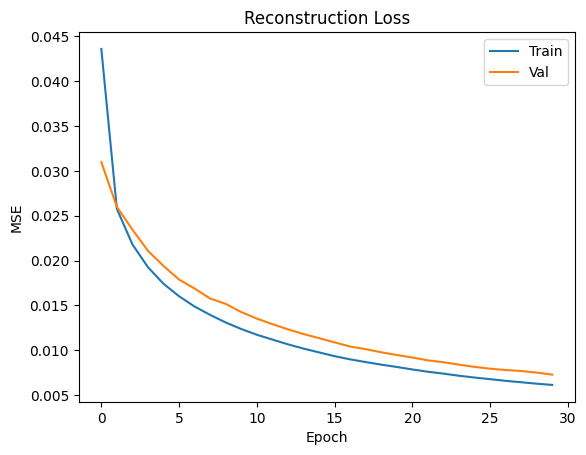

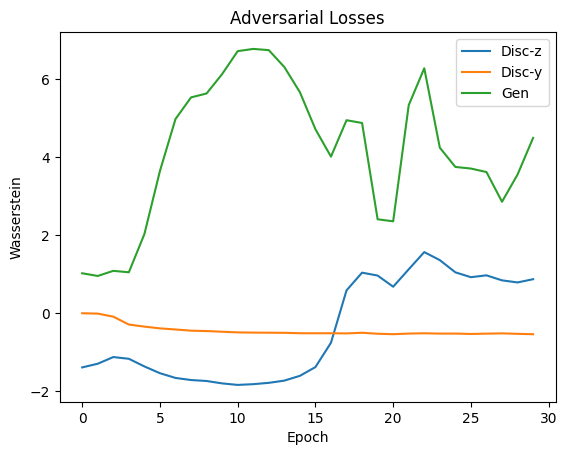

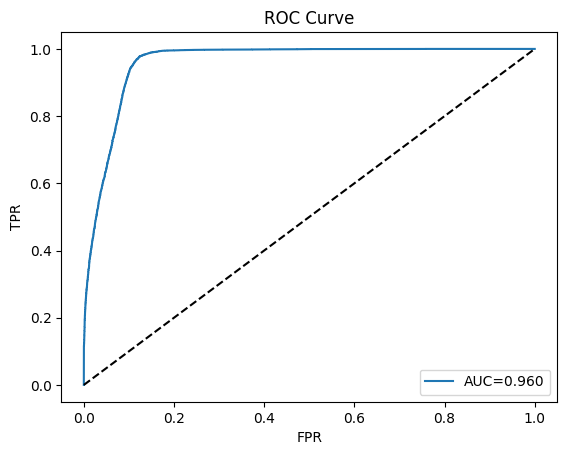

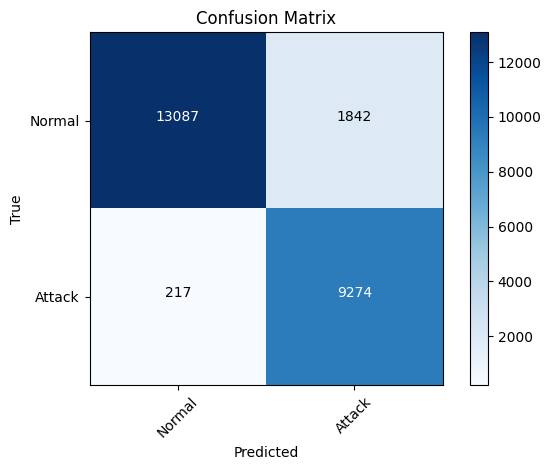

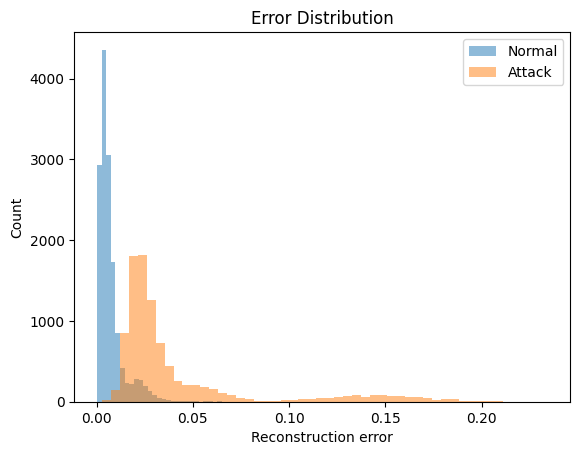

In [ ]:
# ============================================================
# caae_full.py –  Conv-AAE end-to-end pipeline (A→Z)
# ============================================================

import os, glob, itertools, cv2, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# 1) Hyper-parameters
# ------------------------------------------------------------
IMG_SHAPE   = (32, 32, 2)              # <-- תמונת-קלט
FEATURE_DIM = np.prod(IMG_SHAPE)       # 29*29*2
N_LABELS    = 2

BATCH       = 128
EPOCHS      = 30

LATENT_DIM  = 64
λ_gp        = 10.0

LR_AE = 5e-4
LR_DZ = 1e-4
LR_DY = 1e-4
LR_G  = 5e-5

ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'           # layer / batch

# ------------------------------------------------------------
# 2) Pre-processing & TFRecord creation  (ללא שינוי לוגי)
# ------------------------------------------------------------
datasets = [
    'Attack_free_CHEVROLET_Spark_train',
    'Attack_free_KIA_Soul_train',
    'Flooding_CHEVROLET_Spark_train',
    'Flooding_HYUNDAI_Sonata_train',
    'Flooding_KIA_Soul_train',
    'Fuzzy_CHEVROLET_Spark_train',
    'Attack_free_HY_Sonata_train',
    'Attack_free_KIA_Soul_train',
    'Fuzzy_dataset_HY_Sonata_train',
    'Fuzzy_dataset_KIA_Soul_train',
    'Malfunction_1st_dataset_HY_Sonata_train',
    'Malfunction_1st_dataset_KIA_Soul_train',
    'Malfunction_2nd_HY_Sonata_train',
    'Malfunction_2nd_KIA_Soul_train',
    'Replay_dataset_HY_Sonata_train',
    'Replay_dataset_KIA_Soul_train'
]
csv_map = {
    'Attack_free_CHEVROLET_Spark_train':   'Attack_free_CHEVROLET_Spark_train.cleaned.csv',
    'Attack_free_KIA_Soul_train':          'Attack_free_KIA_Soul_train.cleaned.csv',
    'Flooding_CHEVROLET_Spark_train':      'Flooding_CHEVROLET_Spark_train.cleaned.csv',
    'Flooding_HYUNDAI_Sonata_train':       'Flooding_HYUNDAI_Sonata_train.cleaned.csv',
    'Flooding_KIA_Soul_train':             'Flooding_KIA_Soul_train.cleaned.csv',
    'Fuzzy_CHEVROLET_Spark_train':         'Fuzzy_CHEVROLET_Spark_train.cleaned.csv',
    'Attack_free_HY_Sonata_train':         'Attack_free_HY_Sonata_train.cleaned.csv',
    'Attack_free_KIA_Soul_train':          'Attack_free_KIA_Soul_train.cleaned.csv',
    'Fuzzy_dataset_HY_Sonata_train':       'Fuzzy_dataset_HY_Sonata_train.cleaned.csv',
    'Fuzzy_dataset_KIA_Soul_train':        'Fuzzy_dataset_KIA_Soul_train.cleaned.csv',
    'Malfunction_1st_dataset_HY_Sonata_train':  'Malfunction_1st_dataset_HY_Sonata_train.cleaned.csv',
    'Malfunction_1st_dataset_KIA_Soul_train':   'Malfunction_1st_dataset_KIA_Soul_train.cleaned.csv',
    'Malfunction_2nd_HY_Sonata_train':          'Malfunction_2nd_HY_Sonata_train.cleaned.csv',
    'Malfunction_2nd_KIA_Soul_train':           'Malfunction_2nd_KIA_Soul_train.cleaned.csv',
    'Replay_dataset_HY_Sonata_train':           'Replay_dataset_HY_Sonata_train.cleaned.csv',
    'Replay_dataset_KIA_Soul_train':            'Replay_dataset_KIA_Soul_train.cleaned.csv'
}


def fill_flag(row):
    if not isinstance(row['Label'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Label'])
    return row

def convert_canid_bits(cid):
    try:
        return np.array(list(map(int, bin(int(str(cid),16))[2:].zfill(29))), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try: return int(str(x).strip(), 16)
    except: return 0

# Replace the preprocess_windows function with this fixed version:
def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    cols = ['Timestamp','canID','DLC']+[f'Data{i}' for i in range(8)] + ['Label']
    df   = pd.read_csv(csv_file, header=None, names=cols, low_memory=False)

    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp','canID']).apply(fill_flag, axis=1)

    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)

    df['Label']    = df['Label'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Label'].values

    win = 29
    N   = len(bits_all)//win
    bits   = bits_all[:N*win].reshape(N, win, 29)
    data   = data_bytes[:N*win].reshape(N, win, 8)
    flags  = flags_all[:N*win].reshape(N, win)

    rows = []
    for i in range(N):
        id_block = bits[i]
        id_img   = cv2.resize(id_block.astype(np.uint8), (32, 32),
                              interpolation=cv2.INTER_NEAREST)

        last_b = data[i,-1,:]
        b8     = np.unpackbits(last_b).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (32, 32),
                              interpolation=cv2.INTER_NEAREST) > .5

        two_ch = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)  # 32x32x2
        rows.append((two_ch.flatten().tolist(), int(flags[i].any())))
    return rows


def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(.7*len(rows)); nvl = int(.15*len(rows))
    splits = {'train':rows[:ntr], 'val':rows[ntr:ntr+nvl], 'test':rows[ntr+nvl:]}
    for phase, chunk in splits.items():
        with tf.io.TFRecordWriter(f"{base}_{phase}.tfrecord") as w:
            for feat,lbl in chunk:
                ex = tf.train.Example(
                     features=tf.train.Features(feature={
                     'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                     'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))}))
                w.write(ex.SerializeToString())

# צור TFRecords אם חסרים

print("[DATA] Creating TFRecords…")
for d in datasets:
    if not os.path.exists(csv_map[d]): continue
    rows = preprocess_windows(csv_map[d])
    normals = [r for r in rows if r[1]==0]
    attacks = [r for r in rows if r[1]==1]
    write_tfrecord(normals, f"Normal_{d}")
    if attacks: write_tfrecord(attacks, d)

# ------------------------------------------------------------
# 3) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    fs = {'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
          'label':    tf.io.FixedLenFeature([1], tf.int64)}
    feat = tf.io.parse_single_example(proto, fs)
    x = tf.cast(feat['features'], tf.float32)
    x = tf.reshape(x, IMG_SHAPE)              # <-- תמונה
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x,y: (x + tf.random.normal(tf.shape(x),0,0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
steps_per_epoch = sum(1 for _ in tf.data.TFRecordDataset(train_files)) // BATCH
print(f"[PIPE] records={steps_per_epoch*BATCH}, steps/epoch={steps_per_epoch}")

# ------------------------------------------------------------
# 4) CAAE Model
# ------------------------------------------------------------
def dense_block(units):
    layers = [tf.keras.layers.Dense(units)]
    if NORM_TYPE=='layer': layers.append(tf.keras.layers.LayerNormalization())
    elif NORM_TYPE=='batch': layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Activation(ACTIVATION))
    if DROPOUT>0: layers.append(tf.keras.layers.Dropout(DROPOUT))
    return tf.keras.Sequential(layers)

class ConvAAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # ---- encoder
        self.enc_c1  = tf.keras.layers.Conv2D(32,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.enc_c2  = tf.keras.layers.Conv2D(64,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.enc_flat= tf.keras.layers.Flatten()
        self.enc_fc  = dense_block(256)
        self.z_layer = tf.keras.layers.Dense(LATENT_DIM)
        self.y_logits= tf.keras.layers.Dense(N_LABELS)

        # ---- decoder
        self.dec_fc   = dense_block(8*8*64)
        self.dec_reshape = tf.keras.layers.Reshape((8,8,64))
        self.dec_t1  = tf.keras.layers.Conv2DTranspose(64,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.dec_t2  = tf.keras.layers.Conv2DTranspose(32,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.dec_out = tf.keras.layers.Conv2DTranspose(2,(3,3),padding='same',activation='sigmoid')

        # ---- discriminators (z , y)
        self.dz = tf.keras.Sequential([dense_block(256),
                                       dense_block(128),
                                       tf.keras.layers.Dense(1)])
        self.dy = tf.keras.Sequential([dense_block(256),
                                       dense_block(128),
                                       tf.keras.layers.Dense(1)])

    # ---------- forward passes ----------
    def encode(self, x):
        h = self.enc_c2(self.enc_c1(x))
        h = self.enc_fc(self.enc_flat(h))
        z = self.z_layer(h)
        logits = self.y_logits(h)
        y = tf.nn.softmax(logits)
        return z, y, logits

    def decode(self, z, y):
        h = tf.concat([z,y], axis=1)
        h = self.dec_fc(h)
        h = self.dec_reshape(h)
        h = self.dec_t2(self.dec_t1(h))
        return self.dec_out(h)

    def discriminate_z(self, z): return self.dz(z)
    def discriminate_y(self, y): return self.dy(y)

    @staticmethod
    def gp(f, real, fake):
        α = tf.random.uniform([real.shape[0],1],0,1)
        inter = real + α*(fake-real)
        with tf.GradientTape() as t:
            t.watch(inter); p=f(inter)
        g = t.gradient(p, inter)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(g), axis=1)+1e-8)
        return tf.reduce_mean((slopes-1.)**2)

caae = ConvAAE()

# ------------------------------------------------------------
# 4.5) Warm-up: לבנות את כל המשתנים לפני האופטימיזרים
# ------------------------------------------------------------
dummy_x = tf.zeros((1,) + IMG_SHAPE, dtype=tf.float32)
z0, y0, _ = caae.encode(dummy_x)
_ = caae.decode(z0, y0)
_ = caae.discriminate_z(tf.random.normal((1, LATENT_DIM)))
_ = caae.discriminate_y(tf.one_hot([0], depth=N_LABELS))
print("[BUILD] all layer variables created:", len(caae.trainable_variables))

# ------------------------------------------------------------
# 5) Losses & optimizers  (עם רשימות קבועות)
# ------------------------------------------------------------
ae_vars = (
    caae.enc_c1.trainable_variables + caae.enc_c2.trainable_variables +
    caae.enc_fc.trainable_variables + caae.z_layer.trainable_variables +
    caae.y_logits.trainable_variables +
    caae.dec_fc.trainable_variables + caae.dec_reshape.trainable_variables +
    caae.dec_t1.trainable_variables + caae.dec_t2.trainable_variables +
    caae.dec_out.trainable_variables
)
dz_vars = caae.dz.trainable_variables
dy_vars = caae.dy.trainable_variables
enc_vars = (
    caae.enc_c1.trainable_variables + caae.enc_c2.trainable_variables +
    caae.enc_fc.trainable_variables + caae.z_layer.trainable_variables +
    caae.y_logits.trainable_variables
)

mse  = tf.keras.losses.MeanSquaredError()
ce   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

# ------------------------------------------------------------
# 6) Training step (tf.function)
# ------------------------------------------------------------
@tf.function
def train_step(x_noisy, x_clean, y_lbl):
    # ---------- auto-encoder ----------
    with tf.GradientTape() as t_ae:
        z_enc, y_enc, _ = caae.encode(x_noisy)
        x_rec = caae.decode(z_enc, y_enc)
        loss_re = mse(x_clean, x_rec)
    grads = t_ae.gradient(loss_re, ae_vars)
    opt_ae.apply_gradients(zip(grads, ae_vars))

    # ---------- discriminator-z ----------
    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([tf.shape(x_noisy)[0], LATENT_DIM])
        dz_r   = caae.discriminate_z(z_real)
        dz_f   = caae.discriminate_z(z_enc)
        gp_z   = caae.gp(caae.discriminate_z, z_real, z_enc)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp_z
    opt_dz.apply_gradients(zip(t_dz.gradient(loss_dz, dz_vars), dz_vars))

    # ---------- discriminator-y ----------
    with tf.GradientTape() as t_dy:
        dy_r = caae.discriminate_y(y_lbl)
        _, y_enc2, _ = caae.encode(x_clean)
        dy_f = caae.discriminate_y(y_enc2)
        gp_y = caae.gp(caae.discriminate_y, y_lbl, y_enc2)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    opt_dy.apply_gradients(zip(t_dy.gradient(loss_dy, dy_vars), dy_vars))

    # ---------- generator / encoder adversarial ----------
    with tf.GradientTape() as t_g:
        z_g, y_g, logits = caae.encode(x_clean)
        loss_g = (
            -tf.reduce_mean(caae.discriminate_z(z_g))
            -tf.reduce_mean(caae.discriminate_y(y_g))
            + ce(y_lbl, logits)
        )
    opt_g.apply_gradients(zip(t_g.gradient(loss_g, enc_vars), enc_vars))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 7) Training loop
# ------------------------------------------------------------
re_hist, dz_hist, dy_hist, g_hist, val_hist = [],[],[],[],[]

for epoch in range(1, EPOCHS+1):
    print(f"\n[TRAIN] Epoch {epoch}/{EPOCHS}")
    ep_re=ep_dz=ep_dy=ep_g=0
    for step,(xn, xc, y) in enumerate(train_ds.take(steps_per_epoch)):
        lr,ldz,ldy,lg = train_step(xn, xc, y)
        ep_re+=lr.numpy(); ep_dz+=ldz.numpy(); ep_dy+=ldy.numpy(); ep_g+=lg.numpy()
        if step%100==0:
            print(f"  step {step}/{steps_per_epoch} | re={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} g={lg:.4f}")
    re_hist.append(ep_re/steps_per_epoch)
    dz_hist.append(ep_dz/steps_per_epoch)
    dy_hist.append(ep_dy/steps_per_epoch)
    g_hist .append(ep_g /steps_per_epoch)

    # -------- validation recon ----------
    val_loss, n_batches = 0,0
    for fn in glob.glob('Normal_*_val.tfrecord'):
        for x_val,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(BATCH):
            x_rec = caae.decode(*caae.encode(x_val)[0:2])
            val_loss += mse(x_val, x_rec).numpy()
            n_batches += 1
    val_hist.append(val_loss/n_batches)
    print(f"[VAL] recon={val_hist[-1]:.4f}")

# ------------------------------------------------------------
# 8) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

# --- Encoder
enc_in = Input(shape=IMG_SHAPE)
h = caae.enc_c2(caae.enc_c1(enc_in))
h = caae.enc_fc(caae.enc_flat(h))
z_out = caae.z_layer(h)
y_log = caae.y_logits(h)
y_out = Activation('softmax')(y_log)
encoder = Model(enc_in, [z_out,y_out], name='caae_encoder')

# --- Decoder
z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2   = caae.dec_fc(Concatenate()([z_in,y_in]))
h2   = caae.dec_reshape(h2)
h2   = caae.dec_t2(caae.dec_t1(h2))
dec_out = caae.dec_out(h2)
decoder = Model([z_in,y_in], dec_out, name='caae_decoder')

encoder.save('caae_encoder.keras')
decoder.save('caae_decoder.keras')
print("[SAVE] models stored")

# ------------------------------------------------------------
# 9) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    for x_batch,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(256):
        z_p,y_p = encoder(x_batch)
        x_r = decoder([z_p,y_p])
        e = tf.reduce_mean(tf.square(x_batch - x_r), axis=[1,2,3]).numpy()
        errs.append(e); ys.append(np.full(e.shape,label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr,tpr,ths = roc_curve(ys, errs)
roc_auc     = auc(fpr,tpr)
best_idx    = np.argmax(tpr-fpr)
thr_opt     = ths[best_idx]

print(f"\n[RESULT] ROC-AUC={roc_auc:.4f} | Thr={thr_opt:.6f} | "
      f"TPR={tpr[best_idx]:.3f} | FPR={fpr[best_idx]:.3f}")
cm = confusion_matrix(ys, (errs>thr_opt).astype(int))
print("[CM]\n", cm)
print("[Report]\n", classification_report(ys,(errs>thr_opt).astype(int),
                                          target_names=['Normal','Attack']))

# ------------------------------------------------------------
# 10) Plotting
# ------------------------------------------------------------
# -- Reconstruction loss curves
plt.figure(); plt.plot(re_hist,label='Train'); plt.plot(val_hist,label='Val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Reconstruction Loss'); plt.legend(); plt.show()

# -- Adversarial losses
plt.figure(); plt.plot(dz_hist,label='Disc-z'); plt.plot(dy_hist,label='Disc-y'); plt.plot(g_hist,label='Gen')
plt.xlabel('Epoch'); plt.ylabel('Wasserstein'); plt.title('Adversarial Losses'); plt.legend(); plt.show()

# -- ROC curve
plt.figure(); plt.plot(fpr,tpr,label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# -- Confusion-matrix heat-map
plt.figure(); plt.imshow(cm,cmap=plt.cm.Blues); plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(2); classes=['Normal','Attack']
plt.xticks(ticks,classes,rotation=45); plt.yticks(ticks,classes)
th = cm.max()/2
for i,j in itertools.product(range(2),range(2)):
    plt.text(j,i,cm[i,j],ha='center',color='white' if cm[i,j]>th else 'black')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

# -- Error distributions
plt.figure()
plt.hist(errs[ys==0],bins=50,alpha=.5,label='Normal')
plt.hist(errs[ys==1],bins=50,alpha=.5,label='Attack')
plt.xlabel('Reconstruction error'); plt.ylabel('Count')
plt.title('Error Distribution'); plt.legend(); plt.show()


[DATA] Creating TFRecords…
[DATA] Processing File_1_cleaned_Final.csv
[DATA] Processing File_2_cleaned_Final.csv
[DATA] Processing File_3_cleaned_Final.csv
[DATA] Processing File_4_cleaned_Final.csv
[DATA] Processing File_7_cleaned_Final.csv
[DATA] Processing File_8_cleaned_Final.csv
[DATA] Processing File_9_cleaned_Final.csv
[PIPE] records=4224, steps/epoch=33
[BUILD] all layer variables created: 42

[TRAIN] Epoch 1/50
  step 0/33 | re=0.2540 dz=3.3285 dy=2.5063 g=-0.9755
[VAL] recon=0.0985

[TRAIN] Epoch 2/50
  step 0/33 | re=0.1001 dz=-1.4942 dy=0.1744 g=1.6572
[VAL] recon=0.0592

[TRAIN] Epoch 3/50
  step 0/33 | re=0.0584 dz=-1.6429 dy=0.0434 g=1.4947
[VAL] recon=0.0440

[TRAIN] Epoch 4/50
  step 0/33 | re=0.0442 dz=-1.8819 dy=0.0242 g=1.3863
[VAL] recon=0.0398

[TRAIN] Epoch 5/50
  step 0/33 | re=0.0393 dz=-1.9095 dy=0.0026 g=1.3399
[VAL] recon=0.0378

[TRAIN] Epoch 6/50
  step 0/33 | re=0.0374 dz=-1.8725 dy=0.0014 g=1.1223
[VAL] recon=0.0363

[TRAIN] Epoch 7/50
  step 0/33 | re=0

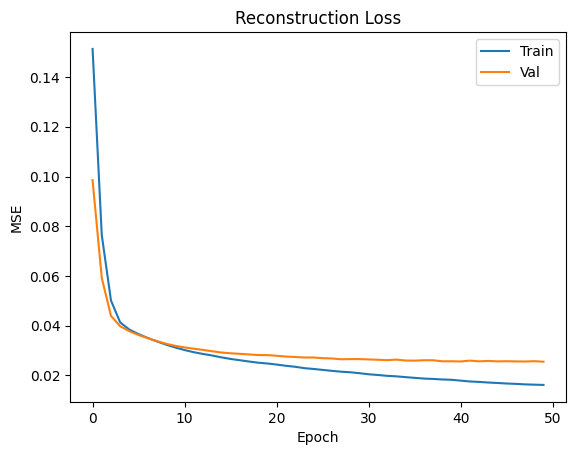

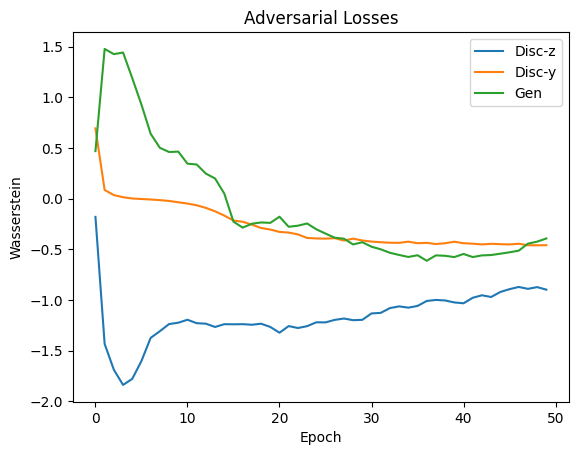

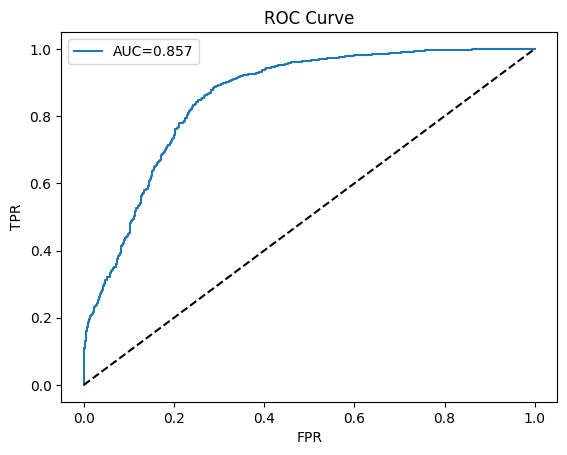

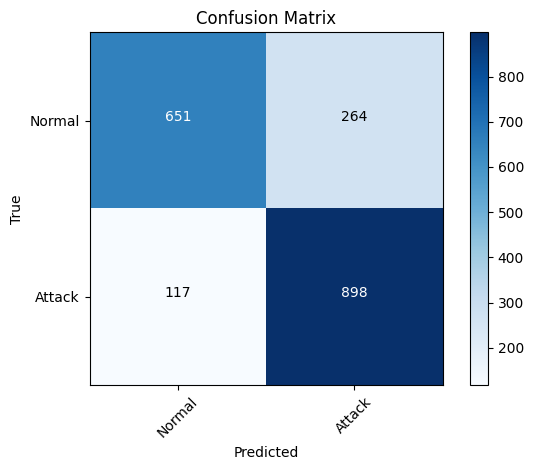

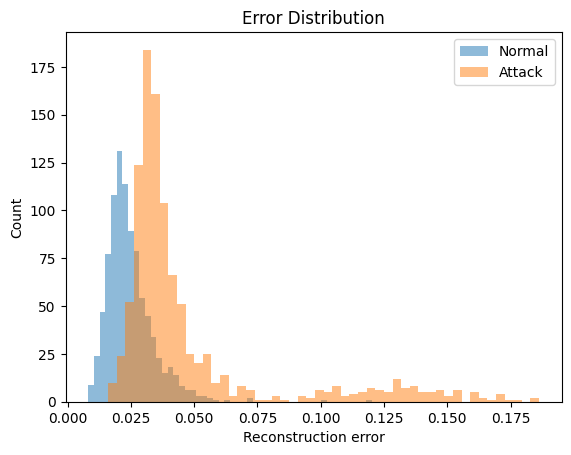

In [ ]:
# ============================================================
# caae_full.py –  Conv-AAE end-to-end pipeline (A→Z)
# ============================================================

import os, glob, itertools, cv2, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# 1) Hyper-parameters
# ------------------------------------------------------------
IMG_SHAPE   = (32, 32, 2)              # <-- תמונת-קלט
FEATURE_DIM = np.prod(IMG_SHAPE)       # 29*29*2
N_LABELS    = 2

BATCH       = 128
EPOCHS      = 50

LATENT_DIM  = 64
λ_gp        = 10.0

LR_AE = 5e-4
LR_DZ = 1e-4
LR_DY = 1e-4
LR_G  = 5e-5

ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'           # layer / batch

# ------------------------------------------------------------
# 2) Pre-processing & TFRecord creation
# ------------------------------------------------------------
datasets = [
    "File_1_cleaned_Final.csv",
    "File_2_cleaned_Final.csv",
    "File_3_cleaned_Final.csv",
    "File_4_cleaned_Final.csv",
    "File_7_cleaned_Final.csv",
    "File_8_cleaned_Final.csv",
    "File_9_cleaned_Final.csv"
]
csv_map = {
    'File_1_cleaned_Final.csv': 'File_1_cleaned_Final.csv',
    'File_2_cleaned_Final.csv': 'File_2_cleaned_Final.csv',
    'File_3_cleaned_Final.csv': 'File_3_cleaned_Final.csv',
    'File_4_cleaned_Final.csv': 'File_4_cleaned_Final.csv',
    'File_7_cleaned_Final.csv': 'File_7_cleaned_Final.csv',
    'File_8_cleaned_Final.csv': 'File_8_cleaned_Final.csv',
    'File_9_cleaned_Final.csv': 'File_9_cleaned_Final.csv'
}


def fill_flag(row):
    if not isinstance(row['Label'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Label'])
    return row

def convert_canid_bits(cid):
    try:
        return np.array(list(map(int, bin(int(str(cid),16))[2:].zfill(29))), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try: return int(str(x).strip(), 16)
    except: return 0

# Replace the preprocess_windows function with this fixed version:
def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    cols = ['Timestamp','canID','DLC']+[f'Data{i}' for i in range(8)] + ['Label']
    df   = pd.read_csv(csv_file, header=None, names=cols, low_memory=False)

    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp','canID']).apply(fill_flag, axis=1)

    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)

    df['Label']    = df['Label'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Label'].values

    win = 29
    N   = len(bits_all)//win
    bits   = bits_all[:N*win].reshape(N, win, 29)
    data   = data_bytes[:N*win].reshape(N, win, 8)
    flags  = flags_all[:N*win].reshape(N, win)

    rows = []
    for i in range(N):
        id_block = bits[i]
        id_img   = cv2.resize(id_block.astype(np.uint8), (32, 32),
                              interpolation=cv2.INTER_NEAREST)

        last_b = data[i,-1,:]
        b8     = np.unpackbits(last_b).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (32, 32),
                              interpolation=cv2.INTER_NEAREST) > .5

        two_ch = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)  # 32x32x2
        rows.append((two_ch.flatten().tolist(), int(flags[i].any())))
    return rows


def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(.7*len(rows)); nvl = int(.15*len(rows))
    splits = {'train':rows[:ntr], 'val':rows[ntr:ntr+nvl], 'test':rows[ntr+nvl:]}
    for phase, chunk in splits.items():
        with tf.io.TFRecordWriter(f"{base}_{phase}.tfrecord") as w:
            for feat,lbl in chunk:
                ex = tf.train.Example(
                     features=tf.train.Features(feature={
                     'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                     'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))}))
                w.write(ex.SerializeToString())

# צור TFRecords אם חסרים

print("[DATA] Creating TFRecords…")
for d in datasets:
    if not os.path.exists(csv_map[d]): continue
    rows = preprocess_windows(csv_map[d])
    normals = [r for r in rows if r[1]==0]
    attacks = [r for r in rows if r[1]==1]
    write_tfrecord(normals, f"Normal_{d}")
    if attacks: write_tfrecord(attacks, d)

# ------------------------------------------------------------
# 3) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    fs = {'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
          'label':    tf.io.FixedLenFeature([1], tf.int64)}
    feat = tf.io.parse_single_example(proto, fs)
    x = tf.cast(feat['features'], tf.float32)
    x = tf.reshape(x, IMG_SHAPE)              # <-- תמונה
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x,y: (x + tf.random.normal(tf.shape(x),0,0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
steps_per_epoch = sum(1 for _ in tf.data.TFRecordDataset(train_files)) // BATCH
print(f"[PIPE] records={steps_per_epoch*BATCH}, steps/epoch={steps_per_epoch}")

# ------------------------------------------------------------
# 4) CAAE Model
# ------------------------------------------------------------
def dense_block(units):
    layers = [tf.keras.layers.Dense(units)]
    if NORM_TYPE=='layer': layers.append(tf.keras.layers.LayerNormalization())
    elif NORM_TYPE=='batch': layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Activation(ACTIVATION))
    if DROPOUT>0: layers.append(tf.keras.layers.Dropout(DROPOUT))
    return tf.keras.Sequential(layers)

class ConvAAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # ---- encoder
        self.enc_c1  = tf.keras.layers.Conv2D(32,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.enc_c2  = tf.keras.layers.Conv2D(64,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.enc_flat= tf.keras.layers.Flatten()
        self.enc_fc  = dense_block(256)
        self.z_layer = tf.keras.layers.Dense(LATENT_DIM)
        self.y_logits= tf.keras.layers.Dense(N_LABELS)

        # ---- decoder
        self.dec_fc   = dense_block(8*8*64)
        self.dec_reshape = tf.keras.layers.Reshape((8,8,64))
        self.dec_t1  = tf.keras.layers.Conv2DTranspose(64,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.dec_t2  = tf.keras.layers.Conv2DTranspose(32,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.dec_out = tf.keras.layers.Conv2DTranspose(2,(3,3),padding='same',activation='sigmoid')

        # ---- discriminators (z , y)
        self.dz = tf.keras.Sequential([dense_block(256),
                                       dense_block(128),
                                       tf.keras.layers.Dense(1)])
        self.dy = tf.keras.Sequential([dense_block(256),
                                       dense_block(128),
                                       tf.keras.layers.Dense(1)])

    # ---------- forward passes ----------
    def encode(self, x):
        h = self.enc_c2(self.enc_c1(x))
        h = self.enc_fc(self.enc_flat(h))
        z = self.z_layer(h)
        logits = self.y_logits(h)
        y = tf.nn.softmax(logits)
        return z, y, logits

    def decode(self, z, y):
        h = tf.concat([z,y], axis=1)
        h = self.dec_fc(h)
        h = self.dec_reshape(h)
        h = self.dec_t2(self.dec_t1(h))
        return self.dec_out(h)

    def discriminate_z(self, z): return self.dz(z)
    def discriminate_y(self, y): return self.dy(y)

    @staticmethod
    def gp(f, real, fake):
        α = tf.random.uniform([real.shape[0],1],0,1)
        inter = real + α*(fake-real)
        with tf.GradientTape() as t:
            t.watch(inter); p=f(inter)
        g = t.gradient(p, inter)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(g), axis=1)+1e-8)
        return tf.reduce_mean((slopes-1.)**2)

caae = ConvAAE()

# ------------------------------------------------------------
# 4.5) Warm-up: לבנות את כל המשתנים לפני האופטימיזרים
# ------------------------------------------------------------
dummy_x = tf.zeros((1,) + IMG_SHAPE, dtype=tf.float32)
z0, y0, _ = caae.encode(dummy_x)
_ = caae.decode(z0, y0)
_ = caae.discriminate_z(tf.random.normal((1, LATENT_DIM)))
_ = caae.discriminate_y(tf.one_hot([0], depth=N_LABELS))
print("[BUILD] all layer variables created:", len(caae.trainable_variables))

# ------------------------------------------------------------
# 5) Losses & optimizers  (עם רשימות קבועות)
# ------------------------------------------------------------
ae_vars = (
    caae.enc_c1.trainable_variables + caae.enc_c2.trainable_variables +
    caae.enc_fc.trainable_variables + caae.z_layer.trainable_variables +
    caae.y_logits.trainable_variables +
    caae.dec_fc.trainable_variables + caae.dec_reshape.trainable_variables +
    caae.dec_t1.trainable_variables + caae.dec_t2.trainable_variables +
    caae.dec_out.trainable_variables
)
dz_vars = caae.dz.trainable_variables
dy_vars = caae.dy.trainable_variables
enc_vars = (
    caae.enc_c1.trainable_variables + caae.enc_c2.trainable_variables +
    caae.enc_fc.trainable_variables + caae.z_layer.trainable_variables +
    caae.y_logits.trainable_variables
)

mse  = tf.keras.losses.MeanSquaredError()
ce   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

# ------------------------------------------------------------
# 6) Training step (tf.function)
# ------------------------------------------------------------
@tf.function
def train_step(x_noisy, x_clean, y_lbl):
    # ---------- auto-encoder ----------
    with tf.GradientTape() as t_ae:
        z_enc, y_enc, _ = caae.encode(x_noisy)
        x_rec = caae.decode(z_enc, y_enc)
        loss_re = mse(x_clean, x_rec)
    grads = t_ae.gradient(loss_re, ae_vars)
    opt_ae.apply_gradients(zip(grads, ae_vars))

    # ---------- discriminator-z ----------
    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([tf.shape(x_noisy)[0], LATENT_DIM])
        dz_r   = caae.discriminate_z(z_real)
        dz_f   = caae.discriminate_z(z_enc)
        gp_z   = caae.gp(caae.discriminate_z, z_real, z_enc)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp_z
    opt_dz.apply_gradients(zip(t_dz.gradient(loss_dz, dz_vars), dz_vars))

    # ---------- discriminator-y ----------
    with tf.GradientTape() as t_dy:
        dy_r = caae.discriminate_y(y_lbl)
        _, y_enc2, _ = caae.encode(x_clean)
        dy_f = caae.discriminate_y(y_enc2)
        gp_y = caae.gp(caae.discriminate_y, y_lbl, y_enc2)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    opt_dy.apply_gradients(zip(t_dy.gradient(loss_dy, dy_vars), dy_vars))

    # ---------- generator / encoder adversarial ----------
    with tf.GradientTape() as t_g:
        z_g, y_g, logits = caae.encode(x_clean)
        loss_g = (
            -tf.reduce_mean(caae.discriminate_z(z_g))
            -tf.reduce_mean(caae.discriminate_y(y_g))
            + ce(y_lbl, logits)
        )
    opt_g.apply_gradients(zip(t_g.gradient(loss_g, enc_vars), enc_vars))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 7) Training loop
# ------------------------------------------------------------
re_hist, dz_hist, dy_hist, g_hist, val_hist = [],[],[],[],[]

for epoch in range(1, EPOCHS+1):
    print(f"\n[TRAIN] Epoch {epoch}/{EPOCHS}")
    ep_re=ep_dz=ep_dy=ep_g=0
    for step,(xn, xc, y) in enumerate(train_ds.take(steps_per_epoch)):
        lr,ldz,ldy,lg = train_step(xn, xc, y)
        ep_re+=lr.numpy(); ep_dz+=ldz.numpy(); ep_dy+=ldy.numpy(); ep_g+=lg.numpy()
        if step%100==0:
            print(f"  step {step}/{steps_per_epoch} | re={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} g={lg:.4f}")
    re_hist.append(ep_re/steps_per_epoch)
    dz_hist.append(ep_dz/steps_per_epoch)
    dy_hist.append(ep_dy/steps_per_epoch)
    g_hist .append(ep_g /steps_per_epoch)

    # -------- validation recon ----------
    val_loss, n_batches = 0,0
    for fn in glob.glob('Normal_*_val.tfrecord'):
        for x_val,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(BATCH):
            x_rec = caae.decode(*caae.encode(x_val)[0:2])
            val_loss += mse(x_val, x_rec).numpy()
            n_batches += 1
    val_hist.append(val_loss/n_batches)
    print(f"[VAL] recon={val_hist[-1]:.4f}")

# ------------------------------------------------------------
# 8) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

# --- Encoder
enc_in = Input(shape=IMG_SHAPE)
h = caae.enc_c2(caae.enc_c1(enc_in))
h = caae.enc_fc(caae.enc_flat(h))
z_out = caae.z_layer(h)
y_log = caae.y_logits(h)
y_out = Activation('softmax')(y_log)
encoder = Model(enc_in, [z_out,y_out], name='caae_encoder')

# --- Decoder
z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2   = caae.dec_fc(Concatenate()([z_in,y_in]))
h2   = caae.dec_reshape(h2)
h2   = caae.dec_t2(caae.dec_t1(h2))
dec_out = caae.dec_out(h2)
decoder = Model([z_in,y_in], dec_out, name='caae_decoder')

encoder.save('caae_encoder.keras')
decoder.save('caae_decoder.keras')
print("[SAVE] models stored")

# ------------------------------------------------------------
# 9) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    for x_batch,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(256):
        z_p,y_p = encoder(x_batch)
        x_r = decoder([z_p,y_p])
        e = tf.reduce_mean(tf.square(x_batch - x_r), axis=[1,2,3]).numpy()
        errs.append(e); ys.append(np.full(e.shape,label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr,tpr,ths = roc_curve(ys, errs)
roc_auc     = auc(fpr,tpr)
best_idx    = np.argmax(tpr-fpr)
thr_opt     = ths[best_idx]

print(f"\n[RESULT] ROC-AUC={roc_auc:.4f} | Thr={thr_opt:.6f} | "
      f"TPR={tpr[best_idx]:.3f} | FPR={fpr[best_idx]:.3f}")
cm = confusion_matrix(ys, (errs>thr_opt).astype(int))
print("[CM]\n", cm)
print("[Report]\n", classification_report(ys,(errs>thr_opt).astype(int),
                                          target_names=['Normal','Attack']))

# ------------------------------------------------------------
# 10) Plotting
# ------------------------------------------------------------
# -- Reconstruction loss curves
plt.figure(); plt.plot(re_hist,label='Train'); plt.plot(val_hist,label='Val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Reconstruction Loss'); plt.legend(); plt.show()

# -- Adversarial losses
plt.figure(); plt.plot(dz_hist,label='Disc-z'); plt.plot(dy_hist,label='Disc-y'); plt.plot(g_hist,label='Gen')
plt.xlabel('Epoch'); plt.ylabel('Wasserstein'); plt.title('Adversarial Losses'); plt.legend(); plt.show()

# -- ROC curve
plt.figure(); plt.plot(fpr,tpr,label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# -- Confusion-matrix heat-map
plt.figure(); plt.imshow(cm,cmap=plt.cm.Blues); plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(2); classes=['Normal','Attack']
plt.xticks(ticks,classes,rotation=45); plt.yticks(ticks,classes)
th = cm.max()/2
for i,j in itertools.product(range(2),range(2)):
    plt.text(j,i,cm[i,j],ha='center',color='white' if cm[i,j]>th else 'black')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

# -- Error distributions
plt.figure()
plt.hist(errs[ys==0],bins=50,alpha=.5,label='Normal')
plt.hist(errs[ys==1],bins=50,alpha=.5,label='Attack')
plt.xlabel('Reconstruction error'); plt.ylabel('Count')
plt.title('Error Distribution'); plt.legend(); plt.show()


# aae vs caee small-mid size of data set 50 epoch

[DATA] Creating TFRecords…
[DATA] Processing Attack_free_CHEVROLET_Spark_train.csv
[DATA] Processing Attack_free_KIA_Soul_train.csv
[DATA] Processing Flooding_CHEVROLET_Spark_train.csv
[DATA] Processing Flooding_KIA_Soul_train.csv
[DATA] Processing Fuzzy_CHEVROLET_Spark_train.csv
[DATA] Processing Attack_free_HY_Sonata_train.csv
[DATA] Processing Attack_free_KIA_Soul_train.csv
[DATA] Processing Fuzzy_dataset_HY_Sonata_train.csv
[DATA] Processing Fuzzy_dataset_KIA_Soul_train.csv
[DATA] Processing Malfunction_1st_dataset_HY_Sonata_train.csv
[DATA] Processing Malfunction_1st_dataset_KIA_Soul_train.csv
[DATA] Processing Malfunction_2nd_HY_Sonata_train.csv
[DATA] Processing Malfunction_2nd_KIA_Soul_train.csv
[DATA] Processing Replay_dataset_HY_Sonata_train.csv
[DATA] Processing Replay_dataset_KIA_Soul_train.csv
[PIPE] records=60160, steps/epoch=470
[BUILD] all layer variables created: 42

[TRAIN] Epoch 1/50
  step 0/470 | re=0.2548 dz=4.1040 dy=12.6625 g=-1.6933
  step 100/470 | re=0.0448 d

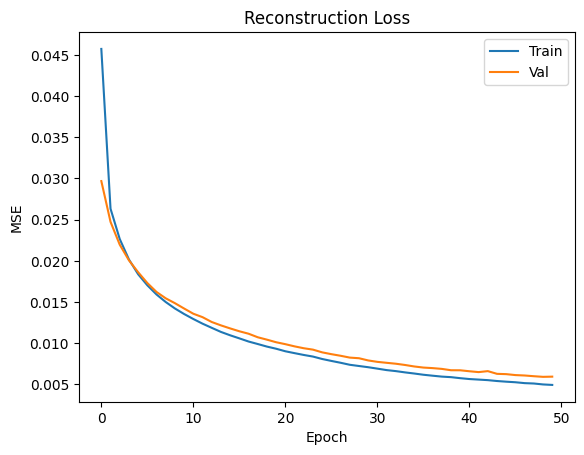

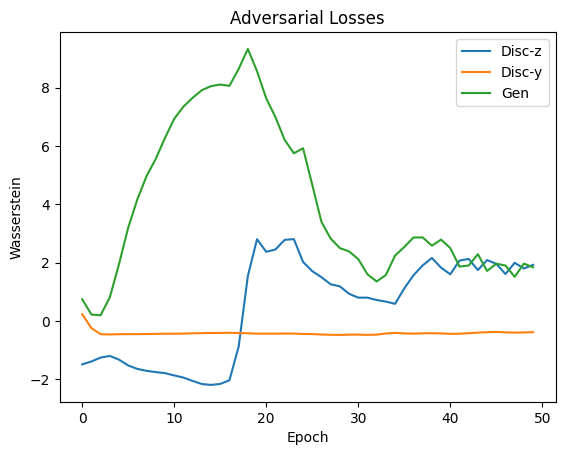

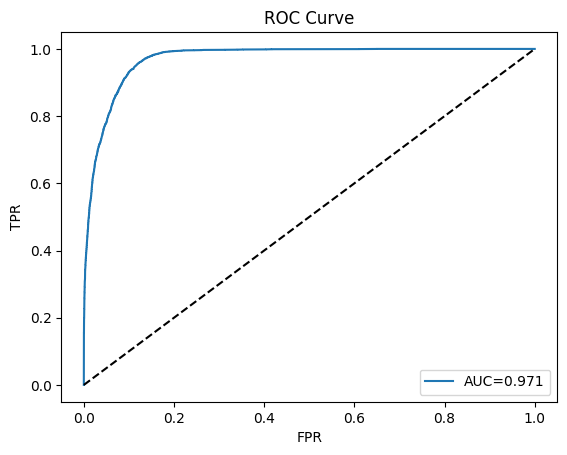

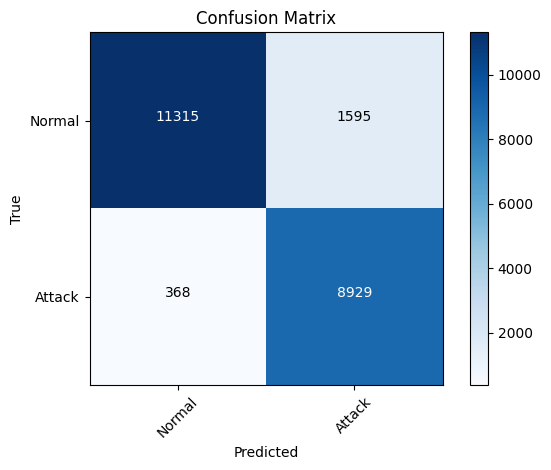

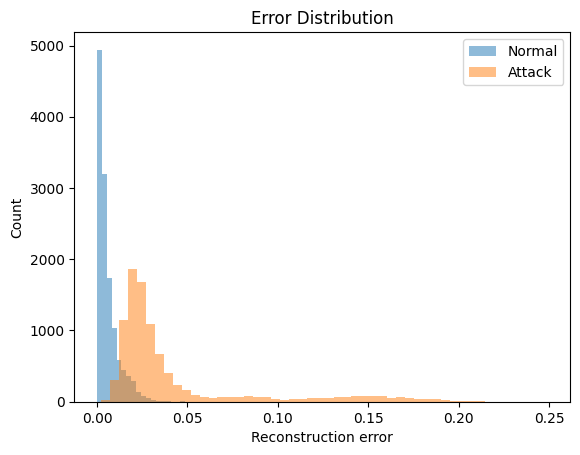

In [ ]:
# ============================================================
# caae_full.py –  Conv-AAE end-to-end pipeline (A→Z)
# ============================================================

import os, glob, itertools, cv2, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# 1) Hyper-parameters
# ------------------------------------------------------------
IMG_SHAPE   = (32, 32, 2)              # <-- תמונת-קלט
FEATURE_DIM = np.prod(IMG_SHAPE)       #
N_LABELS    = 2

BATCH       = 128
EPOCHS      = 50

LATENT_DIM  = 64
λ_gp        = 10.0

LR_AE = 5e-4
LR_DZ = 1e-4
LR_DY = 1e-4
LR_G  = 5e-5

ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'           # layer / batch

# ------------------------------------------------------------
# 2) Pre-processing & TFRecord creation  (ללא שינוי לוגי)
# ------------------------------------------------------------
datasets = [
    "Attack_free_CHEVROLET_Spark_train.csv",
    "Attack_free_KIA_Soul_train.csv",
    "Flooding_CHEVROLET_Spark_train.csv",
    "Flooding_KIA_Soul_train.csv",
    "Fuzzy_CHEVROLET_Spark_train.csv",
    "Attack_free_HY_Sonata_train.csv",
    "Attack_free_KIA_Soul_train.csv",
    "Fuzzy_dataset_HY_Sonata_train.csv",
    "Fuzzy_dataset_KIA_Soul_train.csv",
    "Malfunction_1st_dataset_HY_Sonata_train.csv",
    "Malfunction_1st_dataset_KIA_Soul_train.csv",
    "Malfunction_2nd_HY_Sonata_train.csv",
    "Malfunction_2nd_KIA_Soul_train.csv",
    "Replay_dataset_HY_Sonata_train.csv",
    "Replay_dataset_KIA_Soul_train.csv"
]
csv_map = {d: d for d in datasets}



def fill_flag(row):
    if not isinstance(row['Label'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Label'])
    return row

def convert_canid_bits(cid):
    try:
        return np.array(list(map(int, bin(int(str(cid),16))[2:].zfill(29))), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try: return int(str(x).strip(), 16)
    except: return 0

# Replace the preprocess_windows function with this fixed version:
def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    cols = ['Timestamp','canID','DLC']+[f'Data{i}' for i in range(8)] + ['Label']
    df   = pd.read_csv(csv_file, header=None, names=cols, low_memory=False)

    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp','canID']).apply(fill_flag, axis=1)

    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)

    df['Label']    = df['Label'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Label'].values

    win = 29
    N   = len(bits_all)//win
    bits   = bits_all[:N*win].reshape(N, win, 29)
    data   = data_bytes[:N*win].reshape(N, win, 8)
    flags  = flags_all[:N*win].reshape(N, win)

    rows = []
    for i in range(N):
        id_block = bits[i]
        id_img   = cv2.resize(id_block.astype(np.uint8), (32, 32),
                              interpolation=cv2.INTER_NEAREST)

        last_b = data[i,-1,:]
        b8     = np.unpackbits(last_b).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (32, 32),
                              interpolation=cv2.INTER_NEAREST) > .5

        two_ch = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)  # 32x32x2
        rows.append((two_ch.flatten().tolist(), int(flags[i].any())))
    return rows


def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(.7*len(rows)); nvl = int(.15*len(rows))
    splits = {'train':rows[:ntr], 'val':rows[ntr:ntr+nvl], 'test':rows[ntr+nvl:]}
    for phase, chunk in splits.items():
        with tf.io.TFRecordWriter(f"{base}_{phase}.tfrecord") as w:
            for feat,lbl in chunk:
                ex = tf.train.Example(
                     features=tf.train.Features(feature={
                     'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                     'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))}))
                w.write(ex.SerializeToString())

# צור TFRecords אם חסרים

print("[DATA] Creating TFRecords…")
for d in datasets:
    if not os.path.exists(csv_map[d]): continue
    rows = preprocess_windows(csv_map[d])
    normals = [r for r in rows if r[1]==0]
    attacks = [r for r in rows if r[1]==1]
    write_tfrecord(normals, f"Normal_{d}")
    if attacks: write_tfrecord(attacks, d)

# ------------------------------------------------------------
# 3) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    fs = {'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
          'label':    tf.io.FixedLenFeature([1], tf.int64)}
    feat = tf.io.parse_single_example(proto, fs)
    x = tf.cast(feat['features'], tf.float32)
    x = tf.reshape(x, IMG_SHAPE)              # <-- תמונה
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x,y: (x + tf.random.normal(tf.shape(x),0,0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
steps_per_epoch = sum(1 for _ in tf.data.TFRecordDataset(train_files)) // BATCH
print(f"[PIPE] records={steps_per_epoch*BATCH}, steps/epoch={steps_per_epoch}")

# ------------------------------------------------------------
# 4) CAAE Model
# ------------------------------------------------------------
def dense_block(units):
    layers = [tf.keras.layers.Dense(units)]
    if NORM_TYPE=='layer': layers.append(tf.keras.layers.LayerNormalization())
    elif NORM_TYPE=='batch': layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Activation(ACTIVATION))
    if DROPOUT>0: layers.append(tf.keras.layers.Dropout(DROPOUT))
    return tf.keras.Sequential(layers)

class ConvAAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # ---- encoder
        self.enc_c1  = tf.keras.layers.Conv2D(32,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.enc_c2  = tf.keras.layers.Conv2D(64,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.enc_flat= tf.keras.layers.Flatten()
        self.enc_fc  = dense_block(256)
        self.z_layer = tf.keras.layers.Dense(LATENT_DIM)
        self.y_logits= tf.keras.layers.Dense(N_LABELS)

        # ---- decoder
        self.dec_fc   = dense_block(8*8*64)
        self.dec_reshape = tf.keras.layers.Reshape((8,8,64))
        self.dec_t1  = tf.keras.layers.Conv2DTranspose(64,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.dec_t2  = tf.keras.layers.Conv2DTranspose(32,(3,3),strides=2,padding='same',activation=ACTIVATION)
        self.dec_out = tf.keras.layers.Conv2DTranspose(2,(3,3),padding='same',activation='sigmoid')

        # ---- discriminators (z , y)
        self.dz = tf.keras.Sequential([dense_block(256),
                                       dense_block(128),
                                       tf.keras.layers.Dense(1)])
        self.dy = tf.keras.Sequential([dense_block(256),
                                       dense_block(128),
                                       tf.keras.layers.Dense(1)])

    # ---------- forward passes ----------
    def encode(self, x):
        h = self.enc_c2(self.enc_c1(x))
        h = self.enc_fc(self.enc_flat(h))
        z = self.z_layer(h)
        logits = self.y_logits(h)
        y = tf.nn.softmax(logits)
        return z, y, logits

    def decode(self, z, y):
        h = tf.concat([z,y], axis=1)
        h = self.dec_fc(h)
        h = self.dec_reshape(h)
        h = self.dec_t2(self.dec_t1(h))
        return self.dec_out(h)

    def discriminate_z(self, z): return self.dz(z)
    def discriminate_y(self, y): return self.dy(y)

    @staticmethod
    def gp(f, real, fake):
        α = tf.random.uniform([real.shape[0],1],0,1)
        inter = real + α*(fake-real)
        with tf.GradientTape() as t:
            t.watch(inter); p=f(inter)
        g = t.gradient(p, inter)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(g), axis=1)+1e-8)
        return tf.reduce_mean((slopes-1.)**2)

caae = ConvAAE()

# ------------------------------------------------------------
# 4.5) Warm-up: לבנות את כל המשתנים לפני האופטימיזרים
# ------------------------------------------------------------
dummy_x = tf.zeros((1,) + IMG_SHAPE, dtype=tf.float32)
z0, y0, _ = caae.encode(dummy_x)
_ = caae.decode(z0, y0)
_ = caae.discriminate_z(tf.random.normal((1, LATENT_DIM)))
_ = caae.discriminate_y(tf.one_hot([0], depth=N_LABELS))
print("[BUILD] all layer variables created:", len(caae.trainable_variables))

# ------------------------------------------------------------
# 5) Losses & optimizers  (עם רשימות קבועות)
# ------------------------------------------------------------
ae_vars = (
    caae.enc_c1.trainable_variables + caae.enc_c2.trainable_variables +
    caae.enc_fc.trainable_variables + caae.z_layer.trainable_variables +
    caae.y_logits.trainable_variables +
    caae.dec_fc.trainable_variables + caae.dec_reshape.trainable_variables +
    caae.dec_t1.trainable_variables + caae.dec_t2.trainable_variables +
    caae.dec_out.trainable_variables
)
dz_vars = caae.dz.trainable_variables
dy_vars = caae.dy.trainable_variables
enc_vars = (
    caae.enc_c1.trainable_variables + caae.enc_c2.trainable_variables +
    caae.enc_fc.trainable_variables + caae.z_layer.trainable_variables +
    caae.y_logits.trainable_variables
)

mse  = tf.keras.losses.MeanSquaredError()
ce   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

# ------------------------------------------------------------
# 6) Training step (tf.function)
# ------------------------------------------------------------
@tf.function
def train_step(x_noisy, x_clean, y_lbl):
    # ---------- auto-encoder ----------
    with tf.GradientTape() as t_ae:
        z_enc, y_enc, _ = caae.encode(x_noisy)
        x_rec = caae.decode(z_enc, y_enc)
        loss_re = mse(x_clean, x_rec)
    grads = t_ae.gradient(loss_re, ae_vars)
    opt_ae.apply_gradients(zip(grads, ae_vars))

    # ---------- discriminator-z ----------
    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([tf.shape(x_noisy)[0], LATENT_DIM])
        dz_r   = caae.discriminate_z(z_real)
        dz_f   = caae.discriminate_z(z_enc)
        gp_z   = caae.gp(caae.discriminate_z, z_real, z_enc)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp_z
    opt_dz.apply_gradients(zip(t_dz.gradient(loss_dz, dz_vars), dz_vars))

    # ---------- discriminator-y ----------
    with tf.GradientTape() as t_dy:
        dy_r = caae.discriminate_y(y_lbl)
        _, y_enc2, _ = caae.encode(x_clean)
        dy_f = caae.discriminate_y(y_enc2)
        gp_y = caae.gp(caae.discriminate_y, y_lbl, y_enc2)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    opt_dy.apply_gradients(zip(t_dy.gradient(loss_dy, dy_vars), dy_vars))

    # ---------- generator / encoder adversarial ----------
    with tf.GradientTape() as t_g:
        z_g, y_g, logits = caae.encode(x_clean)
        loss_g = (
            -tf.reduce_mean(caae.discriminate_z(z_g))
            -tf.reduce_mean(caae.discriminate_y(y_g))
            + ce(y_lbl, logits)
        )
    opt_g.apply_gradients(zip(t_g.gradient(loss_g, enc_vars), enc_vars))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 7) Training loop
# ------------------------------------------------------------
re_hist, dz_hist, dy_hist, g_hist, val_hist = [],[],[],[],[]

for epoch in range(1, EPOCHS+1):
    print(f"\n[TRAIN] Epoch {epoch}/{EPOCHS}")
    ep_re=ep_dz=ep_dy=ep_g=0
    for step,(xn, xc, y) in enumerate(train_ds.take(steps_per_epoch)):
        lr,ldz,ldy,lg = train_step(xn, xc, y)
        ep_re+=lr.numpy(); ep_dz+=ldz.numpy(); ep_dy+=ldy.numpy(); ep_g+=lg.numpy()
        if step%100==0:
            print(f"  step {step}/{steps_per_epoch} | re={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} g={lg:.4f}")
    re_hist.append(ep_re/steps_per_epoch)
    dz_hist.append(ep_dz/steps_per_epoch)
    dy_hist.append(ep_dy/steps_per_epoch)
    g_hist .append(ep_g /steps_per_epoch)

    # -------- validation recon ----------
    val_loss, n_batches = 0,0
    for fn in glob.glob('Normal_*_val.tfrecord'):
        for x_val,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(BATCH):
            x_rec = caae.decode(*caae.encode(x_val)[0:2])
            val_loss += mse(x_val, x_rec).numpy()
            n_batches += 1
    val_hist.append(val_loss/n_batches)
    print(f"[VAL] recon={val_hist[-1]:.4f}")

# ------------------------------------------------------------
# 8) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

# --- Encoder
enc_in = Input(shape=IMG_SHAPE)
h = caae.enc_c2(caae.enc_c1(enc_in))
h = caae.enc_fc(caae.enc_flat(h))
z_out = caae.z_layer(h)
y_log = caae.y_logits(h)
y_out = Activation('softmax')(y_log)
encoder = Model(enc_in, [z_out,y_out], name='caae_encoder')

# --- Decoder
z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2   = caae.dec_fc(Concatenate()([z_in,y_in]))
h2   = caae.dec_reshape(h2)
h2   = caae.dec_t2(caae.dec_t1(h2))
dec_out = caae.dec_out(h2)
decoder = Model([z_in,y_in], dec_out, name='caae_decoder')

encoder.save('caae_encoder.keras')
decoder.save('caae_decoder.keras')
print("[SAVE] models stored")

# ------------------------------------------------------------
# 9) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    for x_batch,_ in tf.data.TFRecordDataset(fn).map(parse_feat).batch(256):
        z_p,y_p = encoder(x_batch)
        x_r = decoder([z_p,y_p])
        e = tf.reduce_mean(tf.square(x_batch - x_r), axis=[1,2,3]).numpy()
        errs.append(e); ys.append(np.full(e.shape,label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr,tpr,ths = roc_curve(ys, errs)
roc_auc     = auc(fpr,tpr)
best_idx    = np.argmax(tpr-fpr)
thr_opt     = ths[best_idx]

print(f"\n[RESULT] ROC-AUC={roc_auc:.4f} | Thr={thr_opt:.6f} | "
      f"TPR={tpr[best_idx]:.3f} | FPR={fpr[best_idx]:.3f}")
cm = confusion_matrix(ys, (errs>thr_opt).astype(int))
print("[CM]\n", cm)
print("[Report]\n", classification_report(ys,(errs>thr_opt).astype(int),
                                          target_names=['Normal','Attack']))

# ------------------------------------------------------------
# 10) Plotting
# ------------------------------------------------------------
# -- Reconstruction loss curves
plt.figure(); plt.plot(re_hist,label='Train'); plt.plot(val_hist,label='Val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Reconstruction Loss'); plt.legend(); plt.show()

# -- Adversarial losses
plt.figure(); plt.plot(dz_hist,label='Disc-z'); plt.plot(dy_hist,label='Disc-y'); plt.plot(g_hist,label='Gen')
plt.xlabel('Epoch'); plt.ylabel('Wasserstein'); plt.title('Adversarial Losses'); plt.legend(); plt.show()

# -- ROC curve
plt.figure(); plt.plot(fpr,tpr,label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# -- Confusion-matrix heat-map
plt.figure(); plt.imshow(cm,cmap=plt.cm.Blues); plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(2); classes=['Normal','Attack']
plt.xticks(ticks,classes,rotation=45); plt.yticks(ticks,classes)
th = cm.max()/2
for i,j in itertools.product(range(2),range(2)):
    plt.text(j,i,cm[i,j],ha='center',color='white' if cm[i,j]>th else 'black')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

# -- Error distributions
plt.figure()
plt.hist(errs[ys==0],bins=50,alpha=.5,label='Normal')
plt.hist(errs[ys==1],bins=50,alpha=.5,label='Attack')
plt.xlabel('Reconstruction error'); plt.ylabel('Count')
plt.title('Error Distribution'); plt.legend(); plt.show()


[DATA] TFRecords missing, preprocessing...
[DATA] Processing Attack_free_CHEVROLET_Spark_train.csv
[DATA] Processing Attack_free_KIA_Soul_train.csv
[DATA] Processing Flooding_CHEVROLET_Spark_train.csv
[DATA] Processing Flooding_KIA_Soul_train.csv
[DATA] Processing Fuzzy_CHEVROLET_Spark_train.csv
[DATA] Processing Attack_free_HY_Sonata_train.csv
[DATA] Processing Attack_free_KIA_Soul_train.csv
[DATA] Processing Fuzzy_dataset_HY_Sonata_train.csv
[DATA] Processing Fuzzy_dataset_KIA_Soul_train.csv
[DATA] Processing Malfunction_1st_dataset_HY_Sonata_train.csv
[DATA] Processing Malfunction_1st_dataset_KIA_Soul_train.csv
[DATA] Processing Malfunction_2nd_HY_Sonata_train.csv
[DATA] Processing Malfunction_2nd_KIA_Soul_train.csv
[DATA] Processing Replay_dataset_HY_Sonata_train.csv
[DATA] Processing Replay_dataset_KIA_Soul_train.csv
[PIPE] Total records: 64814, steps/epoch: 506
[TRAIN] Epoch 1/30
 step 0/506 | recon=0.2747 dz=1.9162 dy=4.0835 gen=0.5807
 step 100/506 | recon=0.0583 dz=-4.3568 dy=

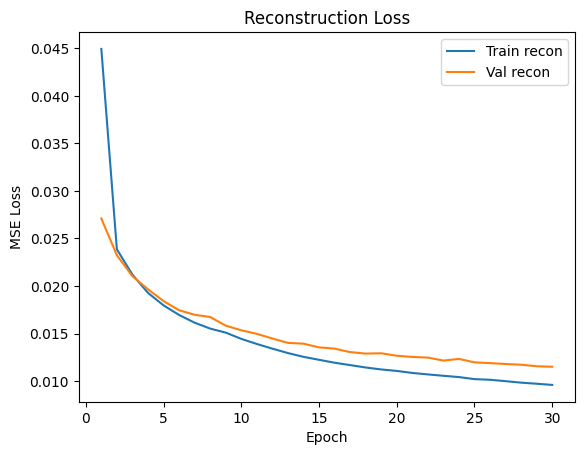

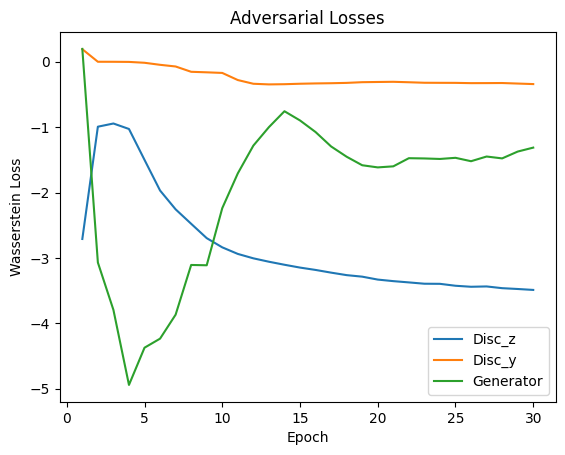

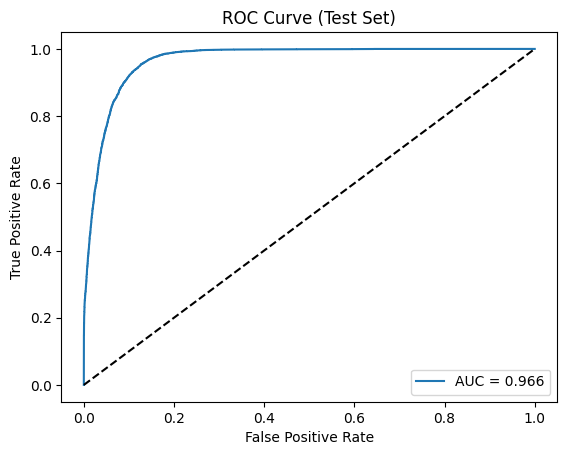

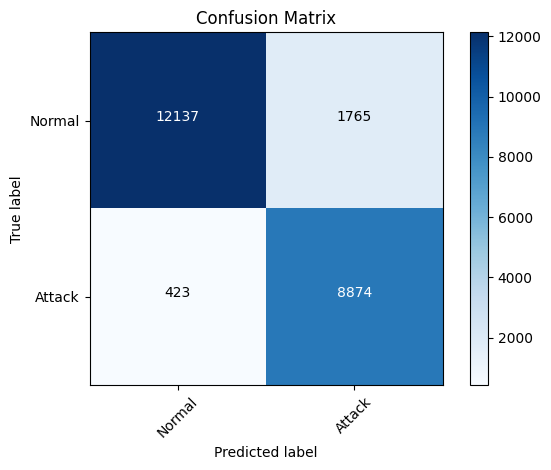

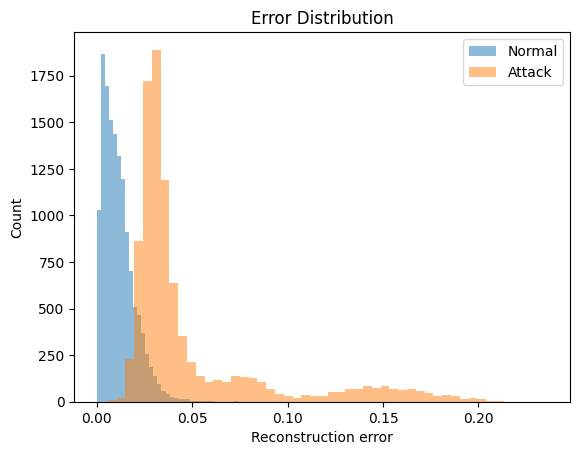

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

# ------------------------------------------------------------
# 0) GPU setup (optional)
# ------------------------------------------------------------
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# ------------------------------------------------------------
# Hyperparameters
# ------------------------------------------------------------
FEATURE_DIM = 29 * 29 * 2
N_LABELS   = 2
BATCH      = 128
EPOCHS     = 30

# AAE-specific
N_L1       = 1024
N_L2       = 768
LATENT_DIM = 64
λ_gp       = 10.0

# Learning rates
LR_AE = 0.0005
LR_DZ = 0.0001
LR_DY = 0.0001
LR_G  = 5e-5

# Architecture options
ACTIVATION = 'elu'
DROPOUT    = 0.2
NORM_TYPE  = 'layer'  # 'layer' or 'batch'

# ------------------------------------------------------------
# 1) Helper functions: preprocessing & TFRecord creation
# ------------------------------------------------------------
datasets = [
    "Attack_free_CHEVROLET_Spark_train.csv",
    "Attack_free_KIA_Soul_train.csv",
    "Flooding_CHEVROLET_Spark_train.csv",
    "Flooding_KIA_Soul_train.csv",
    "Fuzzy_CHEVROLET_Spark_train.csv",
    "Attack_free_HY_Sonata_train.csv",
    "Attack_free_KIA_Soul_train.csv",
    "Fuzzy_dataset_HY_Sonata_train.csv",
    "Fuzzy_dataset_KIA_Soul_train.csv",
    "Malfunction_1st_dataset_HY_Sonata_train.csv",
    "Malfunction_1st_dataset_KIA_Soul_train.csv",
    "Malfunction_2nd_HY_Sonata_train.csv",
    "Malfunction_2nd_KIA_Soul_train.csv",
    "Replay_dataset_HY_Sonata_train.csv",
    "Replay_dataset_KIA_Soul_train.csv"
]
csv_map = {d: d for d in datasets}

def fill_flag(row):
    if not isinstance(row['Flag'], str):
        col = 'Data' + str(int(row['DLC']))
        row['Flag'] = row.get(col, row['Flag'])
    return row

def convert_canid_bits(cid):
    try:
        b = bin(int(str(cid), 16))[2:].zfill(29)
        return np.array(list(map(int, b)), dtype=np.uint8)
    except:
        return np.zeros(29, dtype=np.uint8)

def hex_to_int(x):
    try:
        return int(str(x).strip(), 16)
    except:
        return 0

def preprocess_windows(csv_file):
    print(f"[DATA] Processing {csv_file}")
    attrs = ['Timestamp', 'canID', 'DLC'] + [f'Data{i}' for i in range(8)] + ['Flag']
    df = pd.read_csv(csv_file, header=None, names=attrs, low_memory=False)
    df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
    df['DLC']       = pd.to_numeric(df['DLC'], errors='coerce').fillna(0).astype(int)
    df = df.dropna(subset=['Timestamp', 'canID']).apply(fill_flag, axis=1)
    for i in range(8):
        df[f'Data{i}'] = df[f'Data{i}'].apply(hex_to_int).astype(np.uint8)
    df['Flag']    = df['Flag'].astype(str).str.upper().eq('T').astype(np.uint8)
    df['canBits'] = df['canID'].apply(convert_canid_bits)
    df = df.sort_values('Timestamp')

    bits_all   = np.stack(df['canBits'].values)
    data_bytes = df[[f'Data{i}' for i in range(8)]].values
    flags_all  = df['Flag'].values

    win = 29
    N   = len(bits_all) // win
    bits   = bits_all[:N * win].reshape(N, win, 29)
    data   = data_bytes[:N * win].reshape(N, win, 8)
    flags  = flags_all[:N * win].reshape(N, win)

    rows = []
    for i in range(N):
        id_img   = bits[i].astype(np.uint8)
        last_b   = data[i, -1, :]
        b8       = np.unpackbits(last_b, axis=0).reshape(8,8)
        data_img = cv2.resize(b8.astype(np.float32), (29,29), interpolation=cv2.INTER_NEAREST) > 0.5
        two_ch   = np.stack([id_img, data_img.astype(np.uint8)], axis=-1)
        feat_int = two_ch.flatten().tolist()
        lbl      = int(flags[i].any())
        rows.append((feat_int, lbl))
    return rows

def write_tfrecord(rows, base):
    np.random.shuffle(rows)
    ntr = int(0.7 * len(rows))
    nvl = int(0.15 * len(rows))
    splits = {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+ntr+nvl:]} if False else {'train': rows[:ntr], 'val': rows[ntr:ntr+nvl], 'test': rows[ntr+nvl:]}
    for ph, ch in splits.items():
        fn = f"{base}_{ph}.tfrecord"
        with tf.io.TFRecordWriter(fn) as writer:
            for feat, lbl in ch:
                ex = tf.train.Example(features=tf.train.Features(feature={
                    'features': tf.train.Feature(int64_list=tf.train.Int64List(value=feat)),
                    'label':    tf.train.Feature(int64_list=tf.train.Int64List(value=[lbl]))
                }))
                writer.write(ex.SerializeToString())

# Create/check TFRecords
expected = []
for a in datasets:
    for ph in ('train', 'val', 'test'):
        expected.append(f"{a}_{ph}.tfrecord")
        if a != 'parsed_dataset':
            expected.append(f"Normal_{a}_{ph}.tfrecord")
if not all(os.path.exists(f) for f in expected):
    print("[DATA] TFRecords missing, preprocessing...")
    for a in datasets:
        src = csv_map[a]
        if not os.path.exists(src):
            print(f"[WARN] {src} not found")
        else:
            rows    = preprocess_windows(src)
            normals = [r for r in rows if r[1] == 0]
            attacks = [r for r in rows if r[1] == 1]
            write_tfrecord(normals, f"Normal_{a}")
            if attacks:
                write_tfrecord(attacks, a)
else:
    print("[DATA] All TFRecords found.")

# ------------------------------------------------------------
# 2) tf.data pipeline
# ------------------------------------------------------------
def parse_feat(proto):
    feat = tf.io.parse_single_example(proto, {
        'features': tf.io.FixedLenFeature([FEATURE_DIM], tf.int64),
        'label':    tf.io.FixedLenFeature([1], tf.int64)
    })
    x = tf.cast(feat['features'], tf.float32)
    y = tf.one_hot(tf.cast(feat['label'][0], tf.int32), N_LABELS)
    return x, y

train_files = glob.glob('Normal_*_train.tfrecord')
train_ds = (
    tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE)
    .map(parse_feat, tf.data.AUTOTUNE)
    .map(lambda x, y: (x + tf.random.normal(tf.shape(x), 0, 0.01), x, y), tf.data.AUTOTUNE)
    .shuffle(10000).repeat()
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
)
total = sum(1 for _ in tf.data.TFRecordDataset(train_files))
steps_per_epoch = total // BATCH
print(f"[PIPE] Total records: {total}, steps/epoch: {steps_per_epoch}")

# ------------------------------------------------------------
# 3) AAE Model definition
# ------------------------------------------------------------
class AAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        def dense_block(units):
            layers = [tf.keras.layers.Dense(units)]
            if NORM_TYPE == 'layer': layers.append(tf.keras.layers.LayerNormalization())
            elif NORM_TYPE == 'batch': layers.append(tf.keras.layers.BatchNormalization())
            layers.append(tf.keras.layers.Activation(ACTIVATION))
            if DROPOUT > 0: layers.append(tf.keras.layers.Dropout(DROPOUT))
            return tf.keras.Sequential(layers)

        self.e1   = dense_block(N_L1)
        self.e2   = dense_block(N_L2)
        self.ez   = tf.keras.layers.Dense(LATENT_DIM)
        self.ey   = tf.keras.layers.Dense(N_LABELS)

        self.d1   = dense_block(N_L2)
        self.d2   = dense_block(N_L1)
        self.dout = tf.keras.layers.Dense(FEATURE_DIM, activation='sigmoid')

        self.dz1  = dense_block(N_L1)
        self.dz2  = dense_block(N_L2)
        self.dzout= tf.keras.layers.Dense(1)

        self.dy1  = dense_block(N_L1)
        self.dy2  = dense_block(N_L2)
        self.dyout= tf.keras.layers.Dense(1)

    def encode(self, x):
        h      = self.e2(self.e1(x))
        z      = self.ez(h)
        logits = self.ey(h)
        return z, tf.nn.softmax(logits), logits

    def decode(self, z, y):
        h = tf.concat([z, y], axis=1)
        h = self.d1(h)
        h = self.d2(h)
        return self.dout(h)

    def discriminate_z(self, z):
        h = self.dz1(z)
        h = self.dz2(h)
        return self.dzout(h)

    def discriminate_y(self, y):
        h = self.dy1(y)
        h = self.dy2(h)
        return self.dyout(h)

    def gradient_penalty(self, f, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1], 0, 1)
        interm = real + alpha * (fake - real)
        with tf.GradientTape() as tape:
            tape.watch(interm)
            pred = f(interm)
        grads = tape.gradient(pred, interm)
        slopes= tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-8)
        return tf.reduce_mean((slopes - 1)**2)

aae = AAE()

# ------------------------------------------------------------
# 4) Losses & Optimizers
# ------------------------------------------------------------
mse    = tf.keras.losses.MeanSquaredError()
ce     = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_ae = tf.keras.optimizers.Adam(LR_AE)
opt_dz = tf.keras.optimizers.Adam(LR_DZ)
opt_dy = tf.keras.optimizers.Adam(LR_DY)
opt_g  = tf.keras.optimizers.Adam(LR_G)

# Lists to track losses
train_re_losses = []
val_re_losses   = []
train_dz_losses = []
train_dy_losses = []
train_g_losses  = []

@tf.function
def train_step(xn, xc, y):
    with tf.GradientTape() as t_ae:
        z, yp, logits = aae.encode(xn)
        xr = aae.decode(z, yp)
        loss_re = mse(xc, xr)
    vars_ae = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables + aae.d1.trainable_variables + aae.d2.trainable_variables + aae.dout.trainable_variables
    grads_ae = t_ae.gradient(loss_re, vars_ae)
    opt_ae.apply_gradients(zip(grads_ae, vars_ae))

    with tf.GradientTape() as t_dz:
        z_real = tf.random.normal([xn.shape[0], LATENT_DIM])
        dz_r = aae.discriminate_z(z_real)
        dz_f = aae.discriminate_z(z)
        gp   = aae.gradient_penalty(aae.discriminate_z, z_real, z)
        loss_dz = tf.reduce_mean(dz_f) - tf.reduce_mean(dz_r) + λ_gp * gp
    vars_dz = aae.dz1.trainable_variables + aae.dz2.trainable_variables + aae.dzout.trainable_variables
    grads_dz = t_dz.gradient(loss_dz, vars_dz)
    opt_dz.apply_gradients(zip(grads_dz, vars_dz))

    with tf.GradientTape() as t_dy:
        dy_r = aae.discriminate_y(y)
        _, yp_enc, _ = aae.encode(xc)
        dy_f = aae.discriminate_y(yp_enc)
        gp_y = aae.gradient_penalty(aae.discriminate_y, y, yp_enc)
        loss_dy = tf.reduce_mean(dy_f) - tf.reduce_mean(dy_r) + λ_gp * gp_y
    vars_dy = aae.dy1.trainable_variables + aae.dy2.trainable_variables + aae.dyout.trainable_variables
    grads_dy = t_dy.gradient(loss_dy, vars_dy)
    opt_dy.apply_gradients(zip(grads_dy, vars_dy))

    with tf.GradientTape() as t_g:
        z_enc, y_enc, logits_enc = aae.encode(xc)
        loss_g = -tf.reduce_mean(aae.discriminate_z(z_enc))
        loss_g += -tf.reduce_mean(aae.discriminate_y(y_enc))
        loss_g += ce(y, logits_enc)
    vars_g = aae.e1.trainable_variables + aae.e2.trainable_variables + aae.ez.trainable_variables + aae.ey.trainable_variables
    grads_g = t_g.gradient(loss_g, vars_g)
    opt_g.apply_gradients(zip(grads_g, vars_g))

    return loss_re, loss_dz, loss_dy, loss_g

# ------------------------------------------------------------
# 5) Training loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    print(f"[TRAIN] Epoch {epoch}/{EPOCHS}")
    epoch_re, epoch_dz, epoch_dy, epoch_g = 0, 0, 0, 0
    it = iter(train_ds)
    for step in range(steps_per_epoch):
        xn, xc, y = next(it)
        lr, ldz, ldy, lg = train_step(xn, xc, y)
        epoch_re  += lr.numpy()
        epoch_dz += ldz.numpy()
        epoch_dy += ldy.numpy()
        epoch_g  += lg.numpy()
        if step % 100 == 0:
            print(f" step {step}/{steps_per_epoch} | recon={lr:.4f} dz={ldz:.4f} dy={ldy:.4f} gen={lg:.4f}")

    # average losses
    train_re_losses.append(epoch_re/steps_per_epoch)
    train_dz_losses.append(epoch_dz/steps_per_epoch)
    train_dy_losses.append(epoch_dy/steps_per_epoch)
    train_g_losses.append(epoch_g/steps_per_epoch)

    # validation recon loss
    val_loss, val_steps = 0, 0
    val_files = glob.glob('Normal_*_val.tfrecord')
    for fn in val_files:
        ds_val = tf.data.TFRecordDataset(fn).map(parse_feat).batch(BATCH)
        for x_val, _ in ds_val:
            _, yp, _ = aae.encode(x_val + tf.random.normal(tf.shape(x_val),0,0.01))
            x_rec = aae.decode(*aae.encode(x_val)[0:2])
            val_loss += tf.reduce_mean(mse(x_val, x_rec)).numpy()
            val_steps += 1
    val_re_losses.append(val_loss/val_steps)
    print(f"[VALID] recon={val_re_losses[-1]:.4f}")

# ------------------------------------------------------------
# 6) Save encoder & decoder
# ------------------------------------------------------------
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.models import Model

enc_in = Input(shape=(FEATURE_DIM,))
h = aae.e2(aae.e1(enc_in))
z_enc = aae.ez(h)
y_logits = aae.ey(h)
y_enc = Activation('softmax')(y_logits)
encoder = Model(enc_in, [z_enc, y_enc], name='aae_encoder')

z_in = Input(shape=(LATENT_DIM,))
y_in = Input(shape=(N_LABELS,))
h2 = aae.d2(aae.d1(Concatenate()([z_in, y_in])))
dec_out = aae.dout(h2)
decoder = Model([z_in, y_in], dec_out, name='aae_decoder')

encoder.save('aae_encoder.keras')
decoder.save('aae_decoder.keras')
print("[SAVE] Encoder & decoder saved")

# ------------------------------------------------------------
# 7) Evaluation
# ------------------------------------------------------------
errs, ys = [], []
for fn in glob.glob('*_test.tfrecord'):
    label = 0 if fn.startswith('Normal_') else 1
    ds_eval = tf.data.TFRecordDataset(fn).map(parse_feat).batch(256)
    for x_batch, _ in ds_eval:
        z_p, y_p = encoder(x_batch)
        x_r = decoder([z_p, y_p])
        e = tf.reduce_mean((x_batch - x_r)**2, axis=1).numpy()
        errs.append(e)
        ys.append(np.full(e.shape, label))
errs = np.concatenate(errs)
ys   = np.concatenate(ys)

fpr, tpr, ths = roc_curve(ys, errs)
roc_auc = auc(fpr, tpr)
opt_idx = np.argmax(tpr - fpr)
opt_thr = ths[opt_idx]

print(f"[RESULT] ROC AUC: {roc_auc:.4f}, Thr: {opt_thr:.6f}, TPR: {tpr[opt_idx]:.3f}, FPR: {fpr[opt_idx]:.3f}")
print("[RESULT] Confusion Matrix:")
cm = confusion_matrix(ys, (errs > opt_thr).astype(int))
print(cm)
print("[RESULT] Classification Report:")
print(classification_report(ys, (errs > opt_thr).astype(int), target_names=['Normal','Attack']))

# ------------------------------------------------------------
# 8) Plotting
# ------------------------------------------------------------
# Reconstruction loss curves
plt.figure()
plt.plot(range(1, EPOCHS+1), train_re_losses, label='Train recon')
plt.plot(range(1, EPOCHS+1), val_re_losses,   label='Val recon')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.show()

# Adversarial losses
plt.figure()
plt.plot(range(1, EPOCHS+1), train_dz_losses, label='Disc_z')
plt.plot(range(1, EPOCHS+1), train_dy_losses, label='Disc_y')
plt.plot(range(1, EPOCHS+1), train_g_losses,  label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Wasserstein Loss')
plt.title('Adversarial Losses')
plt.legend()
plt.show()

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.show()

# Confusion matrix heatmap
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Normal','Attack']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Error distribution histogram
plt.figure()
plt.hist(errs[ys==0], bins=50, alpha=0.5, label='Normal')
plt.hist(errs[ys==1], bins=50, alpha=0.5, label='Attack')
plt.xlabel('Reconstruction error')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.legend()
plt.show()
